1. Load data and model

In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available. Check your setup.")


GPU is available!
Using GPU: NVIDIA GeForce RTX 4080 Laptop GPU


In [2]:
# Import required libraries
import os
from datasets import Dataset

# Function to read IOB files and split into paragraphs
def read_iob_file(file_path):
    """Read IOB file and convert to token-label samples"""
    examples = []
    words, labels = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                token, label = line.split("\t")
                words.append(token)
                labels.append(label.strip())
            else:
                # End of a sample
                if words and labels:
                    examples.append({"tokens": words, "labels": labels})
                    words, labels = [], []
    # Add the last example if file doesn't end with a blank line
    if words and labels:
        examples.append({"tokens": words, "labels": labels})
    return examples



c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load datasets using the updated function
train_path = 'C:\\S24-25\\TxM\\dataset\\train.tsv'
val_path = 'C:\\S24-25\\TxM\\dataset\\val_gold.tsv'
test_path = 'C:\\S24-25\\TxM\\dataset\\test_gold.tsv'
train_data = read_iob_file(train_path)
val_data = read_iob_file(val_path)
test_data = read_iob_file(test_path)

print(f"Train samples: {len(train_data)}, Val samples: {len(val_data)}, Test samples: {len(test_data)}")


Train samples: 998, Val samples: 124, Test samples: 126


In [4]:
from transformers import AutoTokenizer
# Load model directly
# Use a pipeline as a high-level helper
from transformers import pipeline
model_checkpoint="emilyalsentzer/Bio_ClinicalBERT"
pipe = pipeline("fill-mask", model="emilyalsentzer/Bio_ClinicalBERT")
# Define label mappings
label_list = ["O", "B-ADR", "I-ADR", "B-DRU", "I-DRU", "B-DIS", "I-DIS", "B-SYM", "I-SYM"]
label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for label, i in label_to_id.items()}

def tokenize_and_align_labels(examples):
    tokenized_inputs = pipe.tokenizer(
        examples["tokens"], 
        is_split_into_words=True,
        padding="max_length",      # or True, depending on your preference
        truncation=True,          # enable truncation
        max_length=512,           # explicitly set maximum sequence length 
        return_overflowing_tokens=False,
    )
    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)  # Ignore padding
            elif word_idx != previous_word_idx:
                aligned_labels.append(label_to_id[label[word_idx]])
            else:
                aligned_labels.append(label_to_id[label[word_idx]])
            previous_word_idx = word_idx
        labels.append(aligned_labels)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Tokenize datasets
train_dataset = Dataset.from_list(train_data).map(tokenize_and_align_labels, batched=True)
test_dataset = Dataset.from_list(test_data).map(tokenize_and_align_labels, batched=True)
val_dataset = Dataset.from_list(val_data).map(tokenize_and_align_labels, batched=True)


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Map: 100%|████████

In [5]:
from transformers import AutoModelForTokenClassification


# Load the pre-trained BERT model

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id_to_label,
    label2id=label_to_id
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2. Train and evaluate with default parameters on the test set

In [6]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./bio_bert_logs",
    logging_steps=10,
)


In [7]:
from transformers import Trainer
from evaluate import load
import torch

# Load metric for evaluation
metric = load("seqeval")

def compute_metrics(predictions):
    predictions, labels = predictions
    predictions = torch.argmax(torch.tensor(predictions), dim=2)
    
    # Convert predictions and labels to CPU and then to plain Python integers
    predictions = predictions.cpu().numpy()
    
    true_labels = [
        [id_to_label[label] for label in label_seq if label != -100] 
        for label_seq in labels
    ]
    true_predictions = [
        [id_to_label[int(p)] for (p, l) in zip(prediction, label_seq) if l != -100]  # Convert tensor to int
        for prediction, label_seq in zip(predictions, labels)
    ]
    return metric.compute(predictions=true_predictions, references=true_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=pipe.tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


  5%|▌         | 10/189 [00:13<01:34,  1.89it/s]

{'loss': 1.2325, 'grad_norm': 1.783707857131958, 'learning_rate': 1.8941798941798943e-05, 'epoch': 0.16}


 11%|█         | 20/189 [00:17<01:03,  2.65it/s]

{'loss': 0.5735, 'grad_norm': 1.7328391075134277, 'learning_rate': 1.7883597883597884e-05, 'epoch': 0.32}


 16%|█▌        | 30/189 [00:21<01:00,  2.63it/s]

{'loss': 0.5208, 'grad_norm': 1.304438591003418, 'learning_rate': 1.6825396825396828e-05, 'epoch': 0.48}


 21%|██        | 40/189 [00:25<00:55,  2.68it/s]

{'loss': 0.4042, 'grad_norm': 0.7430104613304138, 'learning_rate': 1.576719576719577e-05, 'epoch': 0.63}


 26%|██▋       | 50/189 [00:29<00:59,  2.32it/s]

{'loss': 0.4188, 'grad_norm': 0.6976607441902161, 'learning_rate': 1.470899470899471e-05, 'epoch': 0.79}


 32%|███▏      | 60/189 [00:33<00:53,  2.41it/s]

{'loss': 0.3611, 'grad_norm': 0.6852084398269653, 'learning_rate': 1.3650793650793652e-05, 'epoch': 0.95}


 33%|███▎      | 63/189 [00:34<00:43,  2.88it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                
 33%|███▎      | 63/189 [00:35<00:43,  2.88it/s]

{'eval_loss': 0.33291780948638916, 'eval_ADR': {'precision': 0.2675438596491228, 'recall': 0.20098846787479407, 'f1': 0.2295390404515522, 'number': 607}, 'eval_DIS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 58}, 'eval_DRU': {'precision': 0.7061224489795919, 'recall': 0.5372670807453416, 'f1': 0.6102292768959435, 'number': 322}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 50}, 'eval_overall_precision': 0.42082738944365194, 'eval_overall_recall': 0.2844744455159113, 'eval_overall_f1': 0.3394706559263521, 'eval_overall_accuracy': 0.8951039479921447, 'eval_runtime': 1.1461, 'eval_samples_per_second': 109.938, 'eval_steps_per_second': 6.98, 'epoch': 1.0}


 37%|███▋      | 70/189 [00:39<00:55,  2.13it/s]

{'loss': 0.2831, 'grad_norm': 0.7507497668266296, 'learning_rate': 1.2592592592592593e-05, 'epoch': 1.11}


 42%|████▏     | 80/189 [00:43<00:44,  2.42it/s]

{'loss': 0.3087, 'grad_norm': 1.2468304634094238, 'learning_rate': 1.1534391534391536e-05, 'epoch': 1.27}


 48%|████▊     | 90/189 [00:47<00:39,  2.49it/s]

{'loss': 0.3103, 'grad_norm': 2.024064302444458, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}


 53%|█████▎    | 100/189 [00:51<00:35,  2.52it/s]

{'loss': 0.2767, 'grad_norm': 0.6820540428161621, 'learning_rate': 9.417989417989418e-06, 'epoch': 1.59}


 58%|█████▊    | 110/189 [00:55<00:30,  2.56it/s]

{'loss': 0.2824, 'grad_norm': 0.9271852374076843, 'learning_rate': 8.35978835978836e-06, 'epoch': 1.75}


 63%|██████▎   | 120/189 [00:59<00:25,  2.66it/s]

{'loss': 0.235, 'grad_norm': 1.1652480363845825, 'learning_rate': 7.301587301587301e-06, 'epoch': 1.9}


 67%|██████▋   | 126/189 [01:01<00:19,  3.23it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 67%|██████▋   | 126/189 [01:02<00:19,  3.23it/s]

{'eval_loss': 0.2642970383167267, 'eval_ADR': {'precision': 0.35664335664335667, 'recall': 0.4200988467874794, 'f1': 0.3857791225416037, 'number': 607}, 'eval_DIS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 58}, 'eval_DRU': {'precision': 0.7908309455587392, 'recall': 0.8571428571428571, 'f1': 0.8226527570789867, 'number': 322}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 50}, 'eval_overall_precision': 0.49906015037593987, 'eval_overall_recall': 0.5120540019286403, 'eval_overall_f1': 0.5054735840076154, 'eval_overall_accuracy': 0.9163675763526783, 'eval_runtime': 1.0977, 'eval_samples_per_second': 114.79, 'eval_steps_per_second': 7.288, 'epoch': 2.0}


 69%|██████▉   | 130/189 [01:05<00:38,  1.54it/s]

{'loss': 0.2367, 'grad_norm': 1.5080400705337524, 'learning_rate': 6.243386243386243e-06, 'epoch': 2.06}


 74%|███████▍  | 140/189 [01:09<00:18,  2.60it/s]

{'loss': 0.233, 'grad_norm': 1.5862668752670288, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}


 79%|███████▉  | 150/189 [01:13<00:14,  2.65it/s]

{'loss': 0.2214, 'grad_norm': 0.8867719769477844, 'learning_rate': 4.126984126984127e-06, 'epoch': 2.38}


 85%|████████▍ | 160/189 [01:17<00:10,  2.65it/s]

{'loss': 0.2421, 'grad_norm': 1.229742407798767, 'learning_rate': 3.068783068783069e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [01:20<00:07,  2.66it/s]

{'loss': 0.2091, 'grad_norm': 1.0996016263961792, 'learning_rate': 2.0105820105820108e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [01:24<00:03,  2.57it/s]

{'loss': 0.2407, 'grad_norm': 1.1237683296203613, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


100%|██████████| 189/189 [01:27<00:00,  3.11it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
100%|██████████| 189/189 [01:30<00:00,  3.11it/s]

{'eval_loss': 0.25262466073036194, 'eval_ADR': {'precision': 0.391123439667129, 'recall': 0.4645799011532125, 'f1': 0.4246987951807229, 'number': 607}, 'eval_DIS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 58}, 'eval_DRU': {'precision': 0.8208092485549133, 'recall': 0.8819875776397516, 'f1': 0.8502994011976048, 'number': 322}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 50}, 'eval_overall_precision': 0.5304592314901593, 'eval_overall_recall': 0.5458052073288332, 'eval_overall_f1': 0.5380228136882129, 'eval_overall_accuracy': 0.9211078756687208, 'eval_runtime': 1.1071, 'eval_samples_per_second': 113.809, 'eval_steps_per_second': 7.226, 'epoch': 3.0}


100%|██████████| 189/189 [01:31<00:00,  2.06it/s]

{'train_runtime': 91.7409, 'train_samples_per_second': 32.635, 'train_steps_per_second': 2.06, 'train_loss': 0.3592696152036152, 'epoch': 3.0}


TrainOutput(global_step=189, training_loss=0.3592696152036152, metrics={'train_runtime': 91.7409, 'train_samples_per_second': 32.635, 'train_steps_per_second': 2.06, 'total_flos': 782372000176128.0, 'train_loss': 0.3592696152036152, 'epoch': 3.0})

In [8]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)


100%|██████████| 8/8 [00:00<00:00,  9.62it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

Evaluation Results: {'eval_loss': 0.25262466073036194, 'eval_ADR': {'precision': 0.391123439667129, 'recall': 0.4645799011532125, 'f1': 0.4246987951807229, 'number': 607}, 'eval_DIS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 58}, 'eval_DRU': {'precision': 0.8208092485549133, 'recall': 0.8819875776397516, 'f1': 0.8502994011976048, 'number': 322}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 50}, 'eval_overall_precision': 0.5304592314901593, 'eval_overall_recall': 0.5458052073288332, 'eval_overall_f1': 0.5380228136882129, 'eval_overall_accuracy': 0.9211078756687208, 'eval_runtime': 1.0929, 'eval_samples_per_second': 115.286, 'eval_steps_per_second': 7.32, 'epoch': 3.0}


3. Train and test on val set

In [9]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=10,
)
from transformers import Trainer
from evaluate import load
import torch

# Load metric for evaluation
metric = load("seqeval")

def compute_metrics(predictions):
    predictions, labels = predictions
    predictions = torch.argmax(torch.tensor(predictions), dim=2)
    
    # Convert predictions and labels to CPU and then to plain Python integers
    predictions = predictions.cpu().numpy()
    
    true_labels = [
        [id_to_label[label] for label in label_seq if label != -100] 
        for label_seq in labels
    ]
    true_predictions = [
        [id_to_label[int(p)] for (p, l) in zip(prediction, label_seq) if l != -100]  # Convert tensor to int
        for prediction, label_seq in zip(predictions, labels)
    ]
    return metric.compute(predictions=true_predictions, references=true_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=pipe.tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)


  5%|▌         | 10/189 [00:04<01:09,  2.57it/s]

{'loss': 0.2321, 'grad_norm': 1.2814432382583618, 'learning_rate': 1.8941798941798943e-05, 'epoch': 0.16}


 11%|█         | 20/189 [00:07<01:03,  2.65it/s]

{'loss': 0.2291, 'grad_norm': 1.2763222455978394, 'learning_rate': 1.7883597883597884e-05, 'epoch': 0.32}


 16%|█▌        | 30/189 [00:11<01:01,  2.58it/s]

{'loss': 0.2393, 'grad_norm': 2.4650168418884277, 'learning_rate': 1.6825396825396828e-05, 'epoch': 0.48}


 21%|██        | 40/189 [00:15<00:56,  2.65it/s]

{'loss': 0.1819, 'grad_norm': 1.20765221118927, 'learning_rate': 1.576719576719577e-05, 'epoch': 0.63}


 26%|██▋       | 50/189 [00:19<00:52,  2.65it/s]

{'loss': 0.2166, 'grad_norm': 1.4492077827453613, 'learning_rate': 1.470899470899471e-05, 'epoch': 0.79}


 32%|███▏      | 60/189 [00:23<00:49,  2.61it/s]

{'loss': 0.1887, 'grad_norm': 1.0831449031829834, 'learning_rate': 1.3650793650793652e-05, 'epoch': 0.95}


                                                
 33%|███▎      | 63/189 [00:25<00:40,  3.13it/s]

{'eval_loss': 0.18588797748088837, 'eval_ADR': {'precision': 0.5570839064649243, 'recall': 0.6428571428571429, 'f1': 0.5969049373618276, 'number': 630}, 'eval_DIS': {'precision': 0.2727272727272727, 'recall': 0.15789473684210525, 'f1': 0.19999999999999998, 'number': 19}, 'eval_DRU': {'precision': 0.8733333333333333, 'recall': 0.9003436426116839, 'f1': 0.88663282571912, 'number': 291}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.6454720616570327, 'eval_overall_recall': 0.6971904266389178, 'eval_overall_f1': 0.670335167583792, 'eval_overall_accuracy': 0.9392113492487224, 'eval_runtime': 1.115, 'eval_samples_per_second': 111.212, 'eval_steps_per_second': 7.175, 'epoch': 1.0}


 37%|███▋      | 70/189 [00:29<00:53,  2.21it/s]

{'loss': 0.1498, 'grad_norm': 0.8407473564147949, 'learning_rate': 1.2592592592592593e-05, 'epoch': 1.11}


 42%|████▏     | 80/189 [00:33<00:41,  2.63it/s]

{'loss': 0.1723, 'grad_norm': 1.8617480993270874, 'learning_rate': 1.1534391534391536e-05, 'epoch': 1.27}


 48%|████▊     | 90/189 [00:36<00:37,  2.66it/s]

{'loss': 0.1789, 'grad_norm': 1.1720083951950073, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}


 53%|█████▎    | 100/189 [00:40<00:33,  2.67it/s]

{'loss': 0.1635, 'grad_norm': 0.8162948489189148, 'learning_rate': 9.417989417989418e-06, 'epoch': 1.59}


 58%|█████▊    | 110/189 [00:44<00:29,  2.67it/s]

{'loss': 0.1654, 'grad_norm': 0.8077806234359741, 'learning_rate': 8.35978835978836e-06, 'epoch': 1.75}


 63%|██████▎   | 120/189 [00:48<00:25,  2.68it/s]

{'loss': 0.131, 'grad_norm': 0.7350318431854248, 'learning_rate': 7.301587301587301e-06, 'epoch': 1.9}


 67%|██████▋   | 126/189 [00:50<00:19,  3.23it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
 67%|██████▋   | 126/189 [00:51<00:19,  3.23it/s]

{'eval_loss': 0.18598099052906036, 'eval_ADR': {'precision': 0.5634920634920635, 'recall': 0.6761904761904762, 'f1': 0.6147186147186148, 'number': 630}, 'eval_DIS': {'precision': 0.3, 'recall': 0.15789473684210525, 'f1': 0.20689655172413793, 'number': 19}, 'eval_DRU': {'precision': 0.8705501618122977, 'recall': 0.9243986254295533, 'f1': 0.8966666666666667, 'number': 291}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.6493023255813953, 'eval_overall_recall': 0.7263267429760666, 'eval_overall_f1': 0.6856581532416502, 'eval_overall_accuracy': 0.9399740675768439, 'eval_runtime': 1.0641, 'eval_samples_per_second': 116.531, 'eval_steps_per_second': 7.518, 'epoch': 2.0}


 69%|██████▉   | 130/189 [00:55<00:47,  1.23it/s]

{'loss': 0.1394, 'grad_norm': 1.2335841655731201, 'learning_rate': 6.243386243386243e-06, 'epoch': 2.06}


 74%|███████▍  | 140/189 [00:59<00:18,  2.59it/s]

{'loss': 0.137, 'grad_norm': 1.3022823333740234, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}


 79%|███████▉  | 150/189 [01:03<00:14,  2.68it/s]

{'loss': 0.1392, 'grad_norm': 1.0537610054016113, 'learning_rate': 4.126984126984127e-06, 'epoch': 2.38}


 85%|████████▍ | 160/189 [01:07<00:10,  2.67it/s]

{'loss': 0.149, 'grad_norm': 1.207183599472046, 'learning_rate': 3.068783068783069e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [01:10<00:07,  2.68it/s]

{'loss': 0.1332, 'grad_norm': 1.2670985460281372, 'learning_rate': 2.0105820105820108e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [01:14<00:03,  2.67it/s]

{'loss': 0.1637, 'grad_norm': 1.1385498046875, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


100%|██████████| 189/189 [01:17<00:00,  3.26it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
                                                 
100%|██████████| 189/189 [01:21<00:00,  3.26it/s]

{'eval_loss': 0.1849798858165741, 'eval_ADR': {'precision': 0.5629139072847682, 'recall': 0.6746031746031746, 'f1': 0.6137184115523465, 'number': 630}, 'eval_DIS': {'precision': 0.2, 'recall': 0.15789473684210525, 'f1': 0.17647058823529413, 'number': 19}, 'eval_DRU': {'precision': 0.9023569023569024, 'recall': 0.9209621993127147, 'f1': 0.91156462585034, 'number': 291}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.6522961574507966, 'eval_overall_recall': 0.7242455775234131, 'eval_overall_f1': 0.6863905325443787, 'eval_overall_accuracy': 0.938448630920601, 'eval_runtime': 1.2737, 'eval_samples_per_second': 97.353, 'eval_steps_per_second': 6.281, 'epoch': 3.0}


100%|██████████| 189/189 [01:24<00:00,  2.24it/s]


{'train_runtime': 84.4156, 'train_samples_per_second': 35.467, 'train_steps_per_second': 2.239, 'train_loss': 0.17165704063637546, 'epoch': 3.0}


 88%|████████▊ | 7/8 [00:00<00:00,  9.08it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 8/8 [00:00<00:00,  8.27it/s]

Evaluation Results: {'eval_loss': 0.1849798858165741, 'eval_ADR': {'precision': 0.5629139072847682, 'recall': 0.6746031746031746, 'f1': 0.6137184115523465, 'number': 630}, 'eval_DIS': {'precision': 0.2, 'recall': 0.15789473684210525, 'f1': 0.17647058823529413, 'number': 19}, 'eval_DRU': {'precision': 0.9023569023569024, 'recall': 0.9209621993127147, 'f1': 0.91156462585034, 'number': 291}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.6522961574507966, 'eval_overall_recall': 0.7242455775234131, 'eval_overall_f1': 0.6863905325443787, 'eval_overall_accuracy': 0.938448630920601, 'eval_runtime': 1.3069, 'eval_samples_per_second': 94.883, 'eval_steps_per_second': 6.121, 'epoch': 3.0}


4. HPO

In [10]:
from itertools import product
from transformers import Trainer
import json

# Define a grid of hyperparameters
hyperparameter_grid = {
    "learning_rate": [1e-5, 2e-5, 5e-5],
    "per_device_train_batch_size": [8, 16],
    "num_train_epochs": [3, 6],
}

# Generate all combinations of hyperparameters
def get_hyperparameter_combinations(grid):
    keys, values = zip(*grid.items())
    return [dict(zip(keys, combination)) for combination in product(*values)]

hyperparameter_combinations = get_hyperparameter_combinations(hyperparameter_grid)

# Store results for analysis
results = []

for idx, hparams in enumerate(hyperparameter_combinations):
    print(f"Running configuration {idx + 1}/{len(hyperparameter_combinations)}: {hparams}")

    # Update training arguments with current hyperparameters
    training_args = TrainingArguments(
        output_dir=f"./hpo/biocliBERT/results_{idx}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=hparams["learning_rate"],
        per_device_train_batch_size=hparams["per_device_train_batch_size"],
        per_device_eval_batch_size=hparams["per_device_train_batch_size"],
        num_train_epochs=hparams["num_train_epochs"],
        weight_decay=0.01,
        save_total_limit=2,
        load_best_model_at_end=True,
        logging_dir=f"./logs_{idx}",
        logging_steps=10,
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=pipe.tokenizer,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    evaluation_results = trainer.evaluate()
    print(f"Evaluation results for configuration {idx + 1}: {evaluation_results}")

    # Save the results
    results.append({"config": hparams, "results": evaluation_results})

# Save all results to a JSON file for later analysis
with open("hpo_results_bioclibert.json", "w") as f:
    json.dump(results, f, indent=4)

print("Hyperparameter optimization completed. Results saved to hpo_results.json.")


Running configuration 1/12: {'learning_rate': 1e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3}


  3%|▎         | 11/375 [00:02<01:15,  4.84it/s]

{'loss': 0.1241, 'grad_norm': 1.9078474044799805, 'learning_rate': 9.733333333333334e-06, 'epoch': 0.08}


  5%|▌         | 20/375 [00:04<01:12,  4.87it/s]

{'loss': 0.1649, 'grad_norm': 1.7885648012161255, 'learning_rate': 9.466666666666667e-06, 'epoch': 0.16}


  8%|▊         | 31/375 [00:06<01:10,  4.85it/s]

{'loss': 0.1421, 'grad_norm': 2.607483148574829, 'learning_rate': 9.200000000000002e-06, 'epoch': 0.24}


 11%|█         | 41/375 [00:08<01:08,  4.85it/s]

{'loss': 0.162, 'grad_norm': 1.4884984493255615, 'learning_rate': 8.933333333333333e-06, 'epoch': 0.32}


 14%|█▎        | 51/375 [00:10<01:06,  4.89it/s]

{'loss': 0.1651, 'grad_norm': 2.4038000106811523, 'learning_rate': 8.666666666666668e-06, 'epoch': 0.4}


 16%|█▋        | 61/375 [00:12<01:04,  4.84it/s]

{'loss': 0.156, 'grad_norm': 2.346076488494873, 'learning_rate': 8.400000000000001e-06, 'epoch': 0.48}


 19%|█▉        | 71/375 [00:14<01:01,  4.91it/s]

{'loss': 0.1406, 'grad_norm': 1.633960485458374, 'learning_rate': 8.133333333333334e-06, 'epoch': 0.56}


 22%|██▏       | 81/375 [00:16<00:59,  4.97it/s]

{'loss': 0.1099, 'grad_norm': 1.2614554166793823, 'learning_rate': 7.866666666666667e-06, 'epoch': 0.64}


 24%|██▍       | 91/375 [00:18<00:57,  4.94it/s]

{'loss': 0.1508, 'grad_norm': 1.8791122436523438, 'learning_rate': 7.600000000000001e-06, 'epoch': 0.72}


 27%|██▋       | 101/375 [00:20<00:56,  4.88it/s]

{'loss': 0.1538, 'grad_norm': 1.7709105014801025, 'learning_rate': 7.333333333333333e-06, 'epoch': 0.8}


 29%|██▉       | 110/375 [00:22<00:54,  4.88it/s]

{'loss': 0.1408, 'grad_norm': 3.57016921043396, 'learning_rate': 7.066666666666667e-06, 'epoch': 0.88}


 32%|███▏      | 121/375 [00:24<00:52,  4.86it/s]

{'loss': 0.1403, 'grad_norm': 1.2376279830932617, 'learning_rate': 6.800000000000001e-06, 'epoch': 0.96}


 33%|███▎      | 125/375 [00:26<00:47,  5.28it/s]

{'eval_loss': 0.19182349741458893, 'eval_ADR': {'precision': 0.5813630041724618, 'recall': 0.6634920634920635, 'f1': 0.6197183098591549, 'number': 630}, 'eval_DIS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 19}, 'eval_DRU': {'precision': 0.9238754325259516, 'recall': 0.9175257731958762, 'f1': 0.9206896551724139, 'number': 291}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.6695992179863147, 'eval_overall_recall': 0.7127991675338189, 'eval_overall_f1': 0.690524193548387, 'eval_overall_accuracy': 0.9438639310502631, 'eval_runtime': 1.0516, 'eval_samples_per_second': 117.911, 'eval_steps_per_second': 15.214, 'epoch': 1.0}


 35%|███▍      | 131/375 [00:30<01:32,  2.65it/s]

{'loss': 0.1114, 'grad_norm': 1.4173964262008667, 'learning_rate': 6.533333333333334e-06, 'epoch': 1.04}


 38%|███▊      | 141/375 [00:32<00:48,  4.78it/s]

{'loss': 0.1102, 'grad_norm': 0.7926954030990601, 'learning_rate': 6.266666666666668e-06, 'epoch': 1.12}


 40%|████      | 151/375 [00:34<00:45,  4.97it/s]

{'loss': 0.1464, 'grad_norm': 2.0258476734161377, 'learning_rate': 6e-06, 'epoch': 1.2}


 43%|████▎     | 161/375 [00:36<00:43,  4.96it/s]

{'loss': 0.1227, 'grad_norm': 1.4619717597961426, 'learning_rate': 5.733333333333334e-06, 'epoch': 1.28}


 46%|████▌     | 171/375 [00:38<00:41,  4.92it/s]

{'loss': 0.1343, 'grad_norm': 1.4198033809661865, 'learning_rate': 5.466666666666667e-06, 'epoch': 1.36}


 48%|████▊     | 181/375 [00:40<00:39,  4.85it/s]

{'loss': 0.1353, 'grad_norm': 1.2499492168426514, 'learning_rate': 5.2e-06, 'epoch': 1.44}


 51%|█████     | 191/375 [00:42<00:37,  4.86it/s]

{'loss': 0.1133, 'grad_norm': 1.1821558475494385, 'learning_rate': 4.933333333333334e-06, 'epoch': 1.52}


 54%|█████▎    | 201/375 [00:44<00:35,  4.94it/s]

{'loss': 0.1414, 'grad_norm': 1.2521508932113647, 'learning_rate': 4.666666666666667e-06, 'epoch': 1.6}


 56%|█████▋    | 211/375 [00:46<00:32,  4.99it/s]

{'loss': 0.1252, 'grad_norm': 2.9217774868011475, 'learning_rate': 4.4e-06, 'epoch': 1.68}


 59%|█████▉    | 221/375 [00:48<00:31,  4.94it/s]

{'loss': 0.1387, 'grad_norm': 2.34831166267395, 'learning_rate': 4.133333333333333e-06, 'epoch': 1.76}


 62%|██████▏   | 231/375 [00:50<00:29,  4.90it/s]

{'loss': 0.1055, 'grad_norm': 2.325941801071167, 'learning_rate': 3.866666666666667e-06, 'epoch': 1.84}


 64%|██████▍   | 241/375 [00:52<00:27,  4.87it/s]

{'loss': 0.1082, 'grad_norm': 2.494666576385498, 'learning_rate': 3.6000000000000003e-06, 'epoch': 1.92}


 67%|██████▋   | 250/375 [00:54<00:23,  5.28it/s]

{'loss': 0.1002, 'grad_norm': 0.7982366681098938, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.0}



 67%|██████▋   | 250/375 [00:55<00:23,  5.28it/s]

{'eval_loss': 0.2003050446510315, 'eval_ADR': {'precision': 0.5886243386243386, 'recall': 0.7063492063492064, 'f1': 0.642135642135642, 'number': 630}, 'eval_DIS': {'precision': 0.05263157894736842, 'recall': 0.05263157894736842, 'f1': 0.05263157894736842, 'number': 19}, 'eval_DRU': {'precision': 0.9121621621621622, 'recall': 0.9278350515463918, 'f1': 0.919931856899489, 'number': 291}, 'eval_SYM': {'precision': 1.0, 'recall': 0.047619047619047616, 'f1': 0.0909090909090909, 'number': 21}, 'eval_overall_precision': 0.6688432835820896, 'eval_overall_recall': 0.7460978147762747, 'eval_overall_f1': 0.705361534677816, 'eval_overall_accuracy': 0.9420334070627717, 'eval_runtime': 1.0581, 'eval_samples_per_second': 117.187, 'eval_steps_per_second': 15.121, 'epoch': 2.0}


 70%|██████▉   | 261/375 [00:58<00:25,  4.49it/s]

{'loss': 0.1046, 'grad_norm': 1.0874602794647217, 'learning_rate': 3.066666666666667e-06, 'epoch': 2.08}


 72%|███████▏  | 271/375 [01:00<00:21,  4.84it/s]

{'loss': 0.1096, 'grad_norm': 1.5193612575531006, 'learning_rate': 2.8000000000000003e-06, 'epoch': 2.16}


 75%|███████▍  | 281/375 [01:02<00:18,  4.97it/s]

{'loss': 0.0954, 'grad_norm': 1.5711182355880737, 'learning_rate': 2.5333333333333338e-06, 'epoch': 2.24}


 78%|███████▊  | 291/375 [01:04<00:17,  4.84it/s]

{'loss': 0.103, 'grad_norm': 1.249922752380371, 'learning_rate': 2.266666666666667e-06, 'epoch': 2.32}


 80%|████████  | 301/375 [01:06<00:15,  4.90it/s]

{'loss': 0.1078, 'grad_norm': 1.7813481092453003, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.4}


 83%|████████▎ | 310/375 [01:08<00:13,  4.88it/s]

{'loss': 0.1143, 'grad_norm': 1.7916532754898071, 'learning_rate': 1.7333333333333336e-06, 'epoch': 2.48}


 86%|████████▌ | 321/375 [01:11<00:11,  4.91it/s]

{'loss': 0.1157, 'grad_norm': 1.7686450481414795, 'learning_rate': 1.4666666666666669e-06, 'epoch': 2.56}


 88%|████████▊ | 331/375 [01:13<00:08,  4.95it/s]

{'loss': 0.1127, 'grad_norm': 1.7801570892333984, 'learning_rate': 1.2000000000000002e-06, 'epoch': 2.64}


 91%|█████████ | 341/375 [01:15<00:06,  4.91it/s]

{'loss': 0.1071, 'grad_norm': 1.8570197820663452, 'learning_rate': 9.333333333333334e-07, 'epoch': 2.72}


 94%|█████████▎| 351/375 [01:17<00:04,  4.85it/s]

{'loss': 0.1273, 'grad_norm': 2.05898380279541, 'learning_rate': 6.666666666666667e-07, 'epoch': 2.8}


 96%|█████████▋| 361/375 [01:19<00:02,  4.91it/s]

{'loss': 0.1368, 'grad_norm': 1.6772514581680298, 'learning_rate': 4.0000000000000003e-07, 'epoch': 2.88}


 99%|█████████▉| 371/375 [01:21<00:00,  4.90it/s]

{'loss': 0.1174, 'grad_norm': 1.5126800537109375, 'learning_rate': 1.3333333333333336e-07, 'epoch': 2.96}


100%|██████████| 375/375 [01:24<00:00,  5.36it/s]

{'eval_loss': 0.19991736114025116, 'eval_ADR': {'precision': 0.5818673883626523, 'recall': 0.6825396825396826, 'f1': 0.6281957633308984, 'number': 630}, 'eval_DIS': {'precision': 0.05, 'recall': 0.05263157894736842, 'f1': 0.05128205128205128, 'number': 19}, 'eval_DRU': {'precision': 0.918918918918919, 'recall': 0.9347079037800687, 'f1': 0.9267461669505963, 'number': 291}, 'eval_SYM': {'precision': 0.6666666666666666, 'recall': 0.09523809523809523, 'f1': 0.16666666666666666, 'number': 21}, 'eval_overall_precision': 0.666351606805293, 'eval_overall_recall': 0.7336108220603538, 'eval_overall_f1': 0.6983655274888558, 'eval_overall_accuracy': 0.940584242239341, 'eval_runtime': 1.0519, 'eval_samples_per_second': 117.878, 'eval_steps_per_second': 15.21, 'epoch': 3.0}


100%|██████████| 375/375 [01:25<00:00,  4.38it/s]


{'train_runtime': 85.5505, 'train_samples_per_second': 34.997, 'train_steps_per_second': 4.383, 'train_loss': 0.12655906772613526, 'epoch': 3.0}


 94%|█████████▍| 15/16 [00:00<00:00, 17.64it/s]c:\Users\HikaLipp\miniconda3\envs\TxM\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 16/16 [00:00<00:00, 16.26it/s]


Evaluation results for configuration 1: {'eval_loss': 0.19182349741458893, 'eval_ADR': {'precision': 0.5813630041724618, 'recall': 0.6634920634920635, 'f1': 0.6197183098591549, 'number': 630}, 'eval_DIS': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 19}, 'eval_DRU': {'precision': 0.9238754325259516, 'recall': 0.9175257731958762, 'f1': 0.9206896551724139, 'number': 291}, 'eval_SYM': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 21}, 'eval_overall_precision': 0.6695992179863147, 'eval_overall_recall': 0.7127991675338189, 'eval_overall_f1': 0.690524193548387, 'eval_overall_accuracy': 0.9438639310502631, 'eval_runtime': 1.05, 'eval_samples_per_second': 118.097, 'eval_steps_per_second': 15.238, 'epoch': 3.0}
Running configuration 2/12: {'learning_rate': 1e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 6}


  1%|▏         | 11/750 [00:02<02:28,  4.99it/s]

{'loss': 0.0741, 'grad_norm': 1.668860673904419, 'learning_rate': 9.866666666666668e-06, 'epoch': 0.08}


  3%|▎         | 20/750 [00:04<02:52,  4.23it/s]

{'loss': 0.1209, 'grad_norm': 1.2791619300842285, 'learning_rate': 9.733333333333334e-06, 'epoch': 0.16}


  4%|▍         | 30/750 [00:06<02:52,  4.17it/s]

{'loss': 0.0992, 'grad_norm': 2.731893301010132, 'learning_rate': 9.600000000000001e-06, 'epoch': 0.24}


  5%|▌         | 40/750 [00:09<02:50,  4.17it/s]

{'loss': 0.1201, 'grad_norm': 1.6886581182479858, 'learning_rate': 9.466666666666667e-06, 'epoch': 0.32}


  7%|▋         | 50/750 [00:11<02:57,  3.95it/s]

{'loss': 0.1134, 'grad_norm': 1.6975830793380737, 'learning_rate': 9.333333333333334e-06, 'epoch': 0.4}


  8%|▊         | 61/750 [00:14<02:44,  4.18it/s]

{'loss': 0.111, 'grad_norm': 2.0279455184936523, 'learning_rate': 9.200000000000002e-06, 'epoch': 0.48}


  9%|▉         | 71/750 [00:16<02:22,  4.78it/s]

{'loss': 0.1021, 'grad_norm': 1.3400839567184448, 'learning_rate': 9.066666666666667e-06, 'epoch': 0.56}


 11%|█         | 81/750 [00:18<02:20,  4.75it/s]

{'loss': 0.0735, 'grad_norm': 1.1206684112548828, 'learning_rate': 8.933333333333333e-06, 'epoch': 0.64}


 12%|█▏        | 91/750 [00:20<02:15,  4.86it/s]

{'loss': 0.1077, 'grad_norm': 1.6193934679031372, 'learning_rate': 8.8e-06, 'epoch': 0.72}


 13%|█▎        | 101/750 [00:22<02:11,  4.94it/s]

{'loss': 0.1171, 'grad_norm': 1.8788045644760132, 'learning_rate': 8.666666666666668e-06, 'epoch': 0.8}


 15%|█▍        | 111/750 [00:24<02:10,  4.91it/s]

{'loss': 0.106, 'grad_norm': 2.650831937789917, 'learning_rate': 8.533333333333335e-06, 'epoch': 0.88}


 16%|█▌        | 121/750 [00:26<02:08,  4.89it/s]

{'loss': 0.1119, 'grad_norm': 1.691778540611267, 'learning_rate': 8.400000000000001e-06, 'epoch': 0.96}


 17%|█▋        | 125/750 [00:28<01:58,  5.26it/s]

{'eval_loss': 0.20790556073188782, 'eval_ADR': {'precision': 0.577027027027027, 'recall': 0.6777777777777778, 'f1': 0.6233576642335767, 'number': 630}, 'eval_DIS': {'precision': 0.045454545454545456, 'recall': 0.05263157894736842, 'f1': 0.04878048780487805, 'number': 19}, 'eval_DRU': {'precision': 0.9204152249134948, 'recall': 0.9140893470790378, 'f1': 0.9172413793103448, 'number': 291}, 'eval_SYM': {'precision': 0.5, 'recall': 0.09523809523809523, 'f1': 0.16, 'number': 21}, 'eval_overall_precision': 0.6597156398104266, 'eval_overall_recall': 0.7242455775234131, 'eval_overall_f1': 0.6904761904761906, 'eval_overall_accuracy': 0.9433300282205781, 'eval_runtime': 1.0667, 'eval_samples_per_second': 116.248, 'eval_steps_per_second': 15.0, 'epoch': 1.0}


 17%|█▋        | 131/750 [00:31<03:19,  3.10it/s]

{'loss': 0.0962, 'grad_norm': 1.9480388164520264, 'learning_rate': 8.266666666666667e-06, 'epoch': 1.04}


 19%|█▉        | 141/750 [00:33<02:07,  4.78it/s]

{'loss': 0.0984, 'grad_norm': 0.8409472107887268, 'learning_rate': 8.133333333333334e-06, 'epoch': 1.12}


 20%|██        | 151/750 [00:35<02:01,  4.91it/s]

{'loss': 0.129, 'grad_norm': 2.8716139793395996, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.2}


 21%|██▏       | 161/750 [00:37<01:58,  4.99it/s]

{'loss': 0.1096, 'grad_norm': 1.4498664140701294, 'learning_rate': 7.866666666666667e-06, 'epoch': 1.28}


 23%|██▎       | 171/750 [00:39<01:56,  4.99it/s]

{'loss': 0.1169, 'grad_norm': 1.3442999124526978, 'learning_rate': 7.733333333333334e-06, 'epoch': 1.36}


 24%|██▍       | 181/750 [00:41<01:55,  4.94it/s]

{'loss': 0.1119, 'grad_norm': 1.4584112167358398, 'learning_rate': 7.600000000000001e-06, 'epoch': 1.44}


 25%|██▌       | 191/750 [00:43<01:53,  4.92it/s]

{'loss': 0.0957, 'grad_norm': 1.4938549995422363, 'learning_rate': 7.4666666666666675e-06, 'epoch': 1.52}


 27%|██▋       | 201/750 [00:45<01:52,  4.90it/s]

{'loss': 0.1242, 'grad_norm': 1.1265220642089844, 'learning_rate': 7.333333333333333e-06, 'epoch': 1.6}


 28%|██▊       | 211/750 [00:47<01:50,  4.86it/s]

{'loss': 0.1073, 'grad_norm': 2.7210965156555176, 'learning_rate': 7.2000000000000005e-06, 'epoch': 1.68}


 29%|██▉       | 221/750 [00:49<01:49,  4.82it/s]

{'loss': 0.1204, 'grad_norm': 3.684037208557129, 'learning_rate': 7.066666666666667e-06, 'epoch': 1.76}


 31%|███       | 231/750 [00:51<01:44,  4.97it/s]

{'loss': 0.0944, 'grad_norm': 1.735951542854309, 'learning_rate': 6.9333333333333344e-06, 'epoch': 1.84}


 32%|███▏      | 241/750 [00:53<01:42,  4.96it/s]

{'loss': 0.0973, 'grad_norm': 2.665253162384033, 'learning_rate': 6.800000000000001e-06, 'epoch': 1.92}


 33%|███▎      | 250/750 [00:55<01:33,  5.36it/s]

{'loss': 0.0849, 'grad_norm': 0.808906614780426, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}



 33%|███▎      | 250/750 [00:56<01:33,  5.36it/s]

{'eval_loss': 0.21685288846492767, 'eval_ADR': {'precision': 0.5813648293963255, 'recall': 0.7031746031746032, 'f1': 0.6364942528735632, 'number': 630}, 'eval_DIS': {'precision': 0.24, 'recall': 0.3157894736842105, 'f1': 0.2727272727272727, 'number': 19}, 'eval_DRU': {'precision': 0.9003322259136213, 'recall': 0.9312714776632303, 'f1': 0.9155405405405406, 'number': 291}, 'eval_SYM': {'precision': 0.6, 'recall': 0.14285714285714285, 'f1': 0.23076923076923073, 'number': 21}, 'eval_overall_precision': 0.6614821591948765, 'eval_overall_recall': 0.7523413111342352, 'eval_overall_f1': 0.7039922103213243, 'eval_overall_accuracy': 0.939516436579971, 'eval_runtime': 1.045, 'eval_samples_per_second': 118.655, 'eval_steps_per_second': 15.31, 'epoch': 2.0}


 35%|███▍      | 261/750 [00:59<01:46,  4.57it/s]

{'loss': 0.0875, 'grad_norm': 1.573000192642212, 'learning_rate': 6.533333333333334e-06, 'epoch': 2.08}


 36%|███▌      | 271/750 [01:01<01:36,  4.96it/s]

{'loss': 0.0896, 'grad_norm': 1.8403494358062744, 'learning_rate': 6.4000000000000006e-06, 'epoch': 2.16}


 37%|███▋      | 281/750 [01:03<01:34,  4.94it/s]

{'loss': 0.0776, 'grad_norm': 1.7617669105529785, 'learning_rate': 6.266666666666668e-06, 'epoch': 2.24}


 39%|███▉      | 291/750 [01:05<01:33,  4.91it/s]

{'loss': 0.087, 'grad_norm': 1.399301290512085, 'learning_rate': 6.133333333333334e-06, 'epoch': 2.32}


 40%|████      | 300/750 [01:07<01:31,  4.92it/s]

{'loss': 0.0906, 'grad_norm': 3.207376480102539, 'learning_rate': 6e-06, 'epoch': 2.4}


 41%|████▏     | 311/750 [01:09<01:29,  4.90it/s]

{'loss': 0.0977, 'grad_norm': 1.8882019519805908, 'learning_rate': 5.8666666666666675e-06, 'epoch': 2.48}


 43%|████▎     | 320/750 [01:11<01:27,  4.91it/s]

{'loss': 0.0994, 'grad_norm': 1.6513546705245972, 'learning_rate': 5.733333333333334e-06, 'epoch': 2.56}


 44%|████▍     | 331/750 [01:13<01:25,  4.90it/s]

{'loss': 0.0923, 'grad_norm': 1.9210911989212036, 'learning_rate': 5.600000000000001e-06, 'epoch': 2.64}


 45%|████▌     | 341/750 [01:15<01:22,  4.97it/s]

{'loss': 0.0898, 'grad_norm': 2.4614500999450684, 'learning_rate': 5.466666666666667e-06, 'epoch': 2.72}


 47%|████▋     | 351/750 [01:17<01:21,  4.92it/s]

{'loss': 0.1075, 'grad_norm': 3.1528141498565674, 'learning_rate': 5.333333333333334e-06, 'epoch': 2.8}


 48%|████▊     | 361/750 [01:19<01:19,  4.91it/s]

{'loss': 0.1171, 'grad_norm': 2.13871431350708, 'learning_rate': 5.2e-06, 'epoch': 2.88}


 49%|████▉     | 371/750 [01:21<01:17,  4.91it/s]

{'loss': 0.0954, 'grad_norm': 1.2156141996383667, 'learning_rate': 5.0666666666666676e-06, 'epoch': 2.96}


 50%|█████     | 375/750 [01:23<01:11,  5.27it/s]

{'eval_loss': 0.20255163311958313, 'eval_ADR': {'precision': 0.5941255006675568, 'recall': 0.7063492063492064, 'f1': 0.6453952139231327, 'number': 630}, 'eval_DIS': {'precision': 0.13333333333333333, 'recall': 0.10526315789473684, 'f1': 0.11764705882352941, 'number': 19}, 'eval_DRU': {'precision': 0.91, 'recall': 0.9381443298969072, 'f1': 0.9238578680203046, 'number': 291}, 'eval_SYM': {'precision': 0.6666666666666666, 'recall': 0.19047619047619047, 'f1': 0.2962962962962963, 'number': 21}, 'eval_overall_precision': 0.6766355140186916, 'eval_overall_recall': 0.7533818938605619, 'eval_overall_f1': 0.7129492860659773, 'eval_overall_accuracy': 0.942185950728396, 'eval_runtime': 1.0926, 'eval_samples_per_second': 113.491, 'eval_steps_per_second': 14.644, 'epoch': 3.0}


 51%|█████     | 381/750 [01:26<01:55,  3.18it/s]

{'loss': 0.0856, 'grad_norm': 5.360335826873779, 'learning_rate': 4.933333333333334e-06, 'epoch': 3.04}


 52%|█████▏    | 391/750 [01:28<01:15,  4.78it/s]

{'loss': 0.0708, 'grad_norm': 1.37118661403656, 'learning_rate': 4.800000000000001e-06, 'epoch': 3.12}


 53%|█████▎    | 401/750 [01:30<01:12,  4.84it/s]

{'loss': 0.0721, 'grad_norm': 1.0943816900253296, 'learning_rate': 4.666666666666667e-06, 'epoch': 3.2}


 55%|█████▍    | 411/750 [01:32<01:09,  4.87it/s]

{'loss': 0.0726, 'grad_norm': 1.836066484451294, 'learning_rate': 4.533333333333334e-06, 'epoch': 3.28}


 56%|█████▌    | 421/750 [01:34<01:07,  4.88it/s]

{'loss': 0.0966, 'grad_norm': 1.995612621307373, 'learning_rate': 4.4e-06, 'epoch': 3.36}


 57%|█████▋    | 431/750 [01:36<01:05,  4.88it/s]

{'loss': 0.0852, 'grad_norm': 2.430075168609619, 'learning_rate': 4.266666666666668e-06, 'epoch': 3.44}


 59%|█████▉    | 441/750 [01:38<01:02,  4.91it/s]

{'loss': 0.0907, 'grad_norm': 2.5867245197296143, 'learning_rate': 4.133333333333333e-06, 'epoch': 3.52}


 60%|██████    | 451/750 [01:40<01:00,  4.94it/s]

{'loss': 0.0916, 'grad_norm': 1.8776155710220337, 'learning_rate': 4.000000000000001e-06, 'epoch': 3.6}


 61%|██████▏   | 461/750 [01:42<01:00,  4.80it/s]

{'loss': 0.0726, 'grad_norm': 1.0063889026641846, 'learning_rate': 3.866666666666667e-06, 'epoch': 3.68}


 63%|██████▎   | 471/750 [01:44<00:57,  4.86it/s]

{'loss': 0.0799, 'grad_norm': 1.963978886604309, 'learning_rate': 3.7333333333333337e-06, 'epoch': 3.76}


 64%|██████▍   | 481/750 [01:46<00:55,  4.82it/s]

{'loss': 0.1006, 'grad_norm': 1.3022832870483398, 'learning_rate': 3.6000000000000003e-06, 'epoch': 3.84}


 65%|██████▌   | 491/750 [01:48<00:54,  4.75it/s]

{'loss': 0.0852, 'grad_norm': 1.4450175762176514, 'learning_rate': 3.4666666666666672e-06, 'epoch': 3.92}


 67%|██████▋   | 500/750 [01:50<00:47,  5.25it/s]

{'loss': 0.064, 'grad_norm': 1.1142216920852661, 'learning_rate': 3.3333333333333333e-06, 'epoch': 4.0}



 67%|██████▋   | 500/750 [01:51<00:47,  5.25it/s]

{'eval_loss': 0.21349398791790009, 'eval_ADR': {'precision': 0.5912117177097204, 'recall': 0.7047619047619048, 'f1': 0.6430123099203475, 'number': 630}, 'eval_DIS': {'precision': 0.15789473684210525, 'recall': 0.15789473684210525, 'f1': 0.15789473684210525, 'number': 19}, 'eval_DRU': {'precision': 0.912751677852349, 'recall': 0.9347079037800687, 'f1': 0.9235993208828523, 'number': 291}, 'eval_SYM': {'precision': 0.5, 'recall': 0.2857142857142857, 'f1': 0.36363636363636365, 'number': 21}, 'eval_overall_precision': 0.6712962962962963, 'eval_overall_recall': 0.7544224765868887, 'eval_overall_f1': 0.7104360607545321, 'eval_overall_accuracy': 0.9425673098924567, 'eval_runtime': 1.0619, 'eval_samples_per_second': 116.772, 'eval_steps_per_second': 15.067, 'epoch': 4.0}


 68%|██████▊   | 511/750 [01:55<00:54,  4.39it/s]

{'loss': 0.0666, 'grad_norm': 0.9864799380302429, 'learning_rate': 3.2000000000000003e-06, 'epoch': 4.08}


 69%|██████▉   | 521/750 [01:57<00:47,  4.83it/s]

{'loss': 0.0806, 'grad_norm': 1.4819965362548828, 'learning_rate': 3.066666666666667e-06, 'epoch': 4.16}


 71%|███████   | 531/750 [01:59<00:45,  4.80it/s]

{'loss': 0.0777, 'grad_norm': 1.1984970569610596, 'learning_rate': 2.9333333333333338e-06, 'epoch': 4.24}


 72%|███████▏  | 541/750 [02:01<00:42,  4.87it/s]

{'loss': 0.0831, 'grad_norm': 1.4725847244262695, 'learning_rate': 2.8000000000000003e-06, 'epoch': 4.32}


 73%|███████▎  | 551/750 [02:03<00:40,  4.86it/s]

{'loss': 0.0827, 'grad_norm': 2.234935998916626, 'learning_rate': 2.666666666666667e-06, 'epoch': 4.4}


 75%|███████▍  | 561/750 [02:05<00:39,  4.85it/s]

{'loss': 0.0831, 'grad_norm': 1.4105854034423828, 'learning_rate': 2.5333333333333338e-06, 'epoch': 4.48}


 76%|███████▌  | 571/750 [02:07<00:36,  4.86it/s]

{'loss': 0.0871, 'grad_norm': 2.175758123397827, 'learning_rate': 2.4000000000000003e-06, 'epoch': 4.56}


 77%|███████▋  | 581/750 [02:10<00:34,  4.90it/s]

{'loss': 0.0669, 'grad_norm': 1.7229965925216675, 'learning_rate': 2.266666666666667e-06, 'epoch': 4.64}


 79%|███████▉  | 591/750 [02:12<00:32,  4.84it/s]

{'loss': 0.0608, 'grad_norm': 1.8319860696792603, 'learning_rate': 2.133333333333334e-06, 'epoch': 4.72}


 80%|████████  | 601/750 [02:14<00:31,  4.79it/s]

{'loss': 0.0695, 'grad_norm': 1.3789968490600586, 'learning_rate': 2.0000000000000003e-06, 'epoch': 4.8}


 81%|████████▏ | 611/750 [02:16<00:28,  4.86it/s]

{'loss': 0.0781, 'grad_norm': 2.496706008911133, 'learning_rate': 1.8666666666666669e-06, 'epoch': 4.88}


 83%|████████▎ | 620/750 [02:18<00:26,  4.88it/s]

{'loss': 0.069, 'grad_norm': 1.7698506116867065, 'learning_rate': 1.7333333333333336e-06, 'epoch': 4.96}


 83%|████████▎ | 625/750 [02:20<00:23,  5.24it/s]

{'eval_loss': 0.2163916379213333, 'eval_ADR': {'precision': 0.5856950067476383, 'recall': 0.6888888888888889, 'f1': 0.6331145149525893, 'number': 630}, 'eval_DIS': {'precision': 0.15, 'recall': 0.15789473684210525, 'f1': 0.15384615384615385, 'number': 19}, 'eval_DRU': {'precision': 0.9283276450511946, 'recall': 0.9347079037800687, 'f1': 0.9315068493150686, 'number': 291}, 'eval_SYM': {'precision': 0.5, 'recall': 0.2857142857142857, 'f1': 0.36363636363636365, 'number': 21}, 'eval_overall_precision': 0.6707317073170732, 'eval_overall_recall': 0.7440166493236212, 'eval_overall_f1': 0.7054760730143068, 'eval_overall_accuracy': 0.9431774845549539, 'eval_runtime': 1.0721, 'eval_samples_per_second': 115.661, 'eval_steps_per_second': 14.924, 'epoch': 5.0}


 84%|████████▍ | 631/750 [02:22<00:37,  3.16it/s]

{'loss': 0.084, 'grad_norm': 1.313154697418213, 'learning_rate': 1.6000000000000001e-06, 'epoch': 5.04}


 85%|████████▌ | 640/750 [02:24<00:23,  4.70it/s]

{'loss': 0.0697, 'grad_norm': 1.9270970821380615, 'learning_rate': 1.4666666666666669e-06, 'epoch': 5.12}


 87%|████████▋ | 651/750 [02:26<00:20,  4.91it/s]

{'loss': 0.061, 'grad_norm': 1.1431061029434204, 'learning_rate': 1.3333333333333334e-06, 'epoch': 5.2}


 88%|████████▊ | 661/750 [02:28<00:18,  4.86it/s]

{'loss': 0.0638, 'grad_norm': 1.5011810064315796, 'learning_rate': 1.2000000000000002e-06, 'epoch': 5.28}


 89%|████████▉ | 671/750 [02:30<00:16,  4.82it/s]

{'loss': 0.0744, 'grad_norm': 1.6108375787734985, 'learning_rate': 1.066666666666667e-06, 'epoch': 5.36}


 91%|█████████ | 681/750 [02:32<00:14,  4.86it/s]

{'loss': 0.0749, 'grad_norm': 1.0297168493270874, 'learning_rate': 9.333333333333334e-07, 'epoch': 5.44}


 92%|█████████▏| 691/750 [02:35<00:14,  4.07it/s]

{'loss': 0.0867, 'grad_norm': 1.409659504890442, 'learning_rate': 8.000000000000001e-07, 'epoch': 5.52}


 93%|█████████▎| 701/750 [02:37<00:10,  4.76it/s]

{'loss': 0.0617, 'grad_norm': 1.4275752305984497, 'learning_rate': 6.666666666666667e-07, 'epoch': 5.6}


 95%|█████████▍| 710/750 [02:39<00:08,  4.91it/s]

{'loss': 0.0573, 'grad_norm': 2.072746992111206, 'learning_rate': 5.333333333333335e-07, 'epoch': 5.68}


 96%|█████████▌| 720/750 [02:41<00:06,  4.77it/s]

{'loss': 0.0659, 'grad_norm': 1.178260087966919, 'learning_rate': 4.0000000000000003e-07, 'epoch': 5.76}


 97%|█████████▋| 731/750 [02:43<00:03,  4.86it/s]

{'loss': 0.0796, 'grad_norm': 1.119245171546936, 'learning_rate': 2.666666666666667e-07, 'epoch': 5.84}


 99%|█████████▉| 741/750 [02:45<00:01,  4.84it/s]

{'loss': 0.0793, 'grad_norm': 1.6618326902389526, 'learning_rate': 1.3333333333333336e-07, 'epoch': 5.92}


100%|██████████| 750/750 [02:47<00:00,  5.25it/s]

{'loss': 0.0808, 'grad_norm': 4.829743385314941, 'learning_rate': 0.0, 'epoch': 6.0}



100%|██████████| 750/750 [02:49<00:00,  5.25it/s]

{'eval_loss': 0.22099965810775757, 'eval_ADR': {'precision': 0.584, 'recall': 0.6952380952380952, 'f1': 0.6347826086956522, 'number': 630}, 'eval_DIS': {'precision': 0.16666666666666666, 'recall': 0.21052631578947367, 'f1': 0.186046511627907, 'number': 19}, 'eval_DRU': {'precision': 0.9251700680272109, 'recall': 0.9347079037800687, 'f1': 0.92991452991453, 'number': 291}, 'eval_SYM': {'precision': 0.5, 'recall': 0.2857142857142857, 'f1': 0.36363636363636365, 'number': 21}, 'eval_overall_precision': 0.6666666666666666, 'eval_overall_recall': 0.7492195629552549, 'eval_overall_f1': 0.7055365017148457, 'eval_overall_accuracy': 0.9424147662268324, 'eval_runtime': 1.0439, 'eval_samples_per_second': 118.785, 'eval_steps_per_second': 15.327, 'epoch': 6.0}


100%|██████████| 750/750 [02:51<00:00,  4.38it/s]


{'train_runtime': 171.0492, 'train_samples_per_second': 35.007, 'train_steps_per_second': 4.385, 'train_loss': 0.08915561215082804, 'epoch': 6.0}


100%|██████████| 16/16 [00:00<00:00, 16.27it/s]


Evaluation results for configuration 2: {'eval_loss': 0.20255163311958313, 'eval_ADR': {'precision': 0.5941255006675568, 'recall': 0.7063492063492064, 'f1': 0.6453952139231327, 'number': 630}, 'eval_DIS': {'precision': 0.13333333333333333, 'recall': 0.10526315789473684, 'f1': 0.11764705882352941, 'number': 19}, 'eval_DRU': {'precision': 0.91, 'recall': 0.9381443298969072, 'f1': 0.9238578680203046, 'number': 291}, 'eval_SYM': {'precision': 0.6666666666666666, 'recall': 0.19047619047619047, 'f1': 0.2962962962962963, 'number': 21}, 'eval_overall_precision': 0.6766355140186916, 'eval_overall_recall': 0.7533818938605619, 'eval_overall_f1': 0.7129492860659773, 'eval_overall_accuracy': 0.942185950728396, 'eval_runtime': 1.0466, 'eval_samples_per_second': 118.484, 'eval_steps_per_second': 15.288, 'epoch': 6.0}
Running configuration 3/12: {'learning_rate': 1e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}


  5%|▌         | 10/189 [00:03<01:06,  2.68it/s]

{'loss': 0.0718, 'grad_norm': 1.2743066549301147, 'learning_rate': 9.470899470899471e-06, 'epoch': 0.16}


 11%|█         | 20/189 [00:07<01:02,  2.69it/s]

{'loss': 0.0825, 'grad_norm': 0.9774364233016968, 'learning_rate': 8.941798941798942e-06, 'epoch': 0.32}


 16%|█▌        | 30/189 [00:11<00:59,  2.68it/s]

{'loss': 0.0784, 'grad_norm': 0.8436769247055054, 'learning_rate': 8.412698412698414e-06, 'epoch': 0.48}


 21%|██        | 40/189 [00:14<00:55,  2.68it/s]

{'loss': 0.0589, 'grad_norm': 0.93052077293396, 'learning_rate': 7.883597883597884e-06, 'epoch': 0.63}


 26%|██▋       | 50/189 [00:18<00:51,  2.68it/s]

{'loss': 0.0791, 'grad_norm': 1.1637494564056396, 'learning_rate': 7.354497354497355e-06, 'epoch': 0.79}


 32%|███▏      | 60/189 [00:22<00:47,  2.69it/s]

{'loss': 0.0717, 'grad_norm': 1.5062909126281738, 'learning_rate': 6.825396825396826e-06, 'epoch': 0.95}


 33%|███▎      | 63/189 [00:24<00:38,  3.27it/s]

{'eval_loss': 0.20240624248981476, 'eval_ADR': {'precision': 0.6043360433604336, 'recall': 0.707936507936508, 'f1': 0.652046783625731, 'number': 630}, 'eval_DIS': {'precision': 0.13043478260869565, 'recall': 0.15789473684210525, 'f1': 0.14285714285714288, 'number': 19}, 'eval_DRU': {'precision': 0.9370629370629371, 'recall': 0.9209621993127147, 'f1': 0.92894280762565, 'number': 291}, 'eval_SYM': {'precision': 0.45454545454545453, 'recall': 0.23809523809523808, 'f1': 0.31249999999999994, 'number': 21}, 'eval_overall_precision': 0.6824196597353497, 'eval_overall_recall': 0.7513007284079084, 'eval_overall_f1': 0.7152055473006438, 'eval_overall_accuracy': 0.944855464876821, 'eval_runtime': 1.0752, 'eval_samples_per_second': 115.324, 'eval_steps_per_second': 7.44, 'epoch': 1.0}


 37%|███▋      | 70/189 [00:28<00:53,  2.24it/s]

{'loss': 0.0509, 'grad_norm': 0.5699170827865601, 'learning_rate': 6.296296296296297e-06, 'epoch': 1.11}


 42%|████▏     | 80/189 [00:31<00:40,  2.67it/s]

{'loss': 0.0714, 'grad_norm': 1.0470974445343018, 'learning_rate': 5.767195767195768e-06, 'epoch': 1.27}


 48%|████▊     | 90/189 [00:35<00:36,  2.69it/s]

{'loss': 0.0664, 'grad_norm': 1.237350344657898, 'learning_rate': 5.2380952380952384e-06, 'epoch': 1.43}


 53%|█████▎    | 100/189 [00:39<00:33,  2.67it/s]

{'loss': 0.0612, 'grad_norm': 0.8941706418991089, 'learning_rate': 4.708994708994709e-06, 'epoch': 1.59}


 58%|█████▊    | 110/189 [00:43<00:29,  2.68it/s]

{'loss': 0.0617, 'grad_norm': 0.6689198613166809, 'learning_rate': 4.17989417989418e-06, 'epoch': 1.75}


 63%|██████▎   | 120/189 [00:46<00:25,  2.69it/s]

{'loss': 0.0465, 'grad_norm': 0.5924932956695557, 'learning_rate': 3.6507936507936507e-06, 'epoch': 1.9}


 67%|██████▋   | 126/189 [00:49<00:19,  3.26it/s]

{'eval_loss': 0.21864163875579834, 'eval_ADR': {'precision': 0.5918367346938775, 'recall': 0.6904761904761905, 'f1': 0.6373626373626373, 'number': 630}, 'eval_DIS': {'precision': 0.23076923076923078, 'recall': 0.3157894736842105, 'f1': 0.26666666666666666, 'number': 19}, 'eval_DRU': {'precision': 0.9251700680272109, 'recall': 0.9347079037800687, 'f1': 0.92991452991453, 'number': 291}, 'eval_SYM': {'precision': 0.5, 'recall': 0.2857142857142857, 'f1': 0.36363636363636365, 'number': 21}, 'eval_overall_precision': 0.6738519212746017, 'eval_overall_recall': 0.7481789802289281, 'eval_overall_f1': 0.7090729783037475, 'eval_overall_accuracy': 0.9438639310502631, 'eval_runtime': 1.0968, 'eval_samples_per_second': 113.054, 'eval_steps_per_second': 7.294, 'epoch': 2.0}


 69%|██████▉   | 130/189 [00:52<00:34,  1.71it/s]

{'loss': 0.0534, 'grad_norm': 1.1270617246627808, 'learning_rate': 3.1216931216931216e-06, 'epoch': 2.06}


 74%|███████▍  | 140/189 [00:56<00:18,  2.63it/s]

{'loss': 0.0539, 'grad_norm': 0.9825189709663391, 'learning_rate': 2.5925925925925925e-06, 'epoch': 2.22}


 79%|███████▉  | 150/189 [01:00<00:14,  2.69it/s]

{'loss': 0.0571, 'grad_norm': 1.035485029220581, 'learning_rate': 2.0634920634920634e-06, 'epoch': 2.38}


 85%|████████▍ | 160/189 [01:03<00:10,  2.67it/s]

{'loss': 0.0651, 'grad_norm': 1.0988318920135498, 'learning_rate': 1.5343915343915345e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [01:07<00:07,  2.68it/s]

{'loss': 0.0522, 'grad_norm': 0.7612565755844116, 'learning_rate': 1.0052910052910054e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [01:11<00:03,  2.68it/s]

{'loss': 0.0753, 'grad_norm': 0.9218806028366089, 'learning_rate': 4.7619047619047623e-07, 'epoch': 2.86}


100%|██████████| 189/189 [01:16<00:00,  3.27it/s]

{'eval_loss': 0.21969076991081238, 'eval_ADR': {'precision': 0.6005434782608695, 'recall': 0.7015873015873015, 'f1': 0.6471449487554906, 'number': 630}, 'eval_DIS': {'precision': 0.16666666666666666, 'recall': 0.21052631578947367, 'f1': 0.186046511627907, 'number': 19}, 'eval_DRU': {'precision': 0.928082191780822, 'recall': 0.9312714776632303, 'f1': 0.9296740994854202, 'number': 291}, 'eval_SYM': {'precision': 0.46153846153846156, 'recall': 0.2857142857142857, 'f1': 0.35294117647058826, 'number': 21}, 'eval_overall_precision': 0.6788732394366197, 'eval_overall_recall': 0.7523413111342352, 'eval_overall_f1': 0.7137216189536031, 'eval_overall_accuracy': 0.9426435817252689, 'eval_runtime': 1.0575, 'eval_samples_per_second': 117.255, 'eval_steps_per_second': 7.565, 'epoch': 3.0}


100%|██████████| 189/189 [01:17<00:00,  2.42it/s]


{'train_runtime': 77.9913, 'train_samples_per_second': 38.389, 'train_steps_per_second': 2.423, 'train_loss': 0.06463233109504457, 'epoch': 3.0}


100%|██████████| 8/8 [00:00<00:00,  8.77it/s]


Evaluation results for configuration 3: {'eval_loss': 0.20240624248981476, 'eval_ADR': {'precision': 0.6043360433604336, 'recall': 0.707936507936508, 'f1': 0.652046783625731, 'number': 630}, 'eval_DIS': {'precision': 0.13043478260869565, 'recall': 0.15789473684210525, 'f1': 0.14285714285714288, 'number': 19}, 'eval_DRU': {'precision': 0.9370629370629371, 'recall': 0.9209621993127147, 'f1': 0.92894280762565, 'number': 291}, 'eval_SYM': {'precision': 0.45454545454545453, 'recall': 0.23809523809523808, 'f1': 0.31249999999999994, 'number': 21}, 'eval_overall_precision': 0.6824196597353497, 'eval_overall_recall': 0.7513007284079084, 'eval_overall_f1': 0.7152055473006438, 'eval_overall_accuracy': 0.944855464876821, 'eval_runtime': 1.0457, 'eval_samples_per_second': 118.579, 'eval_steps_per_second': 7.65, 'epoch': 3.0}
Running configuration 4/12: {'learning_rate': 1e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 6}


  3%|▎         | 10/378 [00:03<02:17,  2.68it/s]

{'loss': 0.044, 'grad_norm': 0.8977348804473877, 'learning_rate': 9.735449735449735e-06, 'epoch': 0.16}


  5%|▌         | 20/378 [00:07<02:13,  2.68it/s]

{'loss': 0.0561, 'grad_norm': 0.8420632481575012, 'learning_rate': 9.470899470899471e-06, 'epoch': 0.32}


  8%|▊         | 30/378 [00:11<02:09,  2.68it/s]

{'loss': 0.052, 'grad_norm': 0.4711726903915405, 'learning_rate': 9.206349206349207e-06, 'epoch': 0.48}


 11%|█         | 40/378 [00:15<02:21,  2.39it/s]

{'loss': 0.04, 'grad_norm': 1.387305736541748, 'learning_rate': 8.941798941798942e-06, 'epoch': 0.63}


 13%|█▎        | 50/378 [00:19<02:12,  2.48it/s]

{'loss': 0.0617, 'grad_norm': 0.9465301036834717, 'learning_rate': 8.677248677248678e-06, 'epoch': 0.79}


 16%|█▌        | 60/378 [00:23<02:00,  2.64it/s]

{'loss': 0.0621, 'grad_norm': 2.1065292358398438, 'learning_rate': 8.412698412698414e-06, 'epoch': 0.95}


 17%|█▋        | 63/378 [00:25<01:39,  3.16it/s]

{'eval_loss': 0.22801673412322998, 'eval_ADR': {'precision': 0.5834411384217335, 'recall': 0.7158730158730159, 'f1': 0.6429080541696366, 'number': 630}, 'eval_DIS': {'precision': 0.15384615384615385, 'recall': 0.21052631578947367, 'f1': 0.17777777777777778, 'number': 19}, 'eval_DRU': {'precision': 0.9368421052631579, 'recall': 0.9175257731958762, 'f1': 0.9270833333333333, 'number': 291}, 'eval_SYM': {'precision': 0.46153846153846156, 'recall': 0.2857142857142857, 'f1': 0.35294117647058826, 'number': 21}, 'eval_overall_precision': 0.6636280765724704, 'eval_overall_recall': 0.7575442247658689, 'eval_overall_f1': 0.7074829931972788, 'eval_overall_accuracy': 0.942185950728396, 'eval_runtime': 1.0871, 'eval_samples_per_second': 114.062, 'eval_steps_per_second': 7.359, 'epoch': 1.0}


 19%|█▊        | 70/378 [00:30<02:34,  2.00it/s]

{'loss': 0.0454, 'grad_norm': 0.6450156569480896, 'learning_rate': 8.148148148148148e-06, 'epoch': 1.11}


 21%|██        | 80/378 [00:34<01:52,  2.65it/s]

{'loss': 0.0637, 'grad_norm': 1.2193591594696045, 'learning_rate': 7.883597883597884e-06, 'epoch': 1.27}


 24%|██▍       | 90/378 [00:38<01:47,  2.69it/s]

{'loss': 0.0613, 'grad_norm': 1.2895523309707642, 'learning_rate': 7.61904761904762e-06, 'epoch': 1.43}


 26%|██▋       | 100/378 [00:41<01:43,  2.69it/s]

{'loss': 0.0555, 'grad_norm': 0.8883741497993469, 'learning_rate': 7.354497354497355e-06, 'epoch': 1.59}


 29%|██▉       | 110/378 [00:45<01:41,  2.65it/s]

{'loss': 0.0559, 'grad_norm': 0.7074165344238281, 'learning_rate': 7.08994708994709e-06, 'epoch': 1.75}


 32%|███▏      | 120/378 [00:49<01:37,  2.65it/s]

{'loss': 0.0417, 'grad_norm': 0.6190645694732666, 'learning_rate': 6.825396825396826e-06, 'epoch': 1.9}


 33%|███▎      | 126/378 [00:52<01:17,  3.25it/s]

{'eval_loss': 0.23186662793159485, 'eval_ADR': {'precision': 0.5961272475795297, 'recall': 0.6841269841269841, 'f1': 0.6371027346637104, 'number': 630}, 'eval_DIS': {'precision': 0.2692307692307692, 'recall': 0.3684210526315789, 'f1': 0.3111111111111111, 'number': 19}, 'eval_DRU': {'precision': 0.9158249158249159, 'recall': 0.9347079037800687, 'f1': 0.9251700680272109, 'number': 291}, 'eval_SYM': {'precision': 0.4666666666666667, 'recall': 0.3333333333333333, 'f1': 0.3888888888888889, 'number': 21}, 'eval_overall_precision': 0.6757775683317625, 'eval_overall_recall': 0.7460978147762747, 'eval_overall_f1': 0.7091988130563798, 'eval_overall_accuracy': 0.9438639310502631, 'eval_runtime': 1.0644, 'eval_samples_per_second': 116.496, 'eval_steps_per_second': 7.516, 'epoch': 2.0}


 34%|███▍      | 130/378 [00:55<02:24,  1.72it/s]

{'loss': 0.0484, 'grad_norm': 1.108923316001892, 'learning_rate': 6.560846560846561e-06, 'epoch': 2.06}


 37%|███▋      | 140/378 [00:58<01:29,  2.65it/s]

{'loss': 0.0473, 'grad_norm': 0.8610831499099731, 'learning_rate': 6.296296296296297e-06, 'epoch': 2.22}


 40%|███▉      | 150/378 [01:02<01:24,  2.69it/s]

{'loss': 0.0518, 'grad_norm': 1.0311540365219116, 'learning_rate': 6.031746031746032e-06, 'epoch': 2.38}


 42%|████▏     | 160/378 [01:06<01:20,  2.70it/s]

{'loss': 0.0573, 'grad_norm': 1.0664230585098267, 'learning_rate': 5.767195767195768e-06, 'epoch': 2.54}


 45%|████▍     | 170/378 [01:09<01:17,  2.68it/s]

{'loss': 0.0451, 'grad_norm': 0.7171363830566406, 'learning_rate': 5.502645502645503e-06, 'epoch': 2.7}


 48%|████▊     | 180/378 [01:13<01:13,  2.70it/s]

{'loss': 0.0667, 'grad_norm': 1.5660406351089478, 'learning_rate': 5.2380952380952384e-06, 'epoch': 2.86}


 50%|█████     | 189/378 [01:17<00:57,  3.27it/s]

{'eval_loss': 0.21781009435653687, 'eval_ADR': {'precision': 0.5967302452316077, 'recall': 0.6952380952380952, 'f1': 0.6422287390029325, 'number': 630}, 'eval_DIS': {'precision': 0.15, 'recall': 0.15789473684210525, 'f1': 0.15384615384615385, 'number': 19}, 'eval_DRU': {'precision': 0.9249146757679181, 'recall': 0.9312714776632303, 'f1': 0.928082191780822, 'number': 291}, 'eval_SYM': {'precision': 0.4375, 'recall': 0.3333333333333333, 'f1': 0.37837837837837834, 'number': 21}, 'eval_overall_precision': 0.676387582314205, 'eval_overall_recall': 0.7481789802289281, 'eval_overall_f1': 0.7104743083003952, 'eval_overall_accuracy': 0.9440927465486996, 'eval_runtime': 1.0483, 'eval_samples_per_second': 118.284, 'eval_steps_per_second': 7.631, 'epoch': 3.0}


 50%|█████     | 190/378 [01:19<03:05,  1.01it/s]

{'loss': 0.0674, 'grad_norm': 1.2667256593704224, 'learning_rate': 4.973544973544974e-06, 'epoch': 3.02}


 53%|█████▎    | 200/378 [01:23<01:09,  2.56it/s]

{'loss': 0.0494, 'grad_norm': 0.9244151711463928, 'learning_rate': 4.708994708994709e-06, 'epoch': 3.17}


 56%|█████▌    | 210/378 [01:26<01:02,  2.68it/s]

{'loss': 0.0539, 'grad_norm': 1.1844394207000732, 'learning_rate': 4.444444444444444e-06, 'epoch': 3.33}


 58%|█████▊    | 220/378 [01:30<00:58,  2.69it/s]

{'loss': 0.0587, 'grad_norm': 1.7057037353515625, 'learning_rate': 4.17989417989418e-06, 'epoch': 3.49}


 61%|██████    | 230/378 [01:34<00:55,  2.69it/s]

{'loss': 0.0616, 'grad_norm': 1.5699723958969116, 'learning_rate': 3.9153439153439155e-06, 'epoch': 3.65}


 63%|██████▎   | 240/378 [01:38<00:51,  2.69it/s]

{'loss': 0.0569, 'grad_norm': 1.2401467561721802, 'learning_rate': 3.6507936507936507e-06, 'epoch': 3.81}


 66%|██████▌   | 250/378 [01:41<00:47,  2.69it/s]

{'loss': 0.0567, 'grad_norm': 1.3755255937576294, 'learning_rate': 3.3862433862433864e-06, 'epoch': 3.97}


 67%|██████▋   | 252/378 [01:43<00:38,  3.27it/s]

{'eval_loss': 0.22323085367679596, 'eval_ADR': {'precision': 0.5822102425876011, 'recall': 0.6857142857142857, 'f1': 0.629737609329446, 'number': 630}, 'eval_DIS': {'precision': 0.11764705882352941, 'recall': 0.10526315789473684, 'f1': 0.1111111111111111, 'number': 19}, 'eval_DRU': {'precision': 0.9278350515463918, 'recall': 0.9278350515463918, 'f1': 0.9278350515463918, 'number': 291}, 'eval_SYM': {'precision': 0.4666666666666667, 'recall': 0.3333333333333333, 'f1': 0.3888888888888889, 'number': 21}, 'eval_overall_precision': 0.6676056338028169, 'eval_overall_recall': 0.7398543184183143, 'eval_overall_f1': 0.7018756169792695, 'eval_overall_accuracy': 0.9431012127221418, 'eval_runtime': 1.0466, 'eval_samples_per_second': 118.475, 'eval_steps_per_second': 7.644, 'epoch': 4.0}


 69%|██████▉   | 260/378 [01:47<00:51,  2.31it/s]

{'loss': 0.048, 'grad_norm': 1.023574948310852, 'learning_rate': 3.1216931216931216e-06, 'epoch': 4.13}


 71%|███████▏  | 270/378 [01:51<00:40,  2.67it/s]

{'loss': 0.0614, 'grad_norm': 1.471247911453247, 'learning_rate': 2.8571428571428573e-06, 'epoch': 4.29}


 74%|███████▍  | 280/378 [01:55<00:36,  2.69it/s]

{'loss': 0.0525, 'grad_norm': 1.3380870819091797, 'learning_rate': 2.5925925925925925e-06, 'epoch': 4.44}


 77%|███████▋  | 290/378 [01:59<00:34,  2.58it/s]

{'loss': 0.0526, 'grad_norm': 1.4219574928283691, 'learning_rate': 2.328042328042328e-06, 'epoch': 4.6}


 79%|███████▉  | 300/378 [02:02<00:28,  2.69it/s]

{'loss': 0.0514, 'grad_norm': 0.8742203712463379, 'learning_rate': 2.0634920634920634e-06, 'epoch': 4.76}


 82%|████████▏ | 310/378 [02:06<00:25,  2.67it/s]

{'loss': 0.0517, 'grad_norm': 0.9038057327270508, 'learning_rate': 1.798941798941799e-06, 'epoch': 4.92}


 83%|████████▎ | 315/378 [02:09<00:19,  3.25it/s]

{'eval_loss': 0.22624212503433228, 'eval_ADR': {'precision': 0.5914552736982643, 'recall': 0.7031746031746032, 'f1': 0.6424945612762871, 'number': 630}, 'eval_DIS': {'precision': 0.16666666666666666, 'recall': 0.21052631578947367, 'f1': 0.186046511627907, 'number': 19}, 'eval_DRU': {'precision': 0.9283276450511946, 'recall': 0.9347079037800687, 'f1': 0.9315068493150686, 'number': 291}, 'eval_SYM': {'precision': 0.4375, 'recall': 0.3333333333333333, 'f1': 0.37837837837837834, 'number': 21}, 'eval_overall_precision': 0.6709796672828097, 'eval_overall_recall': 0.7554630593132154, 'eval_overall_f1': 0.71071953010279, 'eval_overall_accuracy': 0.9433300282205781, 'eval_runtime': 1.0838, 'eval_samples_per_second': 114.411, 'eval_steps_per_second': 7.381, 'epoch': 5.0}


 85%|████████▍ | 320/378 [02:12<00:30,  1.91it/s]

{'loss': 0.0571, 'grad_norm': 0.9548069834709167, 'learning_rate': 1.5343915343915345e-06, 'epoch': 5.08}


 87%|████████▋ | 330/378 [02:16<00:17,  2.67it/s]

{'loss': 0.0424, 'grad_norm': 1.0697546005249023, 'learning_rate': 1.26984126984127e-06, 'epoch': 5.24}


 90%|████████▉ | 340/378 [02:19<00:14,  2.70it/s]

{'loss': 0.0516, 'grad_norm': 1.3276559114456177, 'learning_rate': 1.0052910052910054e-06, 'epoch': 5.4}


 93%|█████████▎| 350/378 [02:23<00:10,  2.69it/s]

{'loss': 0.0473, 'grad_norm': 0.8053613901138306, 'learning_rate': 7.407407407407407e-07, 'epoch': 5.56}


 95%|█████████▌| 360/378 [02:27<00:06,  2.69it/s]

{'loss': 0.0424, 'grad_norm': 1.0582854747772217, 'learning_rate': 4.7619047619047623e-07, 'epoch': 5.71}


 98%|█████████▊| 370/378 [02:31<00:02,  2.69it/s]

{'loss': 0.0479, 'grad_norm': 1.0524919033050537, 'learning_rate': 2.1164021164021165e-07, 'epoch': 5.87}


100%|██████████| 378/378 [02:36<00:00,  3.27it/s]

{'eval_loss': 0.22793163359165192, 'eval_ADR': {'precision': 0.5953991880920162, 'recall': 0.6984126984126984, 'f1': 0.6428049671292915, 'number': 630}, 'eval_DIS': {'precision': 0.16, 'recall': 0.21052631578947367, 'f1': 0.1818181818181818, 'number': 19}, 'eval_DRU': {'precision': 0.9283276450511946, 'recall': 0.9347079037800687, 'f1': 0.9315068493150686, 'number': 291}, 'eval_SYM': {'precision': 0.47058823529411764, 'recall': 0.38095238095238093, 'f1': 0.42105263157894735, 'number': 21}, 'eval_overall_precision': 0.6741154562383612, 'eval_overall_recall': 0.7533818938605619, 'eval_overall_f1': 0.7115479115479116, 'eval_overall_accuracy': 0.9436351155518267, 'eval_runtime': 1.0473, 'eval_samples_per_second': 118.401, 'eval_steps_per_second': 7.639, 'epoch': 6.0}


100%|██████████| 378/378 [02:37<00:00,  2.40it/s]


{'train_runtime': 157.477, 'train_samples_per_second': 38.025, 'train_steps_per_second': 2.4, 'train_loss': 0.05320294745384701, 'epoch': 6.0}


100%|██████████| 8/8 [00:00<00:00,  8.55it/s]


Evaluation results for configuration 4: {'eval_loss': 0.21781009435653687, 'eval_ADR': {'precision': 0.5967302452316077, 'recall': 0.6952380952380952, 'f1': 0.6422287390029325, 'number': 630}, 'eval_DIS': {'precision': 0.15, 'recall': 0.15789473684210525, 'f1': 0.15384615384615385, 'number': 19}, 'eval_DRU': {'precision': 0.9249146757679181, 'recall': 0.9312714776632303, 'f1': 0.928082191780822, 'number': 291}, 'eval_SYM': {'precision': 0.4375, 'recall': 0.3333333333333333, 'f1': 0.37837837837837834, 'number': 21}, 'eval_overall_precision': 0.676387582314205, 'eval_overall_recall': 0.7481789802289281, 'eval_overall_f1': 0.7104743083003952, 'eval_overall_accuracy': 0.9440927465486996, 'eval_runtime': 1.0693, 'eval_samples_per_second': 115.966, 'eval_steps_per_second': 7.482, 'epoch': 6.0}
Running configuration 5/12: {'learning_rate': 2e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3}


  3%|▎         | 11/375 [00:02<01:13,  4.92it/s]

{'loss': 0.0246, 'grad_norm': 2.395036220550537, 'learning_rate': 1.9466666666666668e-05, 'epoch': 0.08}


  6%|▌         | 21/375 [00:04<01:15,  4.72it/s]

{'loss': 0.0405, 'grad_norm': 0.6794148683547974, 'learning_rate': 1.8933333333333334e-05, 'epoch': 0.16}


  8%|▊         | 31/375 [00:06<01:10,  4.86it/s]

{'loss': 0.0468, 'grad_norm': 3.2607340812683105, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.24}


 11%|█         | 40/375 [00:08<01:19,  4.20it/s]

{'loss': 0.0583, 'grad_norm': 1.5017493963241577, 'learning_rate': 1.7866666666666666e-05, 'epoch': 0.32}


 14%|█▎        | 51/375 [00:11<01:12,  4.47it/s]

{'loss': 0.043, 'grad_norm': 2.2966878414154053, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.4}


 16%|█▋        | 61/375 [00:13<01:04,  4.86it/s]

{'loss': 0.0421, 'grad_norm': 1.154665470123291, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.48}


 19%|█▉        | 71/375 [00:15<01:04,  4.72it/s]

{'loss': 0.0381, 'grad_norm': 0.935505211353302, 'learning_rate': 1.6266666666666668e-05, 'epoch': 0.56}


 22%|██▏       | 81/375 [00:17<01:00,  4.86it/s]

{'loss': 0.0225, 'grad_norm': 1.585015058517456, 'learning_rate': 1.5733333333333334e-05, 'epoch': 0.64}


 24%|██▍       | 91/375 [00:19<00:58,  4.88it/s]

{'loss': 0.0475, 'grad_norm': 1.4820386171340942, 'learning_rate': 1.5200000000000002e-05, 'epoch': 0.72}


 27%|██▋       | 101/375 [00:21<00:55,  4.93it/s]

{'loss': 0.0511, 'grad_norm': 1.502785325050354, 'learning_rate': 1.4666666666666666e-05, 'epoch': 0.8}


 30%|██▉       | 111/375 [00:23<00:53,  4.90it/s]

{'loss': 0.0431, 'grad_norm': 1.4400951862335205, 'learning_rate': 1.4133333333333334e-05, 'epoch': 0.88}


 32%|███▏      | 121/375 [00:25<00:52,  4.88it/s]

{'loss': 0.0433, 'grad_norm': 0.9164428114891052, 'learning_rate': 1.3600000000000002e-05, 'epoch': 0.96}


 33%|███▎      | 125/375 [00:27<00:47,  5.29it/s]

{'eval_loss': 0.27150169014930725, 'eval_ADR': {'precision': 0.5746835443037974, 'recall': 0.7206349206349206, 'f1': 0.6394366197183098, 'number': 630}, 'eval_DIS': {'precision': 0.14285714285714285, 'recall': 0.10526315789473684, 'f1': 0.12121212121212122, 'number': 19}, 'eval_DRU': {'precision': 0.9335664335664335, 'recall': 0.9175257731958762, 'f1': 0.925476603119584, 'number': 291}, 'eval_SYM': {'precision': 0.42857142857142855, 'recall': 0.42857142857142855, 'f1': 0.42857142857142855, 'number': 21}, 'eval_overall_precision': 0.6588658865886589, 'eval_overall_recall': 0.7617065556711758, 'eval_overall_f1': 0.7065637065637066, 'eval_overall_accuracy': 0.9424147662268324, 'eval_runtime': 1.0651, 'eval_samples_per_second': 116.425, 'eval_steps_per_second': 15.023, 'epoch': 1.0}


 35%|███▍      | 131/375 [00:29<01:18,  3.12it/s]

{'loss': 0.028, 'grad_norm': 0.8612270951271057, 'learning_rate': 1.3066666666666668e-05, 'epoch': 1.04}


 38%|███▊      | 141/375 [00:31<00:49,  4.70it/s]

{'loss': 0.0387, 'grad_norm': 0.7859549522399902, 'learning_rate': 1.2533333333333336e-05, 'epoch': 1.12}


 40%|████      | 151/375 [00:34<00:45,  4.92it/s]

{'loss': 0.0638, 'grad_norm': 2.2965822219848633, 'learning_rate': 1.2e-05, 'epoch': 1.2}


 43%|████▎     | 161/375 [00:36<00:43,  4.89it/s]

{'loss': 0.0463, 'grad_norm': 1.773627519607544, 'learning_rate': 1.1466666666666668e-05, 'epoch': 1.28}


 46%|████▌     | 171/375 [00:38<00:42,  4.85it/s]

{'loss': 0.0419, 'grad_norm': 1.1734287738800049, 'learning_rate': 1.0933333333333334e-05, 'epoch': 1.36}


 48%|████▊     | 181/375 [00:40<00:40,  4.84it/s]

{'loss': 0.0387, 'grad_norm': 1.4681386947631836, 'learning_rate': 1.04e-05, 'epoch': 1.44}


 51%|█████     | 191/375 [00:42<00:37,  4.92it/s]

{'loss': 0.039, 'grad_norm': 1.7142339944839478, 'learning_rate': 9.866666666666668e-06, 'epoch': 1.52}


 54%|█████▎    | 201/375 [00:44<00:35,  4.88it/s]

{'loss': 0.0528, 'grad_norm': 2.1219115257263184, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.6}


 56%|█████▋    | 211/375 [00:46<00:33,  4.87it/s]

{'loss': 0.0337, 'grad_norm': 2.0662877559661865, 'learning_rate': 8.8e-06, 'epoch': 1.68}


 59%|█████▉    | 221/375 [00:48<00:31,  4.84it/s]

{'loss': 0.0544, 'grad_norm': 1.4686795473098755, 'learning_rate': 8.266666666666667e-06, 'epoch': 1.76}


 62%|██████▏   | 231/375 [00:50<00:29,  4.91it/s]

{'loss': 0.0357, 'grad_norm': 1.037110447883606, 'learning_rate': 7.733333333333334e-06, 'epoch': 1.84}


 64%|██████▍   | 241/375 [00:52<00:27,  4.91it/s]

{'loss': 0.0402, 'grad_norm': 3.0006954669952393, 'learning_rate': 7.2000000000000005e-06, 'epoch': 1.92}


 67%|██████▋   | 250/375 [00:54<00:24,  5.20it/s]

{'loss': 0.0315, 'grad_norm': 0.36396801471710205, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}



 67%|██████▋   | 250/375 [00:55<00:24,  5.20it/s]

{'eval_loss': 0.2647313177585602, 'eval_ADR': {'precision': 0.5851648351648352, 'recall': 0.6761904761904762, 'f1': 0.6273932253313698, 'number': 630}, 'eval_DIS': {'precision': 0.11538461538461539, 'recall': 0.15789473684210525, 'f1': 0.13333333333333333, 'number': 19}, 'eval_DRU': {'precision': 0.9133333333333333, 'recall': 0.9415807560137457, 'f1': 0.9272419627749577, 'number': 291}, 'eval_SYM': {'precision': 0.5238095238095238, 'recall': 0.5238095238095238, 'f1': 0.5238095238095238, 'number': 21}, 'eval_overall_precision': 0.6641860465116279, 'eval_overall_recall': 0.7429760665972945, 'eval_overall_f1': 0.7013752455795679, 'eval_overall_accuracy': 0.9435588437190146, 'eval_runtime': 1.0667, 'eval_samples_per_second': 116.246, 'eval_steps_per_second': 14.999, 'epoch': 2.0}


 69%|██████▉   | 260/375 [00:58<00:26,  4.39it/s]

{'loss': 0.0321, 'grad_norm': 1.1332849264144897, 'learning_rate': 6.133333333333334e-06, 'epoch': 2.08}


 72%|███████▏  | 271/375 [01:00<00:21,  4.89it/s]

{'loss': 0.032, 'grad_norm': 0.8507934212684631, 'learning_rate': 5.600000000000001e-06, 'epoch': 2.16}


 75%|███████▍  | 281/375 [01:02<00:19,  4.88it/s]

{'loss': 0.0227, 'grad_norm': 0.8807567954063416, 'learning_rate': 5.0666666666666676e-06, 'epoch': 2.24}


 78%|███████▊  | 291/375 [01:04<00:17,  4.87it/s]

{'loss': 0.0297, 'grad_norm': 1.5243765115737915, 'learning_rate': 4.533333333333334e-06, 'epoch': 2.32}


 80%|████████  | 301/375 [01:06<00:14,  4.97it/s]

{'loss': 0.0257, 'grad_norm': 0.6654421091079712, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}


 83%|████████▎ | 310/375 [01:08<00:14,  4.50it/s]

{'loss': 0.0341, 'grad_norm': 2.4370083808898926, 'learning_rate': 3.4666666666666672e-06, 'epoch': 2.48}


 86%|████████▌ | 321/375 [01:11<00:11,  4.78it/s]

{'loss': 0.039, 'grad_norm': 0.7007569670677185, 'learning_rate': 2.9333333333333338e-06, 'epoch': 2.56}


 88%|████████▊ | 331/375 [01:13<00:09,  4.89it/s]

{'loss': 0.0293, 'grad_norm': 1.3382431268692017, 'learning_rate': 2.4000000000000003e-06, 'epoch': 2.64}


 91%|█████████ | 341/375 [01:15<00:06,  4.87it/s]

{'loss': 0.0276, 'grad_norm': 1.4440720081329346, 'learning_rate': 1.8666666666666669e-06, 'epoch': 2.72}


 94%|█████████▎| 351/375 [01:17<00:04,  4.84it/s]

{'loss': 0.0356, 'grad_norm': 2.276134490966797, 'learning_rate': 1.3333333333333334e-06, 'epoch': 2.8}


 96%|█████████▋| 361/375 [01:19<00:02,  4.91it/s]

{'loss': 0.0423, 'grad_norm': 2.6297144889831543, 'learning_rate': 8.000000000000001e-07, 'epoch': 2.88}


 99%|█████████▉| 371/375 [01:21<00:00,  4.93it/s]

{'loss': 0.0369, 'grad_norm': 1.7930439710617065, 'learning_rate': 2.666666666666667e-07, 'epoch': 2.96}


100%|██████████| 375/375 [01:24<00:00,  5.28it/s]

{'eval_loss': 0.2760314643383026, 'eval_ADR': {'precision': 0.5938337801608579, 'recall': 0.7031746031746032, 'f1': 0.6438953488372093, 'number': 630}, 'eval_DIS': {'precision': 0.21052631578947367, 'recall': 0.21052631578947367, 'f1': 0.21052631578947367, 'number': 19}, 'eval_DRU': {'precision': 0.9222972972972973, 'recall': 0.9381443298969072, 'f1': 0.9301533219761499, 'number': 291}, 'eval_SYM': {'precision': 0.55, 'recall': 0.5238095238095238, 'f1': 0.5365853658536585, 'number': 21}, 'eval_overall_precision': 0.6762257169287696, 'eval_overall_recall': 0.7606659729448492, 'eval_overall_f1': 0.7159647404505388, 'eval_overall_accuracy': 0.943253756387766, 'eval_runtime': 1.0309, 'eval_samples_per_second': 120.282, 'eval_steps_per_second': 15.52, 'epoch': 3.0}


100%|██████████| 375/375 [01:25<00:00,  4.37it/s]


{'train_runtime': 85.7804, 'train_samples_per_second': 34.903, 'train_steps_per_second': 4.372, 'train_loss': 0.03878548487027486, 'epoch': 3.0}


100%|██████████| 16/16 [00:00<00:00, 16.16it/s]


Evaluation results for configuration 5: {'eval_loss': 0.2647313177585602, 'eval_ADR': {'precision': 0.5851648351648352, 'recall': 0.6761904761904762, 'f1': 0.6273932253313698, 'number': 630}, 'eval_DIS': {'precision': 0.11538461538461539, 'recall': 0.15789473684210525, 'f1': 0.13333333333333333, 'number': 19}, 'eval_DRU': {'precision': 0.9133333333333333, 'recall': 0.9415807560137457, 'f1': 0.9272419627749577, 'number': 291}, 'eval_SYM': {'precision': 0.5238095238095238, 'recall': 0.5238095238095238, 'f1': 0.5238095238095238, 'number': 21}, 'eval_overall_precision': 0.6641860465116279, 'eval_overall_recall': 0.7429760665972945, 'eval_overall_f1': 0.7013752455795679, 'eval_overall_accuracy': 0.9435588437190146, 'eval_runtime': 1.0539, 'eval_samples_per_second': 117.657, 'eval_steps_per_second': 15.182, 'epoch': 3.0}
Running configuration 6/12: {'learning_rate': 2e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 6}


  1%|▏         | 11/750 [00:02<02:32,  4.84it/s]

{'loss': 0.0171, 'grad_norm': 1.4051393270492554, 'learning_rate': 1.9733333333333336e-05, 'epoch': 0.08}


  3%|▎         | 21/750 [00:04<02:30,  4.86it/s]

{'loss': 0.0289, 'grad_norm': 0.7410815954208374, 'learning_rate': 1.9466666666666668e-05, 'epoch': 0.16}


  4%|▍         | 31/750 [00:06<02:25,  4.93it/s]

{'loss': 0.0283, 'grad_norm': 2.2945544719696045, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.24}


  5%|▌         | 41/750 [00:08<02:25,  4.86it/s]

{'loss': 0.0927, 'grad_norm': 9.353341102600098, 'learning_rate': 1.8933333333333334e-05, 'epoch': 0.32}


  7%|▋         | 51/750 [00:10<02:24,  4.84it/s]

{'loss': 0.0284, 'grad_norm': 1.2038415670394897, 'learning_rate': 1.866666666666667e-05, 'epoch': 0.4}


  8%|▊         | 60/750 [00:12<02:22,  4.85it/s]

{'loss': 0.0243, 'grad_norm': 1.4475716352462769, 'learning_rate': 1.8400000000000003e-05, 'epoch': 0.48}


  9%|▉         | 70/750 [00:14<02:28,  4.59it/s]

{'loss': 0.0302, 'grad_norm': 1.8309717178344727, 'learning_rate': 1.8133333333333335e-05, 'epoch': 0.56}


 11%|█         | 81/750 [00:16<02:23,  4.68it/s]

{'loss': 0.0169, 'grad_norm': 3.0041468143463135, 'learning_rate': 1.7866666666666666e-05, 'epoch': 0.64}


 12%|█▏        | 91/750 [00:18<02:20,  4.71it/s]

{'loss': 0.0278, 'grad_norm': 1.2435532808303833, 'learning_rate': 1.76e-05, 'epoch': 0.72}


 13%|█▎        | 101/750 [00:21<02:13,  4.86it/s]

{'loss': 0.0327, 'grad_norm': 3.4017341136932373, 'learning_rate': 1.7333333333333336e-05, 'epoch': 0.8}


 15%|█▍        | 111/750 [00:23<02:10,  4.88it/s]

{'loss': 0.0392, 'grad_norm': 6.658398151397705, 'learning_rate': 1.706666666666667e-05, 'epoch': 0.88}


 16%|█▌        | 121/750 [00:25<02:12,  4.76it/s]

{'loss': 0.0288, 'grad_norm': 1.1712613105773926, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.96}


 17%|█▋        | 125/750 [00:27<01:59,  5.24it/s]

{'eval_loss': 0.2702963650226593, 'eval_ADR': {'precision': 0.6, 'recall': 0.7095238095238096, 'f1': 0.6501818181818182, 'number': 630}, 'eval_DIS': {'precision': 0.19047619047619047, 'recall': 0.21052631578947367, 'f1': 0.2, 'number': 19}, 'eval_DRU': {'precision': 0.9215017064846417, 'recall': 0.9278350515463918, 'f1': 0.9246575342465754, 'number': 291}, 'eval_SYM': {'precision': 0.625, 'recall': 0.47619047619047616, 'f1': 0.5405405405405405, 'number': 21}, 'eval_overall_precision': 0.68, 'eval_overall_recall': 0.7606659729448492, 'eval_overall_f1': 0.7180746561886052, 'eval_overall_accuracy': 0.9441690183815117, 'eval_runtime': 1.0719, 'eval_samples_per_second': 115.681, 'eval_steps_per_second': 14.927, 'epoch': 1.0}


 17%|█▋        | 131/750 [00:29<03:12,  3.22it/s]

{'loss': 0.0194, 'grad_norm': 1.0969212055206299, 'learning_rate': 1.6533333333333333e-05, 'epoch': 1.04}


 19%|█▉        | 141/750 [00:31<02:06,  4.80it/s]

{'loss': 0.0211, 'grad_norm': 0.9777279496192932, 'learning_rate': 1.6266666666666668e-05, 'epoch': 1.12}


 20%|██        | 151/750 [00:33<02:02,  4.91it/s]

{'loss': 0.0357, 'grad_norm': 2.170452117919922, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.2}


 21%|██▏       | 161/750 [00:35<02:06,  4.66it/s]

{'loss': 0.0221, 'grad_norm': 1.3205963373184204, 'learning_rate': 1.5733333333333334e-05, 'epoch': 1.28}


 23%|██▎       | 171/750 [00:37<02:00,  4.80it/s]

{'loss': 0.0283, 'grad_norm': 1.2073286771774292, 'learning_rate': 1.546666666666667e-05, 'epoch': 1.36}


 24%|██▍       | 181/750 [00:39<01:58,  4.82it/s]

{'loss': 0.02, 'grad_norm': 1.0120645761489868, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.44}


 25%|██▌       | 191/750 [00:41<01:55,  4.86it/s]

{'loss': 0.0241, 'grad_norm': 0.889941394329071, 'learning_rate': 1.4933333333333335e-05, 'epoch': 1.52}


 27%|██▋       | 201/750 [00:43<01:52,  4.89it/s]

{'loss': 0.0315, 'grad_norm': 1.8641917705535889, 'learning_rate': 1.4666666666666666e-05, 'epoch': 1.6}


 28%|██▊       | 211/750 [00:46<01:52,  4.79it/s]

{'loss': 0.0154, 'grad_norm': 0.8971688151359558, 'learning_rate': 1.4400000000000001e-05, 'epoch': 1.68}


 29%|██▉       | 221/750 [00:48<01:48,  4.90it/s]

{'loss': 0.026, 'grad_norm': 0.7062721252441406, 'learning_rate': 1.4133333333333334e-05, 'epoch': 1.76}


 31%|███       | 231/750 [00:50<01:44,  4.95it/s]

{'loss': 0.0274, 'grad_norm': 0.7703182101249695, 'learning_rate': 1.3866666666666669e-05, 'epoch': 1.84}


 32%|███▏      | 240/750 [00:52<01:50,  4.63it/s]

{'loss': 0.0245, 'grad_norm': 2.7753891944885254, 'learning_rate': 1.3600000000000002e-05, 'epoch': 1.92}


 33%|███▎      | 250/750 [00:54<01:39,  5.03it/s]

{'loss': 0.0248, 'grad_norm': 0.9793381094932556, 'learning_rate': 1.3333333333333333e-05, 'epoch': 2.0}



 33%|███▎      | 250/750 [00:55<01:39,  5.03it/s]

{'eval_loss': 0.2978791892528534, 'eval_ADR': {'precision': 0.6134699853587116, 'recall': 0.665079365079365, 'f1': 0.6382330540746382, 'number': 630}, 'eval_DIS': {'precision': 0.21428571428571427, 'recall': 0.3157894736842105, 'f1': 0.2553191489361702, 'number': 19}, 'eval_DRU': {'precision': 0.875, 'recall': 0.9381443298969072, 'f1': 0.9054726368159204, 'number': 291}, 'eval_SYM': {'precision': 0.5238095238095238, 'recall': 0.5238095238095238, 'f1': 0.5238095238095238, 'number': 21}, 'eval_overall_precision': 0.6791187739463601, 'eval_overall_recall': 0.7377731529656608, 'eval_overall_f1': 0.7072319201995012, 'eval_overall_accuracy': 0.9452368240408817, 'eval_runtime': 1.0557, 'eval_samples_per_second': 117.461, 'eval_steps_per_second': 15.156, 'epoch': 2.0}


 35%|███▍      | 261/750 [00:58<01:50,  4.43it/s]

{'loss': 0.0363, 'grad_norm': 2.453421115875244, 'learning_rate': 1.3066666666666668e-05, 'epoch': 2.08}


 36%|███▌      | 270/750 [01:00<01:38,  4.86it/s]

{'loss': 0.0201, 'grad_norm': 0.7743220925331116, 'learning_rate': 1.2800000000000001e-05, 'epoch': 2.16}


 37%|███▋      | 281/750 [01:02<01:36,  4.85it/s]

{'loss': 0.019, 'grad_norm': 1.7099652290344238, 'learning_rate': 1.2533333333333336e-05, 'epoch': 2.24}


 39%|███▉      | 291/750 [01:04<01:34,  4.84it/s]

{'loss': 0.0223, 'grad_norm': 2.0005438327789307, 'learning_rate': 1.2266666666666667e-05, 'epoch': 2.32}


 40%|████      | 301/750 [01:06<01:37,  4.61it/s]

{'loss': 0.023, 'grad_norm': 1.238693356513977, 'learning_rate': 1.2e-05, 'epoch': 2.4}


 41%|████▏     | 310/750 [01:08<01:30,  4.87it/s]

{'loss': 0.0265, 'grad_norm': 1.51179039478302, 'learning_rate': 1.1733333333333335e-05, 'epoch': 2.48}


 43%|████▎     | 321/750 [01:11<01:28,  4.87it/s]

{'loss': 0.0313, 'grad_norm': 0.896592378616333, 'learning_rate': 1.1466666666666668e-05, 'epoch': 2.56}


 44%|████▍     | 331/750 [01:13<01:24,  4.96it/s]

{'loss': 0.0269, 'grad_norm': 1.4327293634414673, 'learning_rate': 1.1200000000000001e-05, 'epoch': 2.64}


 45%|████▌     | 341/750 [01:15<01:22,  4.95it/s]

{'loss': 0.0264, 'grad_norm': 1.4195127487182617, 'learning_rate': 1.0933333333333334e-05, 'epoch': 2.72}


 47%|████▋     | 351/750 [01:17<01:22,  4.81it/s]

{'loss': 0.0374, 'grad_norm': 2.121596574783325, 'learning_rate': 1.0666666666666667e-05, 'epoch': 2.8}


 48%|████▊     | 361/750 [01:19<01:22,  4.74it/s]

{'loss': 0.0398, 'grad_norm': 3.5323081016540527, 'learning_rate': 1.04e-05, 'epoch': 2.88}


 49%|████▉     | 371/750 [01:21<01:20,  4.69it/s]

{'loss': 0.0364, 'grad_norm': 1.825320839881897, 'learning_rate': 1.0133333333333335e-05, 'epoch': 2.96}


 50%|█████     | 375/750 [01:23<01:10,  5.32it/s]

{'eval_loss': 0.2695666253566742, 'eval_ADR': {'precision': 0.6044973544973545, 'recall': 0.7253968253968254, 'f1': 0.6594516594516595, 'number': 630}, 'eval_DIS': {'precision': 0.21052631578947367, 'recall': 0.21052631578947367, 'f1': 0.21052631578947367, 'number': 19}, 'eval_DRU': {'precision': 0.9186440677966101, 'recall': 0.9312714776632303, 'f1': 0.924914675767918, 'number': 291}, 'eval_SYM': {'precision': 0.5625, 'recall': 0.42857142857142855, 'f1': 0.4864864864864864, 'number': 21}, 'eval_overall_precision': 0.6823204419889503, 'eval_overall_recall': 0.7710718002081165, 'eval_overall_f1': 0.7239863214460184, 'eval_overall_accuracy': 0.9447029212111967, 'eval_runtime': 1.0905, 'eval_samples_per_second': 113.709, 'eval_steps_per_second': 14.672, 'epoch': 3.0}


 51%|█████     | 381/750 [01:25<01:56,  3.17it/s]

{'loss': 0.0381, 'grad_norm': 1.7049875259399414, 'learning_rate': 9.866666666666668e-06, 'epoch': 3.04}


 52%|█████▏    | 391/750 [01:27<01:14,  4.80it/s]

{'loss': 0.0258, 'grad_norm': 1.4086254835128784, 'learning_rate': 9.600000000000001e-06, 'epoch': 3.12}


 53%|█████▎    | 401/750 [01:29<01:11,  4.85it/s]

{'loss': 0.0219, 'grad_norm': 0.8362403512001038, 'learning_rate': 9.333333333333334e-06, 'epoch': 3.2}


 55%|█████▍    | 411/750 [01:31<01:08,  4.95it/s]

{'loss': 0.0351, 'grad_norm': 2.3881609439849854, 'learning_rate': 9.066666666666667e-06, 'epoch': 3.28}


 56%|█████▌    | 421/750 [01:33<01:07,  4.90it/s]

{'loss': 0.0305, 'grad_norm': 2.3159613609313965, 'learning_rate': 8.8e-06, 'epoch': 3.36}


 57%|█████▋    | 431/750 [01:35<01:05,  4.88it/s]

{'loss': 0.0372, 'grad_norm': 1.479000449180603, 'learning_rate': 8.533333333333335e-06, 'epoch': 3.44}


 59%|█████▉    | 441/750 [01:38<01:03,  4.85it/s]

{'loss': 0.0253, 'grad_norm': 1.7991398572921753, 'learning_rate': 8.266666666666667e-06, 'epoch': 3.52}


 60%|██████    | 451/750 [01:40<01:01,  4.88it/s]

{'loss': 0.0294, 'grad_norm': 1.3040771484375, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.6}


 61%|██████▏   | 461/750 [01:42<00:58,  4.92it/s]

{'loss': 0.0241, 'grad_norm': 1.3902307748794556, 'learning_rate': 7.733333333333334e-06, 'epoch': 3.68}


 63%|██████▎   | 471/750 [01:44<00:56,  4.90it/s]

{'loss': 0.027, 'grad_norm': 1.042572259902954, 'learning_rate': 7.4666666666666675e-06, 'epoch': 3.76}


 64%|██████▍   | 481/750 [01:46<00:54,  4.92it/s]

{'loss': 0.031, 'grad_norm': 0.7657052874565125, 'learning_rate': 7.2000000000000005e-06, 'epoch': 3.84}


 65%|██████▌   | 491/750 [01:48<00:53,  4.82it/s]

{'loss': 0.0236, 'grad_norm': 1.079170823097229, 'learning_rate': 6.9333333333333344e-06, 'epoch': 3.92}


 67%|██████▋   | 500/750 [01:50<00:48,  5.11it/s]

{'loss': 0.0225, 'grad_norm': 1.3342583179473877, 'learning_rate': 6.666666666666667e-06, 'epoch': 4.0}



 67%|██████▋   | 500/750 [01:51<00:48,  5.11it/s]

{'eval_loss': 0.2844085991382599, 'eval_ADR': {'precision': 0.6193820224719101, 'recall': 0.7, 'f1': 0.6572280178837555, 'number': 630}, 'eval_DIS': {'precision': 0.13793103448275862, 'recall': 0.21052631578947367, 'f1': 0.16666666666666666, 'number': 19}, 'eval_DRU': {'precision': 0.9161073825503355, 'recall': 0.9381443298969072, 'f1': 0.9269949066213922, 'number': 291}, 'eval_SYM': {'precision': 0.6111111111111112, 'recall': 0.5238095238095238, 'f1': 0.5641025641025642, 'number': 21}, 'eval_overall_precision': 0.6896877956480606, 'eval_overall_recall': 0.7585848074921956, 'eval_overall_f1': 0.7224975222993062, 'eval_overall_accuracy': 0.945923270536191, 'eval_runtime': 1.1733, 'eval_samples_per_second': 105.683, 'eval_steps_per_second': 13.637, 'epoch': 4.0}


 68%|██████▊   | 511/750 [01:55<00:58,  4.09it/s]

{'loss': 0.0197, 'grad_norm': 1.9512770175933838, 'learning_rate': 6.4000000000000006e-06, 'epoch': 4.08}


 69%|██████▉   | 521/750 [01:57<00:48,  4.75it/s]

{'loss': 0.0226, 'grad_norm': 1.472217321395874, 'learning_rate': 6.133333333333334e-06, 'epoch': 4.16}


 71%|███████   | 531/750 [01:59<00:45,  4.86it/s]

{'loss': 0.0215, 'grad_norm': 1.1190820932388306, 'learning_rate': 5.8666666666666675e-06, 'epoch': 4.24}


 72%|███████▏  | 541/750 [02:01<00:43,  4.86it/s]

{'loss': 0.028, 'grad_norm': 1.3100899457931519, 'learning_rate': 5.600000000000001e-06, 'epoch': 4.32}


 73%|███████▎  | 551/750 [02:03<00:40,  4.88it/s]

{'loss': 0.021, 'grad_norm': 1.9891422986984253, 'learning_rate': 5.333333333333334e-06, 'epoch': 4.4}


 75%|███████▍  | 561/750 [02:05<00:38,  4.91it/s]

{'loss': 0.022, 'grad_norm': 0.6394894123077393, 'learning_rate': 5.0666666666666676e-06, 'epoch': 4.48}


 76%|███████▌  | 571/750 [02:07<00:36,  4.89it/s]

{'loss': 0.0242, 'grad_norm': 2.6235837936401367, 'learning_rate': 4.800000000000001e-06, 'epoch': 4.56}


 77%|███████▋  | 581/750 [02:09<00:35,  4.81it/s]

{'loss': 0.0198, 'grad_norm': 1.1939549446105957, 'learning_rate': 4.533333333333334e-06, 'epoch': 4.64}


 79%|███████▊  | 590/750 [02:11<00:33,  4.82it/s]

{'loss': 0.0154, 'grad_norm': 1.362821102142334, 'learning_rate': 4.266666666666668e-06, 'epoch': 4.72}


 80%|████████  | 600/750 [02:14<00:36,  4.15it/s]

{'loss': 0.0236, 'grad_norm': 1.21507728099823, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.8}


 81%|████████▏ | 611/750 [02:16<00:33,  4.16it/s]

{'loss': 0.0249, 'grad_norm': 3.320571184158325, 'learning_rate': 3.7333333333333337e-06, 'epoch': 4.88}


 83%|████████▎ | 620/750 [02:18<00:31,  4.15it/s]

{'loss': 0.0184, 'grad_norm': 0.9652506709098816, 'learning_rate': 3.4666666666666672e-06, 'epoch': 4.96}


 83%|████████▎ | 625/750 [02:21<00:28,  4.39it/s]

{'eval_loss': 0.2885749936103821, 'eval_ADR': {'precision': 0.6096551724137931, 'recall': 0.7015873015873015, 'f1': 0.6523985239852399, 'number': 630}, 'eval_DIS': {'precision': 0.19230769230769232, 'recall': 0.2631578947368421, 'f1': 0.2222222222222222, 'number': 19}, 'eval_DRU': {'precision': 0.9285714285714286, 'recall': 0.9381443298969072, 'f1': 0.9333333333333333, 'number': 291}, 'eval_SYM': {'precision': 0.4782608695652174, 'recall': 0.5238095238095238, 'f1': 0.5, 'number': 21}, 'eval_overall_precision': 0.6844569288389513, 'eval_overall_recall': 0.7606659729448492, 'eval_overall_f1': 0.720551996057171, 'eval_overall_accuracy': 0.9439402028830752, 'eval_runtime': 1.2011, 'eval_samples_per_second': 103.242, 'eval_steps_per_second': 13.322, 'epoch': 5.0}


 84%|████████▍ | 631/750 [02:23<00:38,  3.05it/s]

{'loss': 0.0212, 'grad_norm': 0.6046611070632935, 'learning_rate': 3.2000000000000003e-06, 'epoch': 5.04}


 85%|████████▌ | 641/750 [02:25<00:22,  4.80it/s]

{'loss': 0.0147, 'grad_norm': 1.4604525566101074, 'learning_rate': 2.9333333333333338e-06, 'epoch': 5.12}


 87%|████████▋ | 651/750 [02:27<00:20,  4.90it/s]

{'loss': 0.0155, 'grad_norm': 1.185605525970459, 'learning_rate': 2.666666666666667e-06, 'epoch': 5.2}


 88%|████████▊ | 661/750 [02:29<00:18,  4.92it/s]

{'loss': 0.0146, 'grad_norm': 1.0172306299209595, 'learning_rate': 2.4000000000000003e-06, 'epoch': 5.28}


 89%|████████▉ | 671/750 [02:31<00:16,  4.75it/s]

{'loss': 0.0167, 'grad_norm': 1.1876884698867798, 'learning_rate': 2.133333333333334e-06, 'epoch': 5.36}


 91%|█████████ | 681/750 [02:33<00:14,  4.91it/s]

{'loss': 0.019, 'grad_norm': 1.4600708484649658, 'learning_rate': 1.8666666666666669e-06, 'epoch': 5.44}


 92%|█████████▏| 691/750 [02:35<00:12,  4.89it/s]

{'loss': 0.0235, 'grad_norm': 0.7510218024253845, 'learning_rate': 1.6000000000000001e-06, 'epoch': 5.52}


 93%|█████████▎| 701/750 [02:37<00:10,  4.81it/s]

{'loss': 0.014, 'grad_norm': 1.9575433731079102, 'learning_rate': 1.3333333333333334e-06, 'epoch': 5.6}


 95%|█████████▍| 711/750 [02:40<00:08,  4.85it/s]

{'loss': 0.0153, 'grad_norm': 3.711982250213623, 'learning_rate': 1.066666666666667e-06, 'epoch': 5.68}


 96%|█████████▌| 721/750 [02:42<00:05,  4.87it/s]

{'loss': 0.018, 'grad_norm': 1.581752061843872, 'learning_rate': 8.000000000000001e-07, 'epoch': 5.76}


 97%|█████████▋| 731/750 [02:44<00:03,  4.90it/s]

{'loss': 0.0213, 'grad_norm': 0.9230131506919861, 'learning_rate': 5.333333333333335e-07, 'epoch': 5.84}


 99%|█████████▉| 741/750 [02:46<00:01,  4.91it/s]

{'loss': 0.0188, 'grad_norm': 0.8464886546134949, 'learning_rate': 2.666666666666667e-07, 'epoch': 5.92}


100%|██████████| 750/750 [02:47<00:00,  5.30it/s]

{'loss': 0.0215, 'grad_norm': 0.9505114555358887, 'learning_rate': 0.0, 'epoch': 6.0}



100%|██████████| 750/750 [02:50<00:00,  5.30it/s]

{'eval_loss': 0.29761186242103577, 'eval_ADR': {'precision': 0.6005434782608695, 'recall': 0.7015873015873015, 'f1': 0.6471449487554906, 'number': 630}, 'eval_DIS': {'precision': 0.19230769230769232, 'recall': 0.2631578947368421, 'f1': 0.2222222222222222, 'number': 19}, 'eval_DRU': {'precision': 0.9249146757679181, 'recall': 0.9312714776632303, 'f1': 0.928082191780822, 'number': 291}, 'eval_SYM': {'precision': 0.5294117647058824, 'recall': 0.42857142857142855, 'f1': 0.4736842105263158, 'number': 21}, 'eval_overall_precision': 0.6781716417910447, 'eval_overall_recall': 0.7565036420395421, 'eval_overall_f1': 0.7151992129857353, 'eval_overall_accuracy': 0.944321562047136, 'eval_runtime': 1.0609, 'eval_samples_per_second': 116.879, 'eval_steps_per_second': 15.081, 'epoch': 6.0}


100%|██████████| 750/750 [02:51<00:00,  4.37it/s]


{'train_runtime': 171.5321, 'train_samples_per_second': 34.909, 'train_steps_per_second': 4.372, 'train_loss': 0.02570029691855113, 'epoch': 6.0}


100%|██████████| 16/16 [00:00<00:00, 16.77it/s]


Evaluation results for configuration 6: {'eval_loss': 0.2695666253566742, 'eval_ADR': {'precision': 0.6044973544973545, 'recall': 0.7253968253968254, 'f1': 0.6594516594516595, 'number': 630}, 'eval_DIS': {'precision': 0.21052631578947367, 'recall': 0.21052631578947367, 'f1': 0.21052631578947367, 'number': 19}, 'eval_DRU': {'precision': 0.9186440677966101, 'recall': 0.9312714776632303, 'f1': 0.924914675767918, 'number': 291}, 'eval_SYM': {'precision': 0.5625, 'recall': 0.42857142857142855, 'f1': 0.4864864864864864, 'number': 21}, 'eval_overall_precision': 0.6823204419889503, 'eval_overall_recall': 0.7710718002081165, 'eval_overall_f1': 0.7239863214460184, 'eval_overall_accuracy': 0.9447029212111967, 'eval_runtime': 1.0181, 'eval_samples_per_second': 121.791, 'eval_steps_per_second': 15.715, 'epoch': 6.0}
Running configuration 7/12: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}


  5%|▌         | 10/189 [00:03<01:06,  2.69it/s]

{'loss': 0.009, 'grad_norm': 0.4508002996444702, 'learning_rate': 1.8941798941798943e-05, 'epoch': 0.16}


 11%|█         | 20/189 [00:07<01:02,  2.69it/s]

{'loss': 0.0189, 'grad_norm': 1.7028441429138184, 'learning_rate': 1.7883597883597884e-05, 'epoch': 0.32}


 16%|█▌        | 30/189 [00:11<00:59,  2.69it/s]

{'loss': 0.014, 'grad_norm': 0.544111967086792, 'learning_rate': 1.6825396825396828e-05, 'epoch': 0.48}


 21%|██        | 40/189 [00:14<00:55,  2.66it/s]

{'loss': 0.0122, 'grad_norm': 0.5900994539260864, 'learning_rate': 1.576719576719577e-05, 'epoch': 0.63}


 26%|██▋       | 50/189 [00:18<00:51,  2.69it/s]

{'loss': 0.0237, 'grad_norm': 1.6806126832962036, 'learning_rate': 1.470899470899471e-05, 'epoch': 0.79}


 32%|███▏      | 60/189 [00:22<00:47,  2.69it/s]

{'loss': 0.0164, 'grad_norm': 0.7447205781936646, 'learning_rate': 1.3650793650793652e-05, 'epoch': 0.95}


 33%|███▎      | 63/189 [00:24<00:38,  3.27it/s]

{'eval_loss': 0.27927324175834656, 'eval_ADR': {'precision': 0.6042780748663101, 'recall': 0.7174603174603175, 'f1': 0.656023222060958, 'number': 630}, 'eval_DIS': {'precision': 0.2647058823529412, 'recall': 0.47368421052631576, 'f1': 0.339622641509434, 'number': 19}, 'eval_DRU': {'precision': 0.9217687074829932, 'recall': 0.9312714776632303, 'f1': 0.9264957264957265, 'number': 291}, 'eval_SYM': {'precision': 0.47058823529411764, 'recall': 0.38095238095238093, 'f1': 0.42105263157894735, 'number': 21}, 'eval_overall_precision': 0.6770356816102471, 'eval_overall_recall': 0.7700312174817898, 'eval_overall_f1': 0.7205452775073029, 'eval_overall_accuracy': 0.9439402028830752, 'eval_runtime': 1.0731, 'eval_samples_per_second': 115.556, 'eval_steps_per_second': 7.455, 'epoch': 1.0}


 37%|███▋      | 70/189 [00:28<00:52,  2.25it/s]

{'loss': 0.0098, 'grad_norm': 0.3614722192287445, 'learning_rate': 1.2592592592592593e-05, 'epoch': 1.11}


 42%|████▏     | 80/189 [00:31<00:40,  2.67it/s]

{'loss': 0.0184, 'grad_norm': 1.0335652828216553, 'learning_rate': 1.1534391534391536e-05, 'epoch': 1.27}


 48%|████▊     | 90/189 [00:35<00:36,  2.68it/s]

{'loss': 0.0144, 'grad_norm': 1.1607972383499146, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}


 53%|█████▎    | 100/189 [00:39<00:33,  2.69it/s]

{'loss': 0.016, 'grad_norm': 0.5756872296333313, 'learning_rate': 9.417989417989418e-06, 'epoch': 1.59}


 58%|█████▊    | 110/189 [00:43<00:29,  2.68it/s]

{'loss': 0.0119, 'grad_norm': 0.6905972957611084, 'learning_rate': 8.35978835978836e-06, 'epoch': 1.75}


 63%|██████▎   | 120/189 [00:46<00:25,  2.69it/s]

{'loss': 0.0108, 'grad_norm': 0.6393528580665588, 'learning_rate': 7.301587301587301e-06, 'epoch': 1.9}


 67%|██████▋   | 126/189 [00:49<00:19,  3.27it/s]

{'eval_loss': 0.284013956785202, 'eval_ADR': {'precision': 0.6094420600858369, 'recall': 0.6761904761904762, 'f1': 0.6410835214446952, 'number': 630}, 'eval_DIS': {'precision': 0.12, 'recall': 0.15789473684210525, 'f1': 0.13636363636363635, 'number': 19}, 'eval_DRU': {'precision': 0.9477351916376306, 'recall': 0.9347079037800687, 'f1': 0.9411764705882353, 'number': 291}, 'eval_SYM': {'precision': 0.6, 'recall': 0.42857142857142855, 'f1': 0.5, 'number': 21}, 'eval_overall_precision': 0.6920077972709552, 'eval_overall_recall': 0.7388137356919875, 'eval_overall_f1': 0.7146451937594364, 'eval_overall_accuracy': 0.9463046297002516, 'eval_runtime': 1.0449, 'eval_samples_per_second': 118.668, 'eval_steps_per_second': 7.656, 'epoch': 2.0}


 69%|██████▉   | 130/189 [00:52<00:34,  1.72it/s]

{'loss': 0.0144, 'grad_norm': 0.977880597114563, 'learning_rate': 6.243386243386243e-06, 'epoch': 2.06}


 74%|███████▍  | 140/189 [00:56<00:18,  2.64it/s]

{'loss': 0.0103, 'grad_norm': 0.2761726677417755, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}


 79%|███████▉  | 150/189 [00:59<00:14,  2.68it/s]

{'loss': 0.0085, 'grad_norm': 0.5710761547088623, 'learning_rate': 4.126984126984127e-06, 'epoch': 2.38}


 85%|████████▍ | 160/189 [01:03<00:10,  2.69it/s]

{'loss': 0.0138, 'grad_norm': 0.631761908531189, 'learning_rate': 3.068783068783069e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [01:07<00:07,  2.68it/s]

{'loss': 0.0086, 'grad_norm': 0.3201894462108612, 'learning_rate': 2.0105820105820108e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [01:11<00:03,  2.69it/s]

{'loss': 0.0147, 'grad_norm': 0.7867397665977478, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


100%|██████████| 189/189 [01:16<00:00,  3.28it/s]

{'eval_loss': 0.2916322946548462, 'eval_ADR': {'precision': 0.6134800550206327, 'recall': 0.707936507936508, 'f1': 0.6573323507737657, 'number': 630}, 'eval_DIS': {'precision': 0.2222222222222222, 'recall': 0.3157894736842105, 'f1': 0.2608695652173913, 'number': 19}, 'eval_DRU': {'precision': 0.9377162629757786, 'recall': 0.9312714776632303, 'f1': 0.9344827586206896, 'number': 291}, 'eval_SYM': {'precision': 0.5789473684210527, 'recall': 0.5238095238095238, 'f1': 0.5500000000000002, 'number': 21}, 'eval_overall_precision': 0.6911487758945386, 'eval_overall_recall': 0.7637877211238293, 'eval_overall_f1': 0.7256549678695008, 'eval_overall_accuracy': 0.9463809015330639, 'eval_runtime': 1.048, 'eval_samples_per_second': 118.321, 'eval_steps_per_second': 7.634, 'epoch': 3.0}


100%|██████████| 189/189 [01:17<00:00,  2.43it/s]


{'train_runtime': 77.8677, 'train_samples_per_second': 38.45, 'train_steps_per_second': 2.427, 'train_loss': 0.013930956483202637, 'epoch': 3.0}


100%|██████████| 8/8 [00:00<00:00,  8.85it/s]


Evaluation results for configuration 7: {'eval_loss': 0.27927324175834656, 'eval_ADR': {'precision': 0.6042780748663101, 'recall': 0.7174603174603175, 'f1': 0.656023222060958, 'number': 630}, 'eval_DIS': {'precision': 0.2647058823529412, 'recall': 0.47368421052631576, 'f1': 0.339622641509434, 'number': 19}, 'eval_DRU': {'precision': 0.9217687074829932, 'recall': 0.9312714776632303, 'f1': 0.9264957264957265, 'number': 291}, 'eval_SYM': {'precision': 0.47058823529411764, 'recall': 0.38095238095238093, 'f1': 0.42105263157894735, 'number': 21}, 'eval_overall_precision': 0.6770356816102471, 'eval_overall_recall': 0.7700312174817898, 'eval_overall_f1': 0.7205452775073029, 'eval_overall_accuracy': 0.9439402028830752, 'eval_runtime': 1.0291, 'eval_samples_per_second': 120.488, 'eval_steps_per_second': 7.773, 'epoch': 3.0}
Running configuration 8/12: {'learning_rate': 2e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 6}


  3%|▎         | 10/378 [00:03<02:29,  2.47it/s]

{'loss': 0.0103, 'grad_norm': 0.32888662815093994, 'learning_rate': 1.947089947089947e-05, 'epoch': 0.16}


  5%|▌         | 20/378 [00:07<02:16,  2.62it/s]

{'loss': 0.0126, 'grad_norm': 1.4417970180511475, 'learning_rate': 1.8941798941798943e-05, 'epoch': 0.32}


  8%|▊         | 30/378 [00:11<02:09,  2.70it/s]

{'loss': 0.0146, 'grad_norm': 1.090415596961975, 'learning_rate': 1.8412698412698415e-05, 'epoch': 0.48}


 11%|█         | 40/378 [00:15<02:08,  2.62it/s]

{'loss': 0.0092, 'grad_norm': 0.8441120386123657, 'learning_rate': 1.7883597883597884e-05, 'epoch': 0.63}


 13%|█▎        | 50/378 [00:19<02:07,  2.58it/s]

{'loss': 0.0159, 'grad_norm': 0.6601448059082031, 'learning_rate': 1.7354497354497356e-05, 'epoch': 0.79}


 16%|█▌        | 60/378 [00:22<01:59,  2.67it/s]

{'loss': 0.0092, 'grad_norm': 1.1811622381210327, 'learning_rate': 1.6825396825396828e-05, 'epoch': 0.95}


 17%|█▋        | 63/378 [00:24<01:37,  3.24it/s]

{'eval_loss': 0.3171570897102356, 'eval_ADR': {'precision': 0.6050870147255689, 'recall': 0.7174603174603175, 'f1': 0.6564996368917937, 'number': 630}, 'eval_DIS': {'precision': 0.25, 'recall': 0.47368421052631576, 'f1': 0.32727272727272727, 'number': 19}, 'eval_DRU': {'precision': 0.9046052631578947, 'recall': 0.9450171821305842, 'f1': 0.9243697478991596, 'number': 291}, 'eval_SYM': {'precision': 0.5555555555555556, 'recall': 0.47619047619047616, 'f1': 0.5128205128205129, 'number': 21}, 'eval_overall_precision': 0.6751131221719457, 'eval_overall_recall': 0.7762747138397502, 'eval_overall_f1': 0.7221684414327202, 'eval_overall_accuracy': 0.943787659217451, 'eval_runtime': 1.0572, 'eval_samples_per_second': 117.289, 'eval_steps_per_second': 7.567, 'epoch': 1.0}


 19%|█▊        | 70/378 [00:30<02:38,  1.94it/s]

{'loss': 0.009, 'grad_norm': 0.9557033777236938, 'learning_rate': 1.6296296296296297e-05, 'epoch': 1.11}


 21%|██        | 80/378 [00:33<01:56,  2.56it/s]

{'loss': 0.019, 'grad_norm': 1.1817142963409424, 'learning_rate': 1.576719576719577e-05, 'epoch': 1.27}


 24%|██▍       | 90/378 [00:37<01:52,  2.56it/s]

{'loss': 0.0138, 'grad_norm': 0.8833132386207581, 'learning_rate': 1.523809523809524e-05, 'epoch': 1.43}


 26%|██▋       | 100/378 [00:41<01:43,  2.68it/s]

{'loss': 0.0196, 'grad_norm': 0.7751897573471069, 'learning_rate': 1.470899470899471e-05, 'epoch': 1.59}


 29%|██▉       | 110/378 [00:45<01:42,  2.60it/s]

{'loss': 0.0132, 'grad_norm': 0.3911433517932892, 'learning_rate': 1.417989417989418e-05, 'epoch': 1.75}


 32%|███▏      | 120/378 [00:49<01:40,  2.57it/s]

{'loss': 0.0121, 'grad_norm': 0.770866870880127, 'learning_rate': 1.3650793650793652e-05, 'epoch': 1.9}


 33%|███▎      | 126/378 [00:52<01:18,  3.20it/s]

{'eval_loss': 0.2857976257801056, 'eval_ADR': {'precision': 0.6212765957446809, 'recall': 0.6952380952380952, 'f1': 0.6561797752808989, 'number': 630}, 'eval_DIS': {'precision': 0.25925925925925924, 'recall': 0.3684210526315789, 'f1': 0.30434782608695654, 'number': 19}, 'eval_DRU': {'precision': 0.8993506493506493, 'recall': 0.9518900343642611, 'f1': 0.9248747913188647, 'number': 291}, 'eval_SYM': {'precision': 0.5555555555555556, 'recall': 0.47619047619047616, 'f1': 0.5128205128205129, 'number': 21}, 'eval_overall_precision': 0.6918714555765595, 'eval_overall_recall': 0.7617065556711758, 'eval_overall_f1': 0.7251114413075779, 'eval_overall_accuracy': 0.9463046297002516, 'eval_runtime': 1.0613, 'eval_samples_per_second': 116.832, 'eval_steps_per_second': 7.538, 'epoch': 2.0}


 34%|███▍      | 130/378 [00:55<02:25,  1.70it/s]

{'loss': 0.0133, 'grad_norm': 0.740068793296814, 'learning_rate': 1.3121693121693123e-05, 'epoch': 2.06}


 37%|███▋      | 140/378 [00:58<01:30,  2.62it/s]

{'loss': 0.0082, 'grad_norm': 0.407967746257782, 'learning_rate': 1.2592592592592593e-05, 'epoch': 2.22}


 40%|███▉      | 150/378 [01:02<01:27,  2.61it/s]

{'loss': 0.0082, 'grad_norm': 0.6331853866577148, 'learning_rate': 1.2063492063492064e-05, 'epoch': 2.38}


 42%|████▏     | 160/378 [01:06<01:28,  2.46it/s]

{'loss': 0.0119, 'grad_norm': 0.5687881112098694, 'learning_rate': 1.1534391534391536e-05, 'epoch': 2.54}


 45%|████▍     | 170/378 [01:10<01:17,  2.67it/s]

{'loss': 0.0094, 'grad_norm': 0.5371471643447876, 'learning_rate': 1.1005291005291006e-05, 'epoch': 2.7}


 48%|████▊     | 180/378 [01:14<01:13,  2.68it/s]

{'loss': 0.0135, 'grad_norm': 0.9582792520523071, 'learning_rate': 1.0476190476190477e-05, 'epoch': 2.86}


 50%|█████     | 189/378 [01:18<00:57,  3.28it/s]

{'eval_loss': 0.2988235652446747, 'eval_ADR': {'precision': 0.6098901098901099, 'recall': 0.7047619047619048, 'f1': 0.6539027982326951, 'number': 630}, 'eval_DIS': {'precision': 0.25, 'recall': 0.3157894736842105, 'f1': 0.27906976744186046, 'number': 19}, 'eval_DRU': {'precision': 0.9228187919463087, 'recall': 0.9450171821305842, 'f1': 0.9337860780984719, 'number': 291}, 'eval_SYM': {'precision': 0.6842105263157895, 'recall': 0.6190476190476191, 'f1': 0.6500000000000001, 'number': 21}, 'eval_overall_precision': 0.6903648269410664, 'eval_overall_recall': 0.7679500520291364, 'eval_overall_f1': 0.7270935960591134, 'eval_overall_accuracy': 0.9474487071924338, 'eval_runtime': 1.08, 'eval_samples_per_second': 114.81, 'eval_steps_per_second': 7.407, 'epoch': 3.0}


 50%|█████     | 190/378 [01:19<03:06,  1.01it/s]

{'loss': 0.0201, 'grad_norm': 1.7323732376098633, 'learning_rate': 9.947089947089947e-06, 'epoch': 3.02}


 53%|█████▎    | 200/378 [01:23<01:09,  2.56it/s]

{'loss': 0.0173, 'grad_norm': 0.5075433850288391, 'learning_rate': 9.417989417989418e-06, 'epoch': 3.17}


 56%|█████▌    | 210/378 [01:27<01:02,  2.70it/s]

{'loss': 0.0171, 'grad_norm': 0.7082527875900269, 'learning_rate': 8.888888888888888e-06, 'epoch': 3.33}


 58%|█████▊    | 220/378 [01:31<01:00,  2.63it/s]

{'loss': 0.0192, 'grad_norm': 0.708859920501709, 'learning_rate': 8.35978835978836e-06, 'epoch': 3.49}


 61%|██████    | 230/378 [01:34<00:55,  2.66it/s]

{'loss': 0.0174, 'grad_norm': 1.7019129991531372, 'learning_rate': 7.830687830687831e-06, 'epoch': 3.65}


 63%|██████▎   | 240/378 [01:38<00:54,  2.53it/s]

{'loss': 0.0206, 'grad_norm': 1.3352148532867432, 'learning_rate': 7.301587301587301e-06, 'epoch': 3.81}


 66%|██████▌   | 250/378 [01:42<00:48,  2.67it/s]

{'loss': 0.0156, 'grad_norm': 1.2917063236236572, 'learning_rate': 6.772486772486773e-06, 'epoch': 3.97}


 67%|██████▋   | 252/378 [01:44<00:38,  3.26it/s]

{'eval_loss': 0.2872820794582367, 'eval_ADR': {'precision': 0.6167832167832168, 'recall': 0.7, 'f1': 0.6557620817843866, 'number': 630}, 'eval_DIS': {'precision': 0.30434782608695654, 'recall': 0.3684210526315789, 'f1': 0.3333333333333333, 'number': 19}, 'eval_DRU': {'precision': 0.9347079037800687, 'recall': 0.9347079037800687, 'f1': 0.9347079037800687, 'number': 291}, 'eval_SYM': {'precision': 0.75, 'recall': 0.42857142857142855, 'f1': 0.5454545454545454, 'number': 21}, 'eval_overall_precision': 0.7002881844380403, 'eval_overall_recall': 0.7585848074921956, 'eval_overall_f1': 0.7282717282717281, 'eval_overall_accuracy': 0.9470673480283731, 'eval_runtime': 1.0731, 'eval_samples_per_second': 115.55, 'eval_steps_per_second': 7.455, 'epoch': 4.0}


 69%|██████▉   | 260/378 [01:49<00:53,  2.21it/s]

{'loss': 0.0127, 'grad_norm': 1.5091198682785034, 'learning_rate': 6.243386243386243e-06, 'epoch': 4.13}


 71%|███████▏  | 270/378 [01:53<00:40,  2.67it/s]

{'loss': 0.0174, 'grad_norm': 1.1790118217468262, 'learning_rate': 5.7142857142857145e-06, 'epoch': 4.29}


 74%|███████▍  | 280/378 [01:57<00:37,  2.59it/s]

{'loss': 0.0109, 'grad_norm': 0.9690707325935364, 'learning_rate': 5.185185185185185e-06, 'epoch': 4.44}


 77%|███████▋  | 290/378 [02:00<00:32,  2.68it/s]

{'loss': 0.0125, 'grad_norm': 0.7300444841384888, 'learning_rate': 4.656084656084656e-06, 'epoch': 4.6}


 79%|███████▉  | 300/378 [02:04<00:31,  2.50it/s]

{'loss': 0.016, 'grad_norm': 0.4170321822166443, 'learning_rate': 4.126984126984127e-06, 'epoch': 4.76}


 82%|████████▏ | 310/378 [02:08<00:26,  2.55it/s]

{'loss': 0.0161, 'grad_norm': 0.854839026927948, 'learning_rate': 3.597883597883598e-06, 'epoch': 4.92}


 83%|████████▎ | 315/378 [02:11<00:19,  3.22it/s]

{'eval_loss': 0.29184481501579285, 'eval_ADR': {'precision': 0.6070460704607046, 'recall': 0.7111111111111111, 'f1': 0.6549707602339181, 'number': 630}, 'eval_DIS': {'precision': 0.2692307692307692, 'recall': 0.3684210526315789, 'f1': 0.3111111111111111, 'number': 19}, 'eval_DRU': {'precision': 0.9251700680272109, 'recall': 0.9347079037800687, 'f1': 0.92991452991453, 'number': 291}, 'eval_SYM': {'precision': 0.4444444444444444, 'recall': 0.38095238095238093, 'f1': 0.41025641025641024, 'number': 21}, 'eval_overall_precision': 0.6830855018587361, 'eval_overall_recall': 0.7648283038501561, 'eval_overall_f1': 0.7216494845360824, 'eval_overall_accuracy': 0.9455419113721303, 'eval_runtime': 1.0648, 'eval_samples_per_second': 116.458, 'eval_steps_per_second': 7.513, 'epoch': 5.0}


 85%|████████▍ | 320/378 [02:16<00:39,  1.45it/s]

{'loss': 0.0125, 'grad_norm': 0.8846799731254578, 'learning_rate': 3.068783068783069e-06, 'epoch': 5.08}


 87%|████████▋ | 330/378 [02:20<00:18,  2.63it/s]

{'loss': 0.0111, 'grad_norm': 1.4238426685333252, 'learning_rate': 2.53968253968254e-06, 'epoch': 5.24}


 90%|████████▉ | 340/378 [02:24<00:14,  2.70it/s]

{'loss': 0.0087, 'grad_norm': 0.8178775310516357, 'learning_rate': 2.0105820105820108e-06, 'epoch': 5.4}


 93%|█████████▎| 350/378 [02:27<00:10,  2.69it/s]

{'loss': 0.0079, 'grad_norm': 0.7340120077133179, 'learning_rate': 1.4814814814814815e-06, 'epoch': 5.56}


 95%|█████████▌| 360/378 [02:31<00:06,  2.68it/s]

{'loss': 0.0108, 'grad_norm': 0.8393852114677429, 'learning_rate': 9.523809523809525e-07, 'epoch': 5.71}


 98%|█████████▊| 370/378 [02:35<00:03,  2.62it/s]

{'loss': 0.0123, 'grad_norm': 0.7789566516876221, 'learning_rate': 4.232804232804233e-07, 'epoch': 5.87}


100%|██████████| 378/378 [02:40<00:00,  3.28it/s]

{'eval_loss': 0.2937999963760376, 'eval_ADR': {'precision': 0.6160220994475138, 'recall': 0.707936507936508, 'f1': 0.6587887740029542, 'number': 630}, 'eval_DIS': {'precision': 0.28, 'recall': 0.3684210526315789, 'f1': 0.3181818181818182, 'number': 19}, 'eval_DRU': {'precision': 0.9283276450511946, 'recall': 0.9347079037800687, 'f1': 0.9315068493150686, 'number': 291}, 'eval_SYM': {'precision': 0.5714285714285714, 'recall': 0.38095238095238093, 'f1': 0.4571428571428571, 'number': 21}, 'eval_overall_precision': 0.6941287878787878, 'eval_overall_recall': 0.7627471383975026, 'eval_overall_f1': 0.7268220128904314, 'eval_overall_accuracy': 0.9463809015330639, 'eval_runtime': 1.0689, 'eval_samples_per_second': 116.01, 'eval_steps_per_second': 7.485, 'epoch': 6.0}


100%|██████████| 378/378 [02:41<00:00,  2.34it/s]


{'train_runtime': 161.6589, 'train_samples_per_second': 37.041, 'train_steps_per_second': 2.338, 'train_loss': 0.013484390994543752, 'epoch': 6.0}


100%|██████████| 8/8 [00:00<00:00,  8.47it/s]


Evaluation results for configuration 8: {'eval_loss': 0.2857976257801056, 'eval_ADR': {'precision': 0.6212765957446809, 'recall': 0.6952380952380952, 'f1': 0.6561797752808989, 'number': 630}, 'eval_DIS': {'precision': 0.25925925925925924, 'recall': 0.3684210526315789, 'f1': 0.30434782608695654, 'number': 19}, 'eval_DRU': {'precision': 0.8993506493506493, 'recall': 0.9518900343642611, 'f1': 0.9248747913188647, 'number': 291}, 'eval_SYM': {'precision': 0.5555555555555556, 'recall': 0.47619047619047616, 'f1': 0.5128205128205129, 'number': 21}, 'eval_overall_precision': 0.6918714555765595, 'eval_overall_recall': 0.7617065556711758, 'eval_overall_f1': 0.7251114413075779, 'eval_overall_accuracy': 0.9463046297002516, 'eval_runtime': 1.0799, 'eval_samples_per_second': 114.822, 'eval_steps_per_second': 7.408, 'epoch': 6.0}
Running configuration 9/12: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3}


  3%|▎         | 11/375 [00:02<01:20,  4.49it/s]

{'loss': 0.0053, 'grad_norm': 1.7788904905319214, 'learning_rate': 4.866666666666667e-05, 'epoch': 0.08}


  6%|▌         | 21/375 [00:04<01:13,  4.84it/s]

{'loss': 0.0123, 'grad_norm': 0.1524500846862793, 'learning_rate': 4.7333333333333336e-05, 'epoch': 0.16}


  8%|▊         | 31/375 [00:06<01:09,  4.95it/s]

{'loss': 0.0075, 'grad_norm': 1.6720725297927856, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.24}


 11%|█         | 41/375 [00:08<01:10,  4.73it/s]

{'loss': 0.0404, 'grad_norm': 3.3903307914733887, 'learning_rate': 4.466666666666667e-05, 'epoch': 0.32}


 14%|█▎        | 51/375 [00:10<01:06,  4.89it/s]

{'loss': 0.0233, 'grad_norm': 3.839343786239624, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.4}


 16%|█▋        | 61/375 [00:12<01:03,  4.92it/s]

{'loss': 0.0216, 'grad_norm': 1.4891023635864258, 'learning_rate': 4.2e-05, 'epoch': 0.48}


 19%|█▊        | 70/375 [00:14<01:08,  4.43it/s]

{'loss': 0.0201, 'grad_norm': 1.7023967504501343, 'learning_rate': 4.066666666666667e-05, 'epoch': 0.56}


 22%|██▏       | 81/375 [00:17<01:01,  4.77it/s]

{'loss': 0.015, 'grad_norm': 0.44860467314720154, 'learning_rate': 3.933333333333333e-05, 'epoch': 0.64}


 24%|██▍       | 91/375 [00:19<01:02,  4.51it/s]

{'loss': 0.0196, 'grad_norm': 6.438260078430176, 'learning_rate': 3.8e-05, 'epoch': 0.72}


 27%|██▋       | 101/375 [00:21<00:56,  4.86it/s]

{'loss': 0.0245, 'grad_norm': 1.1216884851455688, 'learning_rate': 3.6666666666666666e-05, 'epoch': 0.8}


 30%|██▉       | 111/375 [00:23<00:56,  4.65it/s]

{'loss': 0.0173, 'grad_norm': 0.8985204100608826, 'learning_rate': 3.5333333333333336e-05, 'epoch': 0.88}


 32%|███▏      | 121/375 [00:25<00:52,  4.85it/s]

{'loss': 0.0175, 'grad_norm': 0.4017564058303833, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.96}


 33%|███▎      | 125/375 [00:27<00:47,  5.28it/s]

{'eval_loss': 0.3252265155315399, 'eval_ADR': {'precision': 0.6054421768707483, 'recall': 0.7063492063492064, 'f1': 0.6520146520146519, 'number': 630}, 'eval_DIS': {'precision': 0.23529411764705882, 'recall': 0.21052631578947367, 'f1': 0.2222222222222222, 'number': 19}, 'eval_DRU': {'precision': 0.879746835443038, 'recall': 0.9553264604810997, 'f1': 0.9159802306425042, 'number': 291}, 'eval_SYM': {'precision': 1.0, 'recall': 0.2857142857142857, 'f1': 0.4444444444444445, 'number': 21}, 'eval_overall_precision': 0.6824953445065177, 'eval_overall_recall': 0.7627471383975026, 'eval_overall_f1': 0.7203931203931205, 'eval_overall_accuracy': 0.9434063000533903, 'eval_runtime': 1.056, 'eval_samples_per_second': 117.422, 'eval_steps_per_second': 15.151, 'epoch': 1.0}


 35%|███▍      | 131/375 [00:29<01:15,  3.24it/s]

{'loss': 0.0112, 'grad_norm': 0.6521507501602173, 'learning_rate': 3.266666666666667e-05, 'epoch': 1.04}


 37%|███▋      | 140/375 [00:31<00:49,  4.71it/s]

{'loss': 0.019, 'grad_norm': 0.9580814242362976, 'learning_rate': 3.1333333333333334e-05, 'epoch': 1.12}


 40%|████      | 151/375 [00:33<00:45,  4.89it/s]

{'loss': 0.0254, 'grad_norm': 2.0303056240081787, 'learning_rate': 3e-05, 'epoch': 1.2}


 43%|████▎     | 161/375 [00:35<00:43,  4.91it/s]

{'loss': 0.0182, 'grad_norm': 0.9569476842880249, 'learning_rate': 2.8666666666666668e-05, 'epoch': 1.28}


 46%|████▌     | 171/375 [00:37<00:41,  4.91it/s]

{'loss': 0.0164, 'grad_norm': 1.2693184614181519, 'learning_rate': 2.733333333333333e-05, 'epoch': 1.36}


 48%|████▊     | 180/375 [00:39<00:39,  4.99it/s]

{'loss': 0.0186, 'grad_norm': 2.756699800491333, 'learning_rate': 2.6000000000000002e-05, 'epoch': 1.44}


 51%|█████     | 190/375 [00:41<00:39,  4.65it/s]

{'loss': 0.0174, 'grad_norm': 1.204028606414795, 'learning_rate': 2.466666666666667e-05, 'epoch': 1.52}


 54%|█████▎    | 201/375 [00:44<00:35,  4.84it/s]

{'loss': 0.0276, 'grad_norm': 1.323319911956787, 'learning_rate': 2.3333333333333336e-05, 'epoch': 1.6}


 56%|█████▋    | 211/375 [00:46<00:33,  4.91it/s]

{'loss': 0.012, 'grad_norm': 0.8626866340637207, 'learning_rate': 2.2000000000000003e-05, 'epoch': 1.68}


 59%|█████▉    | 221/375 [00:48<00:30,  4.97it/s]

{'loss': 0.0284, 'grad_norm': 1.8271417617797852, 'learning_rate': 2.0666666666666666e-05, 'epoch': 1.76}


 62%|██████▏   | 231/375 [00:50<00:29,  4.92it/s]

{'loss': 0.0176, 'grad_norm': 3.0240511894226074, 'learning_rate': 1.9333333333333333e-05, 'epoch': 1.84}


 64%|██████▍   | 240/375 [00:52<00:27,  4.95it/s]

{'loss': 0.0182, 'grad_norm': 1.8078676462173462, 'learning_rate': 1.8e-05, 'epoch': 1.92}


 67%|██████▋   | 250/375 [00:54<00:23,  5.39it/s]

{'loss': 0.0118, 'grad_norm': 1.0253907442092896, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}



 67%|██████▋   | 250/375 [00:55<00:23,  5.39it/s]

{'eval_loss': 0.33267274498939514, 'eval_ADR': {'precision': 0.5997229916897507, 'recall': 0.6873015873015873, 'f1': 0.6405325443786982, 'number': 630}, 'eval_DIS': {'precision': 0.15555555555555556, 'recall': 0.3684210526315789, 'f1': 0.21875, 'number': 19}, 'eval_DRU': {'precision': 0.8932038834951457, 'recall': 0.9484536082474226, 'f1': 0.92, 'number': 291}, 'eval_SYM': {'precision': 0.4583333333333333, 'recall': 0.5238095238095238, 'f1': 0.4888888888888889, 'number': 21}, 'eval_overall_precision': 0.6609090909090909, 'eval_overall_recall': 0.7565036420395421, 'eval_overall_f1': 0.705482775351771, 'eval_overall_accuracy': 0.9437113873846389, 'eval_runtime': 1.0386, 'eval_samples_per_second': 119.397, 'eval_steps_per_second': 15.406, 'epoch': 2.0}


 70%|██████▉   | 261/375 [00:58<00:24,  4.57it/s]

{'loss': 0.0156, 'grad_norm': 1.0441348552703857, 'learning_rate': 1.5333333333333334e-05, 'epoch': 2.08}


 72%|███████▏  | 271/375 [01:00<00:20,  5.01it/s]

{'loss': 0.0123, 'grad_norm': 2.762566089630127, 'learning_rate': 1.4000000000000001e-05, 'epoch': 2.16}


 75%|███████▍  | 280/375 [01:02<00:19,  4.88it/s]

{'loss': 0.0129, 'grad_norm': 1.4123919010162354, 'learning_rate': 1.2666666666666668e-05, 'epoch': 2.24}


 78%|███████▊  | 291/375 [01:04<00:17,  4.89it/s]

{'loss': 0.0088, 'grad_norm': 0.8906626105308533, 'learning_rate': 1.1333333333333334e-05, 'epoch': 2.32}


 80%|████████  | 301/375 [01:06<00:14,  4.97it/s]

{'loss': 0.0113, 'grad_norm': 0.03704914450645447, 'learning_rate': 1e-05, 'epoch': 2.4}


 83%|████████▎ | 311/375 [01:08<00:13,  4.85it/s]

{'loss': 0.0097, 'grad_norm': 1.9174493551254272, 'learning_rate': 8.666666666666668e-06, 'epoch': 2.48}


 86%|████████▌ | 321/375 [01:10<00:10,  4.92it/s]

{'loss': 0.0109, 'grad_norm': 0.30816414952278137, 'learning_rate': 7.333333333333334e-06, 'epoch': 2.56}


 88%|████████▊ | 331/375 [01:12<00:08,  4.93it/s]

{'loss': 0.0122, 'grad_norm': 1.4278894662857056, 'learning_rate': 6e-06, 'epoch': 2.64}


 91%|█████████ | 341/375 [01:14<00:07,  4.83it/s]

{'loss': 0.0079, 'grad_norm': 0.6539382934570312, 'learning_rate': 4.666666666666667e-06, 'epoch': 2.72}


 94%|█████████▎| 351/375 [01:16<00:04,  4.92it/s]

{'loss': 0.0101, 'grad_norm': 0.9819442629814148, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.8}


 96%|█████████▋| 361/375 [01:19<00:02,  4.90it/s]

{'loss': 0.0131, 'grad_norm': 1.3530818223953247, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.88}


 99%|█████████▉| 371/375 [01:21<00:00,  4.96it/s]

{'loss': 0.0155, 'grad_norm': 3.5175745487213135, 'learning_rate': 6.666666666666667e-07, 'epoch': 2.96}


100%|██████████| 375/375 [01:24<00:00,  5.33it/s]

{'eval_loss': 0.324817031621933, 'eval_ADR': {'precision': 0.6122448979591837, 'recall': 0.7142857142857143, 'f1': 0.6593406593406593, 'number': 630}, 'eval_DIS': {'precision': 0.10344827586206896, 'recall': 0.15789473684210525, 'f1': 0.125, 'number': 19}, 'eval_DRU': {'precision': 0.9290540540540541, 'recall': 0.9450171821305842, 'f1': 0.9369676320272572, 'number': 291}, 'eval_SYM': {'precision': 0.625, 'recall': 0.47619047619047616, 'f1': 0.5405405405405405, 'number': 21}, 'eval_overall_precision': 0.6858736059479554, 'eval_overall_recall': 0.7679500520291364, 'eval_overall_f1': 0.7245949926362297, 'eval_overall_accuracy': 0.944855464876821, 'eval_runtime': 1.013, 'eval_samples_per_second': 122.406, 'eval_steps_per_second': 15.794, 'epoch': 3.0}


100%|██████████| 375/375 [01:25<00:00,  4.39it/s]


{'train_runtime': 85.4754, 'train_samples_per_second': 35.028, 'train_steps_per_second': 4.387, 'train_loss': 0.016419549812873205, 'epoch': 3.0}


100%|██████████| 16/16 [00:00<00:00, 16.35it/s]


Evaluation results for configuration 9: {'eval_loss': 0.324817031621933, 'eval_ADR': {'precision': 0.6122448979591837, 'recall': 0.7142857142857143, 'f1': 0.6593406593406593, 'number': 630}, 'eval_DIS': {'precision': 0.10344827586206896, 'recall': 0.15789473684210525, 'f1': 0.125, 'number': 19}, 'eval_DRU': {'precision': 0.9290540540540541, 'recall': 0.9450171821305842, 'f1': 0.9369676320272572, 'number': 291}, 'eval_SYM': {'precision': 0.625, 'recall': 0.47619047619047616, 'f1': 0.5405405405405405, 'number': 21}, 'eval_overall_precision': 0.6858736059479554, 'eval_overall_recall': 0.7679500520291364, 'eval_overall_f1': 0.7245949926362297, 'eval_overall_accuracy': 0.944855464876821, 'eval_runtime': 1.0414, 'eval_samples_per_second': 119.068, 'eval_steps_per_second': 15.364, 'epoch': 3.0}
Running configuration 10/12: {'learning_rate': 5e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 6}


  1%|▏         | 11/750 [00:02<02:29,  4.94it/s]

{'loss': 0.0086, 'grad_norm': 1.18416428565979, 'learning_rate': 4.933333333333334e-05, 'epoch': 0.08}


  3%|▎         | 21/750 [00:04<02:27,  4.95it/s]

{'loss': 0.0146, 'grad_norm': 1.631699562072754, 'learning_rate': 4.866666666666667e-05, 'epoch': 0.16}


  4%|▍         | 31/750 [00:06<02:30,  4.77it/s]

{'loss': 0.0177, 'grad_norm': 2.2578530311584473, 'learning_rate': 4.8e-05, 'epoch': 0.24}


  5%|▌         | 40/750 [00:08<02:33,  4.63it/s]

{'loss': 0.026, 'grad_norm': 0.5008876919746399, 'learning_rate': 4.7333333333333336e-05, 'epoch': 0.32}


  7%|▋         | 51/750 [00:10<02:23,  4.86it/s]

{'loss': 0.0207, 'grad_norm': 1.7459115982055664, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.4}


  8%|▊         | 61/750 [00:12<02:23,  4.79it/s]

{'loss': 0.0163, 'grad_norm': 1.0729594230651855, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.48}


  9%|▉         | 71/750 [00:14<02:15,  5.02it/s]

{'loss': 0.0295, 'grad_norm': 1.084502935409546, 'learning_rate': 4.5333333333333335e-05, 'epoch': 0.56}


 11%|█         | 81/750 [00:16<02:22,  4.69it/s]

{'loss': 0.0101, 'grad_norm': 0.36196792125701904, 'learning_rate': 4.466666666666667e-05, 'epoch': 0.64}


 12%|█▏        | 91/750 [00:18<02:13,  4.95it/s]

{'loss': 0.0226, 'grad_norm': 2.189793586730957, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.72}


 13%|█▎        | 101/750 [00:20<02:11,  4.93it/s]

{'loss': 0.0293, 'grad_norm': 1.0516750812530518, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.8}


 15%|█▍        | 111/750 [00:22<02:08,  4.98it/s]

{'loss': 0.0185, 'grad_norm': 1.8232938051223755, 'learning_rate': 4.266666666666667e-05, 'epoch': 0.88}


 16%|█▌        | 120/750 [00:24<02:08,  4.91it/s]

{'loss': 0.0172, 'grad_norm': 1.4687341451644897, 'learning_rate': 4.2e-05, 'epoch': 0.96}


 17%|█▋        | 125/750 [00:26<02:00,  5.20it/s]

{'eval_loss': 0.32037943601608276, 'eval_ADR': {'precision': 0.5871313672922251, 'recall': 0.6952380952380952, 'f1': 0.6366279069767442, 'number': 630}, 'eval_DIS': {'precision': 0.1111111111111111, 'recall': 0.05263157894736842, 'f1': 0.07142857142857142, 'number': 19}, 'eval_DRU': {'precision': 0.9702602230483272, 'recall': 0.8969072164948454, 'f1': 0.9321428571428572, 'number': 291}, 'eval_SYM': {'precision': 0.7142857142857143, 'recall': 0.23809523809523808, 'f1': 0.35714285714285715, 'number': 21}, 'eval_overall_precision': 0.6838021338506305, 'eval_overall_recall': 0.7336108220603538, 'eval_overall_f1': 0.7078313253012049, 'eval_overall_accuracy': 0.9438639310502631, 'eval_runtime': 1.0869, 'eval_samples_per_second': 114.085, 'eval_steps_per_second': 14.721, 'epoch': 1.0}


 17%|█▋        | 131/750 [00:31<04:41,  2.20it/s]

{'loss': 0.0194, 'grad_norm': 1.2877548933029175, 'learning_rate': 4.133333333333333e-05, 'epoch': 1.04}


 19%|█▉        | 141/750 [00:33<02:09,  4.72it/s]

{'loss': 0.023, 'grad_norm': 1.2594270706176758, 'learning_rate': 4.066666666666667e-05, 'epoch': 1.12}


 20%|██        | 151/750 [00:35<02:01,  4.91it/s]

{'loss': 0.0207, 'grad_norm': 1.4418638944625854, 'learning_rate': 4e-05, 'epoch': 1.2}


 21%|██▏       | 161/750 [00:37<01:57,  5.00it/s]

{'loss': 0.0222, 'grad_norm': 4.814194202423096, 'learning_rate': 3.933333333333333e-05, 'epoch': 1.28}


 23%|██▎       | 171/750 [00:39<01:56,  4.99it/s]

{'loss': 0.0224, 'grad_norm': 3.81990385055542, 'learning_rate': 3.866666666666667e-05, 'epoch': 1.36}


 24%|██▍       | 181/750 [00:41<01:53,  5.01it/s]

{'loss': 0.0242, 'grad_norm': 1.2088314294815063, 'learning_rate': 3.8e-05, 'epoch': 1.44}


 25%|██▌       | 191/750 [00:43<01:51,  4.99it/s]

{'loss': 0.0173, 'grad_norm': 1.6709518432617188, 'learning_rate': 3.733333333333334e-05, 'epoch': 1.52}


 27%|██▋       | 201/750 [00:45<01:50,  4.98it/s]

{'loss': 0.0367, 'grad_norm': 0.6553157567977905, 'learning_rate': 3.6666666666666666e-05, 'epoch': 1.6}


 28%|██▊       | 211/750 [00:47<01:47,  5.01it/s]

{'loss': 0.0119, 'grad_norm': 1.013607144355774, 'learning_rate': 3.6e-05, 'epoch': 1.68}


 29%|██▉       | 221/750 [00:49<01:46,  4.96it/s]

{'loss': 0.0209, 'grad_norm': 1.9589853286743164, 'learning_rate': 3.5333333333333336e-05, 'epoch': 1.76}


 31%|███       | 230/750 [00:51<01:43,  5.02it/s]

{'loss': 0.0165, 'grad_norm': 1.0525076389312744, 'learning_rate': 3.466666666666667e-05, 'epoch': 1.84}


 32%|███▏      | 241/750 [00:54<01:46,  4.80it/s]

{'loss': 0.0187, 'grad_norm': 2.0330069065093994, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.92}


 33%|███▎      | 250/750 [00:55<01:33,  5.32it/s]

{'loss': 0.0133, 'grad_norm': 0.3873480558395386, 'learning_rate': 3.3333333333333335e-05, 'epoch': 2.0}



 33%|███▎      | 250/750 [00:56<01:33,  5.32it/s]

{'eval_loss': 0.33335262537002563, 'eval_ADR': {'precision': 0.6104651162790697, 'recall': 0.6666666666666666, 'f1': 0.6373292867981789, 'number': 630}, 'eval_DIS': {'precision': 0.0967741935483871, 'recall': 0.15789473684210525, 'f1': 0.12000000000000001, 'number': 19}, 'eval_DRU': {'precision': 0.9381818181818182, 'recall': 0.8865979381443299, 'f1': 0.911660777385159, 'number': 291}, 'eval_SYM': {'precision': 0.6666666666666666, 'recall': 0.47619047619047616, 'f1': 0.5555555555555556, 'number': 21}, 'eval_overall_precision': 0.6848364717542121, 'eval_overall_recall': 0.7190426638917794, 'eval_overall_f1': 0.7015228426395939, 'eval_overall_accuracy': 0.9431774845549539, 'eval_runtime': 1.0364, 'eval_samples_per_second': 119.647, 'eval_steps_per_second': 15.438, 'epoch': 2.0}


 35%|███▍      | 261/750 [01:00<01:46,  4.58it/s]

{'loss': 0.0161, 'grad_norm': 0.9367302060127258, 'learning_rate': 3.266666666666667e-05, 'epoch': 2.08}


 36%|███▌      | 271/750 [01:02<01:35,  4.99it/s]

{'loss': 0.0105, 'grad_norm': 0.4598662555217743, 'learning_rate': 3.2000000000000005e-05, 'epoch': 2.16}


 37%|███▋      | 281/750 [01:04<01:34,  4.96it/s]

{'loss': 0.0098, 'grad_norm': 0.5754795074462891, 'learning_rate': 3.1333333333333334e-05, 'epoch': 2.24}


 39%|███▉      | 291/750 [01:06<01:32,  4.94it/s]

{'loss': 0.0143, 'grad_norm': 1.4614609479904175, 'learning_rate': 3.066666666666667e-05, 'epoch': 2.32}


 40%|████      | 301/750 [01:08<01:30,  4.95it/s]

{'loss': 0.0192, 'grad_norm': 0.1378418505191803, 'learning_rate': 3e-05, 'epoch': 2.4}


 41%|████▏     | 311/750 [01:10<01:29,  4.90it/s]

{'loss': 0.0148, 'grad_norm': 1.2119104862213135, 'learning_rate': 2.9333333333333336e-05, 'epoch': 2.48}


 43%|████▎     | 321/750 [01:12<01:27,  4.92it/s]

{'loss': 0.0183, 'grad_norm': 1.3958752155303955, 'learning_rate': 2.8666666666666668e-05, 'epoch': 2.56}


 44%|████▍     | 331/750 [01:14<01:25,  4.93it/s]

{'loss': 0.0159, 'grad_norm': 2.8565750122070312, 'learning_rate': 2.8000000000000003e-05, 'epoch': 2.64}


 45%|████▌     | 341/750 [01:16<01:22,  4.95it/s]

{'loss': 0.0128, 'grad_norm': 1.0692520141601562, 'learning_rate': 2.733333333333333e-05, 'epoch': 2.72}


 47%|████▋     | 351/750 [01:18<01:20,  4.97it/s]

{'loss': 0.028, 'grad_norm': 1.5999782085418701, 'learning_rate': 2.6666666666666667e-05, 'epoch': 2.8}


 48%|████▊     | 361/750 [01:20<01:17,  5.00it/s]

{'loss': 0.0158, 'grad_norm': 1.8435686826705933, 'learning_rate': 2.6000000000000002e-05, 'epoch': 2.88}


 49%|████▉     | 371/750 [01:22<01:16,  4.96it/s]

{'loss': 0.0222, 'grad_norm': 1.7264690399169922, 'learning_rate': 2.5333333333333337e-05, 'epoch': 2.96}


 50%|█████     | 375/750 [01:24<01:09,  5.40it/s]

{'eval_loss': 0.28878286480903625, 'eval_ADR': {'precision': 0.6269284712482468, 'recall': 0.7095238095238096, 'f1': 0.6656738644825019, 'number': 630}, 'eval_DIS': {'precision': 0.06451612903225806, 'recall': 0.10526315789473684, 'f1': 0.07999999999999999, 'number': 19}, 'eval_DRU': {'precision': 0.9275862068965517, 'recall': 0.9243986254295533, 'f1': 0.9259896729776248, 'number': 291}, 'eval_SYM': {'precision': 0.6666666666666666, 'recall': 0.47619047619047616, 'f1': 0.5555555555555556, 'number': 21}, 'eval_overall_precision': 0.6939942802669209, 'eval_overall_recall': 0.7575442247658689, 'eval_overall_f1': 0.7243781094527363, 'eval_overall_accuracy': 0.9462283578674395, 'eval_runtime': 1.0575, 'eval_samples_per_second': 117.257, 'eval_steps_per_second': 15.13, 'epoch': 3.0}


 51%|█████     | 381/750 [01:26<01:55,  3.19it/s]

{'loss': 0.0251, 'grad_norm': 3.212705373764038, 'learning_rate': 2.466666666666667e-05, 'epoch': 3.04}


 52%|█████▏    | 391/750 [01:28<01:13,  4.90it/s]

{'loss': 0.0145, 'grad_norm': 0.7134879231452942, 'learning_rate': 2.4e-05, 'epoch': 3.12}


 53%|█████▎    | 401/750 [01:30<01:10,  4.96it/s]

{'loss': 0.0133, 'grad_norm': 1.2700999975204468, 'learning_rate': 2.3333333333333336e-05, 'epoch': 3.2}


 55%|█████▍    | 411/750 [01:32<01:09,  4.89it/s]

{'loss': 0.0217, 'grad_norm': 1.4533556699752808, 'learning_rate': 2.2666666666666668e-05, 'epoch': 3.28}


 56%|█████▌    | 421/750 [01:34<01:06,  4.92it/s]

{'loss': 0.0171, 'grad_norm': 0.9340295195579529, 'learning_rate': 2.2000000000000003e-05, 'epoch': 3.36}


 57%|█████▋    | 431/750 [01:36<01:05,  4.88it/s]

{'loss': 0.0231, 'grad_norm': 1.3186640739440918, 'learning_rate': 2.1333333333333335e-05, 'epoch': 3.44}


 59%|█████▉    | 441/750 [01:38<01:02,  4.91it/s]

{'loss': 0.0164, 'grad_norm': 5.947868347167969, 'learning_rate': 2.0666666666666666e-05, 'epoch': 3.52}


 60%|██████    | 451/750 [01:40<00:59,  5.00it/s]

{'loss': 0.0152, 'grad_norm': 0.6127405762672424, 'learning_rate': 2e-05, 'epoch': 3.6}


 61%|██████▏   | 461/750 [01:42<00:58,  4.96it/s]

{'loss': 0.0125, 'grad_norm': 0.8733893036842346, 'learning_rate': 1.9333333333333333e-05, 'epoch': 3.68}


 63%|██████▎   | 471/750 [01:44<00:55,  5.01it/s]

{'loss': 0.0129, 'grad_norm': 2.6981842517852783, 'learning_rate': 1.866666666666667e-05, 'epoch': 3.76}


 64%|██████▍   | 481/750 [01:46<00:53,  5.01it/s]

{'loss': 0.0364, 'grad_norm': 2.4137911796569824, 'learning_rate': 1.8e-05, 'epoch': 3.84}


 65%|██████▌   | 491/750 [01:48<00:51,  5.00it/s]

{'loss': 0.0184, 'grad_norm': 2.191295862197876, 'learning_rate': 1.7333333333333336e-05, 'epoch': 3.92}


 67%|██████▋   | 500/750 [01:50<00:46,  5.39it/s]

{'loss': 0.0104, 'grad_norm': 1.0523808002471924, 'learning_rate': 1.6666666666666667e-05, 'epoch': 4.0}



 67%|██████▋   | 500/750 [01:51<00:46,  5.39it/s]

{'eval_loss': 0.30725690722465515, 'eval_ADR': {'precision': 0.6131191432396251, 'recall': 0.726984126984127, 'f1': 0.6652142338416848, 'number': 630}, 'eval_DIS': {'precision': 0.25, 'recall': 0.21052631578947367, 'f1': 0.22857142857142856, 'number': 19}, 'eval_DRU': {'precision': 0.9351535836177475, 'recall': 0.9415807560137457, 'f1': 0.9383561643835617, 'number': 291}, 'eval_SYM': {'precision': 0.45, 'recall': 0.42857142857142855, 'f1': 0.4390243902439024, 'number': 21}, 'eval_overall_precision': 0.6923791821561338, 'eval_overall_recall': 0.7752341311134235, 'eval_overall_f1': 0.7314678448699067, 'eval_overall_accuracy': 0.9442452902143238, 'eval_runtime': 1.0648, 'eval_samples_per_second': 116.453, 'eval_steps_per_second': 15.026, 'epoch': 4.0}


 68%|██████▊   | 511/750 [01:55<00:53,  4.49it/s]

{'loss': 0.0107, 'grad_norm': 0.46581128239631653, 'learning_rate': 1.6000000000000003e-05, 'epoch': 4.08}


 69%|██████▉   | 521/750 [01:57<00:46,  4.91it/s]

{'loss': 0.0131, 'grad_norm': 1.367283582687378, 'learning_rate': 1.5333333333333334e-05, 'epoch': 4.16}


 71%|███████   | 531/750 [01:59<00:44,  4.90it/s]

{'loss': 0.0114, 'grad_norm': 0.9120201468467712, 'learning_rate': 1.4666666666666668e-05, 'epoch': 4.24}


 72%|███████▏  | 541/750 [02:01<00:42,  4.88it/s]

{'loss': 0.0226, 'grad_norm': 0.6577117443084717, 'learning_rate': 1.4000000000000001e-05, 'epoch': 4.32}


 73%|███████▎  | 551/750 [02:03<00:39,  4.99it/s]

{'loss': 0.0099, 'grad_norm': 0.882798969745636, 'learning_rate': 1.3333333333333333e-05, 'epoch': 4.4}


 75%|███████▍  | 561/750 [02:05<00:38,  4.92it/s]

{'loss': 0.0119, 'grad_norm': 0.42772752046585083, 'learning_rate': 1.2666666666666668e-05, 'epoch': 4.48}


 76%|███████▌  | 571/750 [02:07<00:35,  4.98it/s]

{'loss': 0.0133, 'grad_norm': 0.8945639729499817, 'learning_rate': 1.2e-05, 'epoch': 4.56}


 77%|███████▋  | 581/750 [02:09<00:33,  4.99it/s]

{'loss': 0.0115, 'grad_norm': 0.9327303767204285, 'learning_rate': 1.1333333333333334e-05, 'epoch': 4.64}


 79%|███████▉  | 591/750 [02:11<00:32,  4.96it/s]

{'loss': 0.006, 'grad_norm': 0.3879767954349518, 'learning_rate': 1.0666666666666667e-05, 'epoch': 4.72}


 80%|████████  | 601/750 [02:13<00:29,  5.01it/s]

{'loss': 0.0131, 'grad_norm': 1.3046650886535645, 'learning_rate': 1e-05, 'epoch': 4.8}


 81%|████████▏ | 611/750 [02:15<00:27,  4.97it/s]

{'loss': 0.0113, 'grad_norm': 0.6853382587432861, 'learning_rate': 9.333333333333334e-06, 'epoch': 4.88}


 83%|████████▎ | 621/750 [02:17<00:25,  5.01it/s]

{'loss': 0.0072, 'grad_norm': 1.106674075126648, 'learning_rate': 8.666666666666668e-06, 'epoch': 4.96}


 83%|████████▎ | 625/750 [02:18<00:23,  5.40it/s]

{'eval_loss': 0.3199709951877594, 'eval_ADR': {'precision': 0.6288515406162465, 'recall': 0.7126984126984127, 'f1': 0.6681547619047619, 'number': 630}, 'eval_DIS': {'precision': 0.13636363636363635, 'recall': 0.15789473684210525, 'f1': 0.14634146341463414, 'number': 19}, 'eval_DRU': {'precision': 0.9571428571428572, 'recall': 0.9209621993127147, 'f1': 0.9387040280210157, 'number': 291}, 'eval_SYM': {'precision': 0.5789473684210527, 'recall': 0.5238095238095238, 'f1': 0.5500000000000002, 'number': 21}, 'eval_overall_precision': 0.706280193236715, 'eval_overall_recall': 0.7606659729448492, 'eval_overall_f1': 0.7324649298597194, 'eval_overall_accuracy': 0.9467622606971245, 'eval_runtime': 1.0589, 'eval_samples_per_second': 117.102, 'eval_steps_per_second': 15.11, 'epoch': 5.0}


 84%|████████▍ | 631/750 [02:22<00:47,  2.49it/s]

{'loss': 0.0107, 'grad_norm': 0.9582295417785645, 'learning_rate': 8.000000000000001e-06, 'epoch': 5.04}


 85%|████████▌ | 641/750 [02:25<00:22,  4.79it/s]

{'loss': 0.0049, 'grad_norm': 1.7599937915802002, 'learning_rate': 7.333333333333334e-06, 'epoch': 5.12}


 87%|████████▋ | 651/750 [02:27<00:20,  4.91it/s]

{'loss': 0.0071, 'grad_norm': 1.0792065858840942, 'learning_rate': 6.666666666666667e-06, 'epoch': 5.2}


 88%|████████▊ | 661/750 [02:29<00:18,  4.92it/s]

{'loss': 0.0059, 'grad_norm': 0.40646421909332275, 'learning_rate': 6e-06, 'epoch': 5.28}


 89%|████████▉ | 671/750 [02:31<00:15,  4.94it/s]

{'loss': 0.0075, 'grad_norm': 3.3378231525421143, 'learning_rate': 5.333333333333334e-06, 'epoch': 5.36}


 91%|█████████ | 681/750 [02:33<00:14,  4.93it/s]

{'loss': 0.0138, 'grad_norm': 0.3662247657775879, 'learning_rate': 4.666666666666667e-06, 'epoch': 5.44}


 92%|█████████▏| 691/750 [02:35<00:11,  4.98it/s]

{'loss': 0.0084, 'grad_norm': 0.9213384985923767, 'learning_rate': 4.000000000000001e-06, 'epoch': 5.52}


 93%|█████████▎| 701/750 [02:37<00:09,  4.94it/s]

{'loss': 0.0063, 'grad_norm': 1.4564412832260132, 'learning_rate': 3.3333333333333333e-06, 'epoch': 5.6}


 95%|█████████▍| 711/750 [02:39<00:07,  5.02it/s]

{'loss': 0.0054, 'grad_norm': 1.6154998540878296, 'learning_rate': 2.666666666666667e-06, 'epoch': 5.68}


 96%|█████████▌| 721/750 [02:41<00:05,  5.01it/s]

{'loss': 0.0051, 'grad_norm': 0.778256893157959, 'learning_rate': 2.0000000000000003e-06, 'epoch': 5.76}


 97%|█████████▋| 731/750 [02:43<00:03,  4.96it/s]

{'loss': 0.0076, 'grad_norm': 1.467137336730957, 'learning_rate': 1.3333333333333334e-06, 'epoch': 5.84}


 99%|█████████▉| 741/750 [02:45<00:01,  5.02it/s]

{'loss': 0.0044, 'grad_norm': 0.22056393325328827, 'learning_rate': 6.666666666666667e-07, 'epoch': 5.92}


100%|██████████| 750/750 [02:46<00:00,  5.39it/s]

{'loss': 0.0089, 'grad_norm': 1.2004449367523193, 'learning_rate': 0.0, 'epoch': 6.0}



100%|██████████| 750/750 [02:49<00:00,  5.39it/s]

{'eval_loss': 0.32332471013069153, 'eval_ADR': {'precision': 0.6291666666666667, 'recall': 0.719047619047619, 'f1': 0.6711111111111112, 'number': 630}, 'eval_DIS': {'precision': 0.13636363636363635, 'recall': 0.15789473684210525, 'f1': 0.14634146341463414, 'number': 19}, 'eval_DRU': {'precision': 0.9411764705882353, 'recall': 0.9347079037800687, 'f1': 0.9379310344827586, 'number': 291}, 'eval_SYM': {'precision': 0.6470588235294118, 'recall': 0.5238095238095238, 'f1': 0.5789473684210527, 'number': 21}, 'eval_overall_precision': 0.7051526717557252, 'eval_overall_recall': 0.768990634755463, 'eval_overall_f1': 0.7356893977103036, 'eval_overall_accuracy': 0.9476775226908702, 'eval_runtime': 1.0361, 'eval_samples_per_second': 119.682, 'eval_steps_per_second': 15.443, 'epoch': 6.0}


100%|██████████| 750/750 [02:50<00:00,  4.40it/s]


{'train_runtime': 170.4915, 'train_samples_per_second': 35.122, 'train_steps_per_second': 4.399, 'train_loss': 0.015614704246322313, 'epoch': 6.0}


100%|██████████| 16/16 [00:00<00:00, 16.68it/s]


Evaluation results for configuration 10: {'eval_loss': 0.28878286480903625, 'eval_ADR': {'precision': 0.6269284712482468, 'recall': 0.7095238095238096, 'f1': 0.6656738644825019, 'number': 630}, 'eval_DIS': {'precision': 0.06451612903225806, 'recall': 0.10526315789473684, 'f1': 0.07999999999999999, 'number': 19}, 'eval_DRU': {'precision': 0.9275862068965517, 'recall': 0.9243986254295533, 'f1': 0.9259896729776248, 'number': 291}, 'eval_SYM': {'precision': 0.6666666666666666, 'recall': 0.47619047619047616, 'f1': 0.5555555555555556, 'number': 21}, 'eval_overall_precision': 0.6939942802669209, 'eval_overall_recall': 0.7575442247658689, 'eval_overall_f1': 0.7243781094527363, 'eval_overall_accuracy': 0.9462283578674395, 'eval_runtime': 1.0219, 'eval_samples_per_second': 121.341, 'eval_steps_per_second': 15.657, 'epoch': 6.0}
Running configuration 11/12: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}


  5%|▌         | 10/189 [00:03<01:06,  2.70it/s]

{'loss': 0.0033, 'grad_norm': 0.28794199228286743, 'learning_rate': 4.7354497354497356e-05, 'epoch': 0.16}


 11%|█         | 20/189 [00:07<01:02,  2.71it/s]

{'loss': 0.0157, 'grad_norm': 1.5301600694656372, 'learning_rate': 4.470899470899471e-05, 'epoch': 0.32}


 16%|█▌        | 30/189 [00:11<00:58,  2.70it/s]

{'loss': 0.0148, 'grad_norm': 0.6894030570983887, 'learning_rate': 4.2063492063492065e-05, 'epoch': 0.48}


 21%|██        | 40/189 [00:14<00:55,  2.70it/s]

{'loss': 0.008, 'grad_norm': 0.6393241882324219, 'learning_rate': 3.941798941798942e-05, 'epoch': 0.63}


 26%|██▋       | 50/189 [00:18<00:51,  2.70it/s]

{'loss': 0.0116, 'grad_norm': 2.7259538173675537, 'learning_rate': 3.677248677248677e-05, 'epoch': 0.79}


 32%|███▏      | 60/189 [00:22<00:47,  2.71it/s]

{'loss': 0.0129, 'grad_norm': 0.7218459844589233, 'learning_rate': 3.412698412698413e-05, 'epoch': 0.95}


 33%|███▎      | 63/189 [00:24<00:39,  3.22it/s]

{'eval_loss': 0.3342786133289337, 'eval_ADR': {'precision': 0.6094986807387863, 'recall': 0.7333333333333333, 'f1': 0.6657060518731989, 'number': 630}, 'eval_DIS': {'precision': 0.25925925925925924, 'recall': 0.3684210526315789, 'f1': 0.30434782608695654, 'number': 19}, 'eval_DRU': {'precision': 0.9141914191419142, 'recall': 0.9518900343642611, 'f1': 0.9326599326599326, 'number': 291}, 'eval_SYM': {'precision': 0.3448275862068966, 'recall': 0.47619047619047616, 'f1': 0.39999999999999997, 'number': 21}, 'eval_overall_precision': 0.6768128916741272, 'eval_overall_recall': 0.7866805411030177, 'eval_overall_f1': 0.7276227141482193, 'eval_overall_accuracy': 0.9426435817252689, 'eval_runtime': 1.1103, 'eval_samples_per_second': 111.687, 'eval_steps_per_second': 7.206, 'epoch': 1.0}


 37%|███▋      | 70/189 [00:27<00:53,  2.23it/s]

{'loss': 0.0081, 'grad_norm': 0.6951757073402405, 'learning_rate': 3.148148148148148e-05, 'epoch': 1.11}


 42%|████▏     | 80/189 [00:31<00:43,  2.48it/s]

{'loss': 0.0119, 'grad_norm': 0.7772034406661987, 'learning_rate': 2.8835978835978838e-05, 'epoch': 1.27}


 48%|████▊     | 90/189 [00:35<00:36,  2.69it/s]

{'loss': 0.0113, 'grad_norm': 0.5736522078514099, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.43}


 53%|█████▎    | 100/189 [00:39<00:33,  2.70it/s]

{'loss': 0.0115, 'grad_norm': 0.9242018461227417, 'learning_rate': 2.3544973544973546e-05, 'epoch': 1.59}


 58%|█████▊    | 110/189 [00:43<00:29,  2.69it/s]

{'loss': 0.008, 'grad_norm': 1.4864107370376587, 'learning_rate': 2.08994708994709e-05, 'epoch': 1.75}


 63%|██████▎   | 120/189 [00:46<00:25,  2.71it/s]

{'loss': 0.0088, 'grad_norm': 2.3278582096099854, 'learning_rate': 1.8253968253968254e-05, 'epoch': 1.9}


 67%|██████▋   | 126/189 [00:49<00:19,  3.31it/s]

{'eval_loss': 0.2919422686100006, 'eval_ADR': {'precision': 0.624133148404993, 'recall': 0.7142857142857143, 'f1': 0.6661732050333087, 'number': 630}, 'eval_DIS': {'precision': 0.25, 'recall': 0.3684210526315789, 'f1': 0.2978723404255319, 'number': 19}, 'eval_DRU': {'precision': 0.9419795221843004, 'recall': 0.9484536082474226, 'f1': 0.9452054794520548, 'number': 291}, 'eval_SYM': {'precision': 0.5294117647058824, 'recall': 0.42857142857142855, 'f1': 0.4736842105263158, 'number': 21}, 'eval_overall_precision': 0.7006610009442871, 'eval_overall_recall': 0.7721123829344433, 'eval_overall_f1': 0.7346534653465348, 'eval_overall_accuracy': 0.9463809015330639, 'eval_runtime': 1.0774, 'eval_samples_per_second': 115.094, 'eval_steps_per_second': 7.425, 'epoch': 2.0}


 69%|██████▉   | 130/189 [00:52<00:34,  1.72it/s]

{'loss': 0.0123, 'grad_norm': 0.5822978615760803, 'learning_rate': 1.560846560846561e-05, 'epoch': 2.06}


 74%|███████▍  | 140/189 [00:56<00:18,  2.63it/s]

{'loss': 0.0056, 'grad_norm': 0.741384744644165, 'learning_rate': 1.2962962962962962e-05, 'epoch': 2.22}


 79%|███████▉  | 150/189 [00:59<00:15,  2.57it/s]

{'loss': 0.0055, 'grad_norm': 0.3462371230125427, 'learning_rate': 1.0317460317460318e-05, 'epoch': 2.38}


 85%|████████▍ | 160/189 [01:03<00:10,  2.71it/s]

{'loss': 0.0061, 'grad_norm': 0.7802064418792725, 'learning_rate': 7.671957671957672e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [01:07<00:07,  2.68it/s]

{'loss': 0.006, 'grad_norm': 0.25488775968551636, 'learning_rate': 5.026455026455026e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [01:11<00:03,  2.70it/s]

{'loss': 0.0082, 'grad_norm': 0.501846969127655, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}


100%|██████████| 189/189 [01:16<00:00,  3.29it/s]

{'eval_loss': 0.30852657556533813, 'eval_ADR': {'precision': 0.6339779005524862, 'recall': 0.7285714285714285, 'f1': 0.6779911373707532, 'number': 630}, 'eval_DIS': {'precision': 0.30434782608695654, 'recall': 0.3684210526315789, 'f1': 0.3333333333333333, 'number': 19}, 'eval_DRU': {'precision': 0.9452054794520548, 'recall': 0.9484536082474226, 'f1': 0.9468267581475128, 'number': 291}, 'eval_SYM': {'precision': 0.631578947368421, 'recall': 0.5714285714285714, 'f1': 0.6, 'number': 21}, 'eval_overall_precision': 0.7126654064272212, 'eval_overall_recall': 0.7845993756503642, 'eval_overall_f1': 0.7469044081228332, 'eval_overall_accuracy': 0.9470673480283731, 'eval_runtime': 1.0423, 'eval_samples_per_second': 118.968, 'eval_steps_per_second': 7.675, 'epoch': 3.0}


100%|██████████| 189/189 [01:18<00:00,  2.42it/s]


{'train_runtime': 78.0101, 'train_samples_per_second': 38.38, 'train_steps_per_second': 2.423, 'train_loss': 0.009525039070655428, 'epoch': 3.0}


100%|██████████| 8/8 [00:00<00:00,  8.58it/s]


Evaluation results for configuration 11: {'eval_loss': 0.2919422686100006, 'eval_ADR': {'precision': 0.624133148404993, 'recall': 0.7142857142857143, 'f1': 0.6661732050333087, 'number': 630}, 'eval_DIS': {'precision': 0.25, 'recall': 0.3684210526315789, 'f1': 0.2978723404255319, 'number': 19}, 'eval_DRU': {'precision': 0.9419795221843004, 'recall': 0.9484536082474226, 'f1': 0.9452054794520548, 'number': 291}, 'eval_SYM': {'precision': 0.5294117647058824, 'recall': 0.42857142857142855, 'f1': 0.4736842105263158, 'number': 21}, 'eval_overall_precision': 0.7006610009442871, 'eval_overall_recall': 0.7721123829344433, 'eval_overall_f1': 0.7346534653465348, 'eval_overall_accuracy': 0.9463809015330639, 'eval_runtime': 1.0599, 'eval_samples_per_second': 116.99, 'eval_steps_per_second': 7.548, 'epoch': 3.0}
Running configuration 12/12: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 6}


  3%|▎         | 10/378 [00:03<02:16,  2.70it/s]

{'loss': 0.0042, 'grad_norm': 0.32507550716400146, 'learning_rate': 4.8677248677248676e-05, 'epoch': 0.16}


  5%|▌         | 20/378 [00:07<02:12,  2.70it/s]

{'loss': 0.0188, 'grad_norm': 0.8466983437538147, 'learning_rate': 4.7354497354497356e-05, 'epoch': 0.32}


  8%|▊         | 30/378 [00:11<02:08,  2.70it/s]

{'loss': 0.0144, 'grad_norm': 0.7221735119819641, 'learning_rate': 4.603174603174603e-05, 'epoch': 0.48}


 11%|█         | 40/378 [00:14<02:04,  2.71it/s]

{'loss': 0.0139, 'grad_norm': 0.8653721809387207, 'learning_rate': 4.470899470899471e-05, 'epoch': 0.63}


 13%|█▎        | 50/378 [00:18<02:01,  2.70it/s]

{'loss': 0.0122, 'grad_norm': 0.8914836049079895, 'learning_rate': 4.3386243386243384e-05, 'epoch': 0.79}


 16%|█▌        | 60/378 [00:22<01:57,  2.70it/s]

{'loss': 0.0093, 'grad_norm': 0.8947941660881042, 'learning_rate': 4.2063492063492065e-05, 'epoch': 0.95}


 17%|█▋        | 63/378 [00:24<01:35,  3.28it/s]

{'eval_loss': 0.32813629508018494, 'eval_ADR': {'precision': 0.5931506849315068, 'recall': 0.6873015873015873, 'f1': 0.6367647058823529, 'number': 630}, 'eval_DIS': {'precision': 0.2, 'recall': 0.3157894736842105, 'f1': 0.24489795918367346, 'number': 19}, 'eval_DRU': {'precision': 0.9471830985915493, 'recall': 0.9243986254295533, 'f1': 0.9356521739130436, 'number': 291}, 'eval_SYM': {'precision': 0.4230769230769231, 'recall': 0.5238095238095238, 'f1': 0.4680851063829788, 'number': 21}, 'eval_overall_precision': 0.6719626168224299, 'eval_overall_recall': 0.7481789802289281, 'eval_overall_f1': 0.708025603151157, 'eval_overall_accuracy': 0.9424147662268324, 'eval_runtime': 1.0442, 'eval_samples_per_second': 118.75, 'eval_steps_per_second': 7.661, 'epoch': 1.0}


 19%|█▊        | 70/378 [00:27<02:14,  2.29it/s]

{'loss': 0.0096, 'grad_norm': 1.8570772409439087, 'learning_rate': 4.074074074074074e-05, 'epoch': 1.11}


 21%|██        | 80/378 [00:31<01:50,  2.69it/s]

{'loss': 0.013, 'grad_norm': 1.0280793905258179, 'learning_rate': 3.941798941798942e-05, 'epoch': 1.27}


 24%|██▍       | 90/378 [00:35<01:46,  2.71it/s]

{'loss': 0.0095, 'grad_norm': 1.3078302145004272, 'learning_rate': 3.809523809523809e-05, 'epoch': 1.43}


 26%|██▋       | 100/378 [00:38<01:42,  2.70it/s]

{'loss': 0.0063, 'grad_norm': 1.205272912979126, 'learning_rate': 3.677248677248677e-05, 'epoch': 1.59}


 29%|██▉       | 110/378 [00:42<01:39,  2.71it/s]

{'loss': 0.0097, 'grad_norm': 0.9019690155982971, 'learning_rate': 3.5449735449735446e-05, 'epoch': 1.75}


 32%|███▏      | 120/378 [00:46<01:35,  2.71it/s]

{'loss': 0.0051, 'grad_norm': 0.9316151142120361, 'learning_rate': 3.412698412698413e-05, 'epoch': 1.9}


 33%|███▎      | 126/378 [00:49<01:16,  3.28it/s]

{'eval_loss': 0.30870339274406433, 'eval_ADR': {'precision': 0.6423135464231354, 'recall': 0.6698412698412698, 'f1': 0.6557886557886557, 'number': 630}, 'eval_DIS': {'precision': 0.09523809523809523, 'recall': 0.10526315789473684, 'f1': 0.1, 'number': 19}, 'eval_DRU': {'precision': 0.9479166666666666, 'recall': 0.9381443298969072, 'f1': 0.9430051813471502, 'number': 291}, 'eval_SYM': {'precision': 0.75, 'recall': 0.5714285714285714, 'f1': 0.6486486486486486, 'number': 21}, 'eval_overall_precision': 0.7219959266802444, 'eval_overall_recall': 0.7377731529656608, 'eval_overall_f1': 0.7297992794647452, 'eval_overall_accuracy': 0.9485927846846159, 'eval_runtime': 1.0728, 'eval_samples_per_second': 115.585, 'eval_steps_per_second': 7.457, 'epoch': 2.0}


 34%|███▍      | 130/378 [00:51<02:23,  1.73it/s]

{'loss': 0.0115, 'grad_norm': 0.9039939641952515, 'learning_rate': 3.280423280423281e-05, 'epoch': 2.06}


 37%|███▋      | 140/378 [00:55<01:29,  2.66it/s]

{'loss': 0.0071, 'grad_norm': 0.7075388431549072, 'learning_rate': 3.148148148148148e-05, 'epoch': 2.22}


 40%|███▉      | 150/378 [00:59<01:24,  2.70it/s]

{'loss': 0.0074, 'grad_norm': 0.4258911609649658, 'learning_rate': 3.0158730158730158e-05, 'epoch': 2.38}


 42%|████▏     | 160/378 [01:03<01:20,  2.72it/s]

{'loss': 0.0085, 'grad_norm': 0.7728362083435059, 'learning_rate': 2.8835978835978838e-05, 'epoch': 2.54}


 45%|████▍     | 170/378 [01:06<01:17,  2.70it/s]

{'loss': 0.0071, 'grad_norm': 1.0378811359405518, 'learning_rate': 2.7513227513227512e-05, 'epoch': 2.7}


 48%|████▊     | 180/378 [01:10<01:13,  2.71it/s]

{'loss': 0.0114, 'grad_norm': 0.9162839651107788, 'learning_rate': 2.6190476190476192e-05, 'epoch': 2.86}


 50%|█████     | 189/378 [01:14<00:57,  3.28it/s]

{'eval_loss': 0.3129691481590271, 'eval_ADR': {'precision': 0.5975274725274725, 'recall': 0.6904761904761905, 'f1': 0.6406480117820325, 'number': 630}, 'eval_DIS': {'precision': 0.16, 'recall': 0.21052631578947367, 'f1': 0.1818181818181818, 'number': 19}, 'eval_DRU': {'precision': 0.9383561643835616, 'recall': 0.9415807560137457, 'f1': 0.9399656946826758, 'number': 291}, 'eval_SYM': {'precision': 0.4, 'recall': 0.5714285714285714, 'f1': 0.47058823529411764, 'number': 21}, 'eval_overall_precision': 0.6744186046511628, 'eval_overall_recall': 0.7544224765868887, 'eval_overall_f1': 0.712180746561886, 'eval_overall_accuracy': 0.944855464876821, 'eval_runtime': 1.0393, 'eval_samples_per_second': 119.313, 'eval_steps_per_second': 7.698, 'epoch': 3.0}


 50%|█████     | 190/378 [01:16<03:07,  1.01it/s]

{'loss': 0.0111, 'grad_norm': 0.8969264626502991, 'learning_rate': 2.4867724867724866e-05, 'epoch': 3.02}


 53%|█████▎    | 200/378 [01:19<01:09,  2.58it/s]

{'loss': 0.0076, 'grad_norm': 0.6688241362571716, 'learning_rate': 2.3544973544973546e-05, 'epoch': 3.17}


 56%|█████▌    | 210/378 [01:23<01:02,  2.70it/s]

{'loss': 0.0088, 'grad_norm': 0.37492698431015015, 'learning_rate': 2.2222222222222223e-05, 'epoch': 3.33}


 58%|█████▊    | 220/378 [01:27<00:58,  2.70it/s]

{'loss': 0.0095, 'grad_norm': 0.395487904548645, 'learning_rate': 2.08994708994709e-05, 'epoch': 3.49}


 61%|██████    | 230/378 [01:30<00:54,  2.69it/s]

{'loss': 0.006, 'grad_norm': 1.0303270816802979, 'learning_rate': 1.9576719576719577e-05, 'epoch': 3.65}


 63%|██████▎   | 240/378 [01:34<00:51,  2.70it/s]

{'loss': 0.0099, 'grad_norm': 0.9915222525596619, 'learning_rate': 1.8253968253968254e-05, 'epoch': 3.81}


 66%|██████▌   | 250/378 [01:38<00:47,  2.67it/s]

{'loss': 0.0046, 'grad_norm': 1.00362229347229, 'learning_rate': 1.693121693121693e-05, 'epoch': 3.97}


 67%|██████▋   | 252/378 [01:40<00:38,  3.27it/s]

{'eval_loss': 0.30592265725135803, 'eval_ADR': {'precision': 0.6242857142857143, 'recall': 0.6936507936507936, 'f1': 0.6571428571428571, 'number': 630}, 'eval_DIS': {'precision': 0.2, 'recall': 0.3157894736842105, 'f1': 0.24489795918367346, 'number': 19}, 'eval_DRU': {'precision': 0.9547038327526133, 'recall': 0.9415807560137457, 'f1': 0.9480968858131489, 'number': 291}, 'eval_SYM': {'precision': 0.6923076923076923, 'recall': 0.42857142857142855, 'f1': 0.5294117647058824, 'number': 21}, 'eval_overall_precision': 0.7048543689320388, 'eval_overall_recall': 0.7554630593132154, 'eval_overall_f1': 0.729281767955801, 'eval_overall_accuracy': 0.9470673480283731, 'eval_runtime': 1.1665, 'eval_samples_per_second': 106.304, 'eval_steps_per_second': 6.858, 'epoch': 4.0}


 69%|██████▉   | 260/378 [01:45<00:51,  2.28it/s]

{'loss': 0.0073, 'grad_norm': 1.0283968448638916, 'learning_rate': 1.560846560846561e-05, 'epoch': 4.13}


 71%|███████▏  | 270/378 [01:48<00:40,  2.70it/s]

{'loss': 0.0054, 'grad_norm': 0.523428201675415, 'learning_rate': 1.4285714285714285e-05, 'epoch': 4.29}


 74%|███████▍  | 280/378 [01:52<00:36,  2.69it/s]

{'loss': 0.0039, 'grad_norm': 0.7221158146858215, 'learning_rate': 1.2962962962962962e-05, 'epoch': 4.44}


 77%|███████▋  | 290/378 [01:56<00:32,  2.70it/s]

{'loss': 0.004, 'grad_norm': 1.4496533870697021, 'learning_rate': 1.164021164021164e-05, 'epoch': 4.6}


 79%|███████▉  | 300/378 [01:59<00:28,  2.69it/s]

{'loss': 0.0067, 'grad_norm': 0.31171441078186035, 'learning_rate': 1.0317460317460318e-05, 'epoch': 4.76}


 82%|████████▏ | 310/378 [02:03<00:25,  2.70it/s]

{'loss': 0.0061, 'grad_norm': 0.7647562623023987, 'learning_rate': 8.994708994708995e-06, 'epoch': 4.92}


 83%|████████▎ | 315/378 [02:06<00:19,  3.29it/s]

{'eval_loss': 0.33053338527679443, 'eval_ADR': {'precision': 0.6164199192462988, 'recall': 0.726984126984127, 'f1': 0.6671522214129644, 'number': 630}, 'eval_DIS': {'precision': 0.25, 'recall': 0.3684210526315789, 'f1': 0.2978723404255319, 'number': 19}, 'eval_DRU': {'precision': 0.9387755102040817, 'recall': 0.9484536082474226, 'f1': 0.9435897435897437, 'number': 291}, 'eval_SYM': {'precision': 0.5625, 'recall': 0.42857142857142855, 'f1': 0.4864864864864864, 'number': 21}, 'eval_overall_precision': 0.6938020351526365, 'eval_overall_recall': 0.7804370447450573, 'eval_overall_f1': 0.7345739471106758, 'eval_overall_accuracy': 0.945923270536191, 'eval_runtime': 1.0838, 'eval_samples_per_second': 114.409, 'eval_steps_per_second': 7.381, 'epoch': 5.0}


 85%|████████▍ | 320/378 [02:09<00:30,  1.92it/s]

{'loss': 0.0048, 'grad_norm': 1.0508465766906738, 'learning_rate': 7.671957671957672e-06, 'epoch': 5.08}


 87%|████████▋ | 330/378 [02:12<00:17,  2.68it/s]

{'loss': 0.0029, 'grad_norm': 0.6276714205741882, 'learning_rate': 6.349206349206349e-06, 'epoch': 5.24}


 90%|████████▉ | 340/378 [02:16<00:14,  2.71it/s]

{'loss': 0.0022, 'grad_norm': 0.6014631390571594, 'learning_rate': 5.026455026455026e-06, 'epoch': 5.4}


 93%|█████████▎| 350/378 [02:20<00:10,  2.71it/s]

{'loss': 0.0014, 'grad_norm': 0.13040469586849213, 'learning_rate': 3.7037037037037037e-06, 'epoch': 5.56}


 95%|█████████▌| 360/378 [02:24<00:07,  2.48it/s]

{'loss': 0.0036, 'grad_norm': 0.773489236831665, 'learning_rate': 2.3809523809523808e-06, 'epoch': 5.71}


 98%|█████████▊| 370/378 [02:28<00:03,  2.46it/s]

{'loss': 0.0047, 'grad_norm': 0.5538190603256226, 'learning_rate': 1.0582010582010582e-06, 'epoch': 5.87}


100%|██████████| 378/378 [02:33<00:00,  3.29it/s]

{'eval_loss': 0.33354130387306213, 'eval_ADR': {'precision': 0.6192468619246861, 'recall': 0.7047619047619048, 'f1': 0.6592427616926503, 'number': 630}, 'eval_DIS': {'precision': 0.17391304347826086, 'recall': 0.21052631578947367, 'f1': 0.1904761904761905, 'number': 19}, 'eval_DRU': {'precision': 0.9415807560137457, 'recall': 0.9415807560137457, 'f1': 0.9415807560137457, 'number': 291}, 'eval_SYM': {'precision': 0.6666666666666666, 'recall': 0.47619047619047616, 'f1': 0.5555555555555556, 'number': 21}, 'eval_overall_precision': 0.6998087954110899, 'eval_overall_recall': 0.7617065556711758, 'eval_overall_f1': 0.7294469357249626, 'eval_overall_accuracy': 0.946457173365876, 'eval_runtime': 1.0711, 'eval_samples_per_second': 115.764, 'eval_steps_per_second': 7.469, 'epoch': 6.0}


100%|██████████| 378/378 [02:34<00:00,  2.44it/s]


{'train_runtime': 154.648, 'train_samples_per_second': 38.72, 'train_steps_per_second': 2.444, 'train_loss': 0.007773712026103149, 'epoch': 6.0}


100%|██████████| 8/8 [00:00<00:00,  8.88it/s]

Evaluation results for configuration 12: {'eval_loss': 0.30592265725135803, 'eval_ADR': {'precision': 0.6242857142857143, 'recall': 0.6936507936507936, 'f1': 0.6571428571428571, 'number': 630}, 'eval_DIS': {'precision': 0.2, 'recall': 0.3157894736842105, 'f1': 0.24489795918367346, 'number': 19}, 'eval_DRU': {'precision': 0.9547038327526133, 'recall': 0.9415807560137457, 'f1': 0.9480968858131489, 'number': 291}, 'eval_SYM': {'precision': 0.6923076923076923, 'recall': 0.42857142857142855, 'f1': 0.5294117647058824, 'number': 21}, 'eval_overall_precision': 0.7048543689320388, 'eval_overall_recall': 0.7554630593132154, 'eval_overall_f1': 0.729281767955801, 'eval_overall_accuracy': 0.9470673480283731, 'eval_runtime': 1.0256, 'eval_samples_per_second': 120.903, 'eval_steps_per_second': 7.8, 'epoch': 6.0}
Hyperparameter optimization completed. Results saved to hpo_results.json.


In [11]:
import json

# Load the results
with open("hpo_results_bioclibert.json", "r") as f:
    results = json.load(f)

# Find the best configuration based on overall evaluation metric (e.g., F1 score)
def get_best_result(results, metric="eval_overall_f1"):
    best_result = None
    best_score = float("-inf")
    for result in results:
        score = result["results"].get(metric, 0)
        if score > best_score:
            best_score = score
            best_result = result
    return best_result

# Get the best configuration
best_result = get_best_result(results)

# Display the best configuration and its evaluation metrics
print("Best Configuration:", best_result["config"])
print("Evaluation Results:", best_result["results"])


Best Configuration: {'learning_rate': 5e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}
Evaluation Results: {'eval_loss': 0.2919422686100006, 'eval_ADR': {'precision': 0.624133148404993, 'recall': 0.7142857142857143, 'f1': 0.6661732050333087, 'number': 630}, 'eval_DIS': {'precision': 0.25, 'recall': 0.3684210526315789, 'f1': 0.2978723404255319, 'number': 19}, 'eval_DRU': {'precision': 0.9419795221843004, 'recall': 0.9484536082474226, 'f1': 0.9452054794520548, 'number': 291}, 'eval_SYM': {'precision': 0.5294117647058824, 'recall': 0.42857142857142855, 'f1': 0.4736842105263158, 'number': 21}, 'eval_overall_precision': 0.7006610009442871, 'eval_overall_recall': 0.7721123829344433, 'eval_overall_f1': 0.7346534653465348, 'eval_overall_accuracy': 0.9463809015330639, 'eval_runtime': 1.0599, 'eval_samples_per_second': 116.99, 'eval_steps_per_second': 7.548, 'epoch': 3.0}


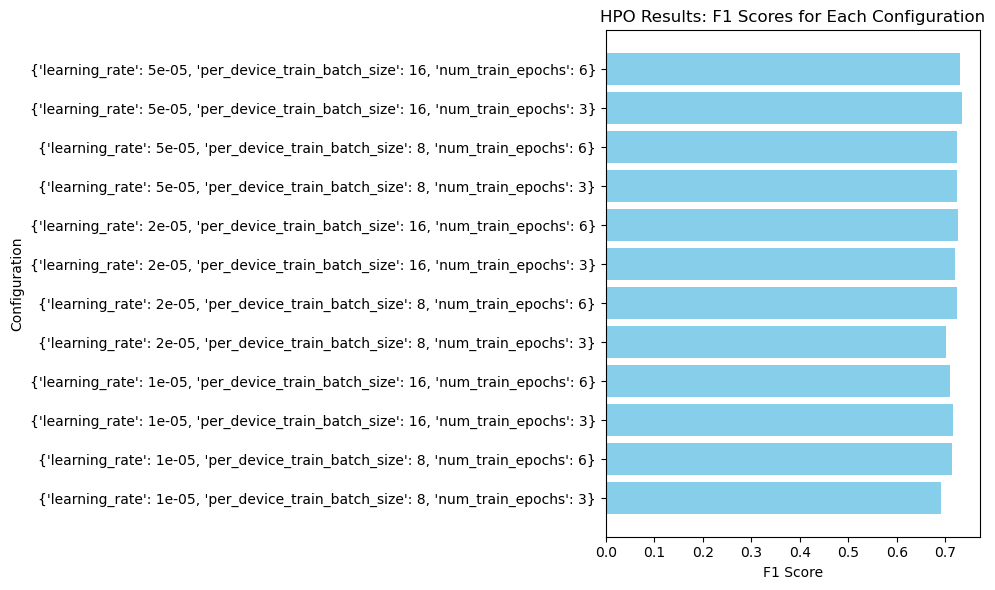

In [12]:
import matplotlib.pyplot as plt

# Extract configurations and corresponding F1 scores
configs = [str(res["config"]) for res in results]
f1_scores = [res["results"].get("eval_overall_f1", 0) for res in results]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(configs, f1_scores, color="skyblue")
plt.xlabel("F1 Score")
plt.ylabel("Configuration")
plt.title("HPO Results: F1 Scores for Each Configuration")
plt.tight_layout()
plt.show()


In [13]:
from transformers import TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=10,
)
from transformers import Trainer
from evaluate import load
import torch

# Load metric for evaluation
metric = load("seqeval")

def compute_metrics(predictions):
    predictions, labels = predictions
    predictions = torch.argmax(torch.tensor(predictions), dim=2)
    
    # Convert predictions and labels to CPU and then to plain Python integers
    predictions = predictions.cpu().numpy()
    
    true_labels = [
        [id_to_label[label] for label in label_seq if label != -100] 
        for label_seq in labels
    ]
    true_predictions = [
        [id_to_label[int(p)] for (p, l) in zip(prediction, label_seq) if l != -100]  # Convert tensor to int
        for prediction, label_seq in zip(predictions, labels)
    ]
    return metric.compute(predictions=true_predictions, references=true_labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=pipe.tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)


  5%|▌         | 10/189 [00:03<01:06,  2.68it/s]

{'loss': 0.0028, 'grad_norm': 1.3111085891723633, 'learning_rate': 4.7354497354497356e-05, 'epoch': 0.16}


 11%|█         | 20/189 [00:07<01:02,  2.69it/s]

{'loss': 0.0046, 'grad_norm': 0.6417688131332397, 'learning_rate': 4.470899470899471e-05, 'epoch': 0.32}


 16%|█▌        | 30/189 [00:11<00:58,  2.70it/s]

{'loss': 0.0033, 'grad_norm': 0.0981052964925766, 'learning_rate': 4.2063492063492065e-05, 'epoch': 0.48}


 21%|██        | 40/189 [00:15<00:55,  2.71it/s]

{'loss': 0.003, 'grad_norm': 1.4404011964797974, 'learning_rate': 3.941798941798942e-05, 'epoch': 0.63}


 26%|██▋       | 50/189 [00:18<00:51,  2.71it/s]

{'loss': 0.0038, 'grad_norm': 0.39653119444847107, 'learning_rate': 3.677248677248677e-05, 'epoch': 0.79}


 32%|███▏      | 60/189 [00:22<00:47,  2.71it/s]

{'loss': 0.0026, 'grad_norm': 0.4148912727832794, 'learning_rate': 3.412698412698413e-05, 'epoch': 0.95}


 33%|███▎      | 63/189 [00:24<00:38,  3.29it/s]

{'eval_loss': 0.4600832462310791, 'eval_ADR': {'precision': 0.5809859154929577, 'recall': 0.5436573311367381, 'f1': 0.5617021276595745, 'number': 607}, 'eval_DIS': {'precision': 0.28735632183908044, 'recall': 0.43103448275862066, 'f1': 0.3448275862068965, 'number': 58}, 'eval_DRU': {'precision': 0.9057750759878419, 'recall': 0.9254658385093167, 'f1': 0.9155145929339478, 'number': 322}, 'eval_SYM': {'precision': 0.41025641025641024, 'recall': 0.32, 'f1': 0.35955056179775285, 'number': 50}, 'eval_overall_precision': 0.6539589442815249, 'eval_overall_recall': 0.6451301832208293, 'eval_overall_f1': 0.6495145631067961, 'eval_overall_accuracy': 0.9360059592334259, 'eval_runtime': 1.0558, 'eval_samples_per_second': 119.34, 'eval_steps_per_second': 7.577, 'epoch': 1.0}


 37%|███▋      | 70/189 [00:28<00:52,  2.25it/s]

{'loss': 0.004, 'grad_norm': 0.49140578508377075, 'learning_rate': 3.148148148148148e-05, 'epoch': 1.11}


 42%|████▏     | 80/189 [00:31<00:40,  2.69it/s]

{'loss': 0.0031, 'grad_norm': 0.34028351306915283, 'learning_rate': 2.8835978835978838e-05, 'epoch': 1.27}


 48%|████▊     | 90/189 [00:35<00:36,  2.70it/s]

{'loss': 0.005, 'grad_norm': 0.3311493396759033, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.43}


 53%|█████▎    | 100/189 [00:39<00:32,  2.70it/s]

{'loss': 0.0046, 'grad_norm': 0.6859081983566284, 'learning_rate': 2.3544973544973546e-05, 'epoch': 1.59}


 58%|█████▊    | 110/189 [00:43<00:29,  2.70it/s]

{'loss': 0.0025, 'grad_norm': 0.2101563811302185, 'learning_rate': 2.08994708994709e-05, 'epoch': 1.75}


 63%|██████▎   | 120/189 [00:46<00:25,  2.69it/s]

{'loss': 0.0017, 'grad_norm': 0.925952672958374, 'learning_rate': 1.8253968253968254e-05, 'epoch': 1.9}


 67%|██████▋   | 126/189 [00:49<00:19,  3.29it/s]

{'eval_loss': 0.44356662034988403, 'eval_ADR': {'precision': 0.543035993740219, 'recall': 0.57166392092257, 'f1': 0.5569823434991975, 'number': 607}, 'eval_DIS': {'precision': 0.3230769230769231, 'recall': 0.3620689655172414, 'f1': 0.34146341463414637, 'number': 58}, 'eval_DRU': {'precision': 0.9063444108761329, 'recall': 0.9316770186335404, 'f1': 0.9188361408882083, 'number': 322}, 'eval_SYM': {'precision': 0.34375, 'recall': 0.22, 'f1': 0.2682926829268293, 'number': 50}, 'eval_overall_precision': 0.6363636363636364, 'eval_overall_recall': 0.6547733847637416, 'eval_overall_f1': 0.6454372623574144, 'eval_overall_accuracy': 0.9346515880002709, 'eval_runtime': 1.0649, 'eval_samples_per_second': 118.32, 'eval_steps_per_second': 7.512, 'epoch': 2.0}


 69%|██████▉   | 130/189 [00:52<00:34,  1.73it/s]

{'loss': 0.0023, 'grad_norm': 1.5501846075057983, 'learning_rate': 1.560846560846561e-05, 'epoch': 2.06}


 74%|███████▍  | 140/189 [00:56<00:18,  2.66it/s]

{'loss': 0.0022, 'grad_norm': 0.043516114354133606, 'learning_rate': 1.2962962962962962e-05, 'epoch': 2.22}


 79%|███████▉  | 150/189 [00:59<00:14,  2.70it/s]

{'loss': 0.0021, 'grad_norm': 0.9686434268951416, 'learning_rate': 1.0317460317460318e-05, 'epoch': 2.38}


 85%|████████▍ | 160/189 [01:03<00:10,  2.70it/s]

{'loss': 0.0016, 'grad_norm': 0.5388738512992859, 'learning_rate': 7.671957671957672e-06, 'epoch': 2.54}


 90%|████████▉ | 170/189 [01:07<00:07,  2.69it/s]

{'loss': 0.003, 'grad_norm': 0.14280104637145996, 'learning_rate': 5.026455026455026e-06, 'epoch': 2.7}


 95%|█████████▌| 180/189 [01:10<00:03,  2.71it/s]

{'loss': 0.0019, 'grad_norm': 0.509722113609314, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}


100%|██████████| 189/189 [01:16<00:00,  3.29it/s]

{'eval_loss': 0.4454812705516815, 'eval_ADR': {'precision': 0.5477308294209703, 'recall': 0.5766062602965404, 'f1': 0.5617977528089888, 'number': 607}, 'eval_DIS': {'precision': 0.3617021276595745, 'recall': 0.29310344827586204, 'f1': 0.32380952380952377, 'number': 58}, 'eval_DRU': {'precision': 0.9046153846153846, 'recall': 0.9130434782608695, 'f1': 0.9088098918083461, 'number': 322}, 'eval_SYM': {'precision': 0.4230769230769231, 'recall': 0.22, 'f1': 0.28947368421052627, 'number': 50}, 'eval_overall_precision': 0.648023143683703, 'eval_overall_recall': 0.648023143683703, 'eval_overall_f1': 0.648023143683703, 'eval_overall_accuracy': 0.9360736777950837, 'eval_runtime': 1.0574, 'eval_samples_per_second': 119.159, 'eval_steps_per_second': 7.566, 'epoch': 3.0}


100%|██████████| 189/189 [01:17<00:00,  2.44it/s]


{'train_runtime': 77.5318, 'train_samples_per_second': 38.616, 'train_steps_per_second': 2.438, 'train_loss': 0.0029488159047942313, 'epoch': 3.0}


100%|██████████| 8/8 [00:00<00:00,  8.59it/s]

Evaluation Results: {'eval_loss': 0.44356662034988403, 'eval_ADR': {'precision': 0.543035993740219, 'recall': 0.57166392092257, 'f1': 0.5569823434991975, 'number': 607}, 'eval_DIS': {'precision': 0.3230769230769231, 'recall': 0.3620689655172414, 'f1': 0.34146341463414637, 'number': 58}, 'eval_DRU': {'precision': 0.9063444108761329, 'recall': 0.9316770186335404, 'f1': 0.9188361408882083, 'number': 322}, 'eval_SYM': {'precision': 0.34375, 'recall': 0.22, 'f1': 0.2682926829268293, 'number': 50}, 'eval_overall_precision': 0.6363636363636364, 'eval_overall_recall': 0.6547733847637416, 'eval_overall_f1': 0.6454372623574144, 'eval_overall_accuracy': 0.9346515880002709, 'eval_runtime': 1.0572, 'eval_samples_per_second': 119.179, 'eval_steps_per_second': 7.567, 'epoch': 3.0}
